# Objective: fine-tuning DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.13.1+cu116 True


/home/wendell/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load an image for a demo

In [6]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /home/wendell/.cache/torch/hub/facebookresearch_detr_main
/home/wendell/miniconda3/envs/cv-hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wendell/miniconda3/envs/cv-hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [8]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

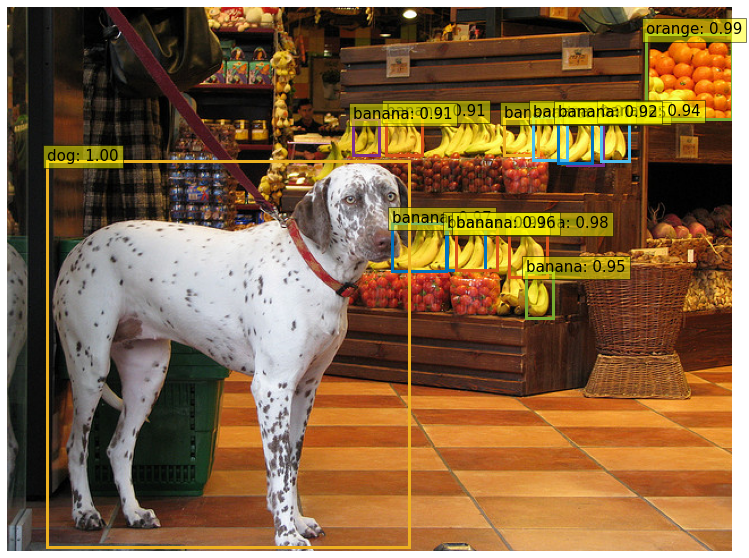

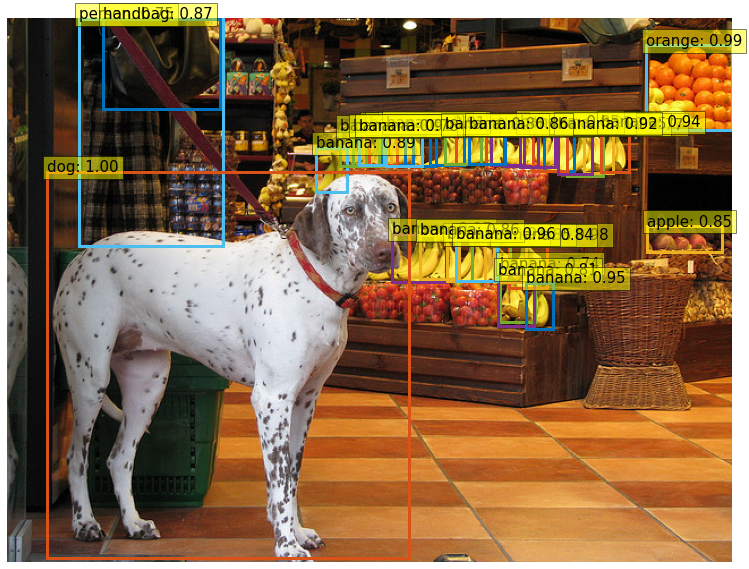

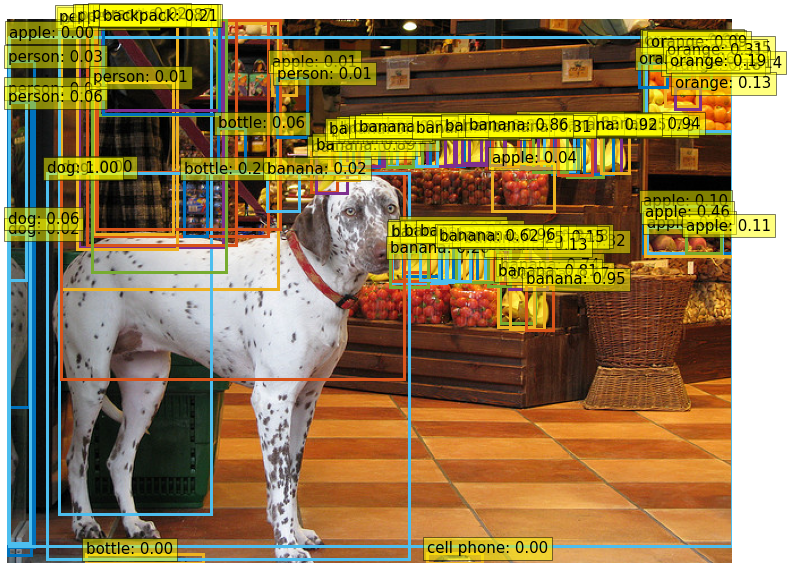

In [9]:
for threshold in [0.9, 0.7, 0.0]:
  
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

NB: if the threshold is equal to zero, then you will see all of the 100 query slots. The zero-threshold is only used for illustration. In usual cases, most query slots have a low confidence score, so that irrelevant query slots would be pruned with a higher threshold, such as 0.7 or 0.9.

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-635357693

NB²: For fine-tuning purposes, we cannot change the number of query slots.

> If you're fine-tuning, I don't recommend changing the number of queries on the fly, it is extremely unlikely to work out of the box. In this case you're probably better off retraining from scratch (you can change the --num_queries arg from our training script).

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-636407752

## Clone my custom code of DETR

Clone [my fork](https://github.com/woctezuma/detr/tree/finetune) tailored for a custom dataset:
-   called `custom`,
-   with `max_class_id = 2` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Caveat**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`. My fork can do that.


In [10]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

[Errno 2] No such file or directory: '/content/'
/home/wendell/r11922150/cv-hw1
Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 323.67 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/home/wendell/r11922150/cv-hw1/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [11]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

## Prepare the dataset for fine-tuning

The `balloon` dataset will be used. It is featured here and uses VIA format:
-   https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon


You can choose whether to start indexing categories with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

In [12]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

Clone [my fork](https://github.com/woctezuma/VIA2COCO/tree/fixes) to convert annotations from VIA format to COCO format.

In [13]:
# %cd /content/

# !rm -rf VIA2COCO
# !git clone https://github.com/woctezuma/VIA2COCO

# %cd VIA2COCO/

# !git checkout fixes

In [14]:
# # download, decompress the data
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

In [15]:
# import convert as via2coco

# data_path = '/content/VIA2COCO/'

# for keyword in ['train', 'val']:

#   input_dir = data_path + 'balloon/' + keyword + '/'
#   input_json = input_dir + 'via_region_data.json'
#   categories = ['balloon']
#   super_categories = ['N/A']
#   output_json = input_dir + 'custom_' + keyword + '.json'

#   print('Converting {} from VIA format to COCO format'.format(input_json))

#   coco_dict = via2coco.convert(
#       imgdir=input_dir,
#       annpath=input_json,
#       categories=categories,
#       super_categories=super_categories,
#       output_file_name=output_json,
#       first_class_index=first_class_index,
#   )

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [16]:
# !mkdir -p /content/data/custom/annotations/

# !mv /content/VIA2COCO/balloon/train/custom_train.json /content/data/custom/annotations/custom_train.json
# !mv /content/VIA2COCO/balloon/val/custom_val.json /content/data/custom/annotations/custom_val.json

# !mkdir -p /content/data/custom/train2017/

# !mv /content/VIA2COCO/balloon/train/*.jpg /content/data/custom/train2017/

# !mkdir -p /content/data/custom/val2017/

# !mv /content/VIA2COCO/balloon/val/*.jpg /content/data/custom/val2017/

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [17]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [20]:
dataDir='../data/'
dataType='train'
annFile='{}annotations/train_annotations.json'.format(dataDir)

In [21]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [22]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Super-categories: {'creatures', 'none'}


In [23]:
# load and display image
catIds = coco.getCatIds(catNms=['balloon']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°274
Image name: ../data//train/IMG_2631_jpeg_jpg.rf.96fbf4652e525919f27d48720cc706e0.jpg


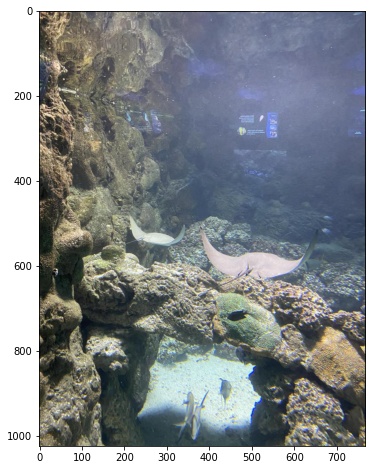

In [24]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [25]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

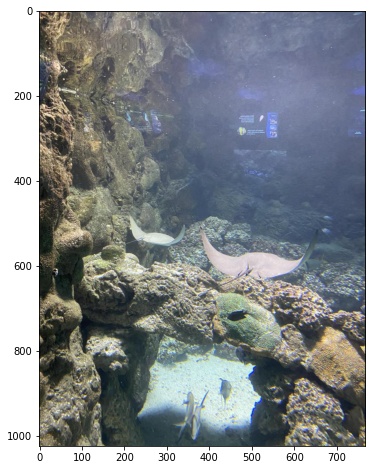

In [26]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

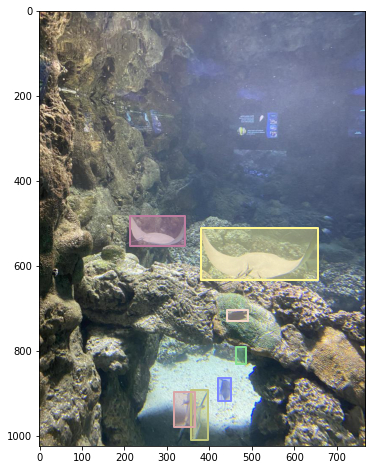

In [27]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [29]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 8

  finetuned_classes = ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = ['N/A','creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 8
Fine-tuned classes: ['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']


In [30]:
# %cd /detr/

[Errno 2] No such file or directory: 'detr/'
/home/wendell/r11922150/cv-hw1/detr


**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in my `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

In [37]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "../data" \
  --output_dir "outputs" \
  --resume "./outputs/checkpoint.pth" \
  --num_classes $num_classes \
  --epochs 300

Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: has uncommited changes, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='../data', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=8, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='./outputs/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
/home/wendell/miniconda3/envs/cv-hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.8151 (7.2708)
loss_ce: 0.3794 (0.3522)
loss_bbox: 0.1916 (0.2257)
loss_giou: 0.5739 (0.5971)
loss_ce_0: 0.4395 (0.4100)
loss_bbox_0: 0.2283 (0.2448)
loss_giou_0: 0.6446 (0.6293)
loss_ce_1: 0.4226 (0.4049)
loss_bbox_1: 0.2088 (0.2351)
loss_giou_1: 0.6324 (0.6156)
loss_ce_2: 0.3866 (0.3593)
loss_bbox_2: 0.2277 (0.2402)
loss_giou_2: 0.6168 (0.6102)
loss_ce_3: 0.4025 (0.3461)
loss_bbox_3: 0.2010 (0.2287)
loss_giou_3: 0.5808 (0.6032)
loss_ce_4: 0.3442 (0.3458)
loss_bbox_4: 0.1832 (0.2267)
loss_giou_4: 0.5871 (0.5957)
loss_ce_unscaled: 0.3794 (0.3522)
class_error_unscaled: 25.0000 (18.0962)
loss_bbox_unscaled: 0.0383 (0.0451)
loss_giou_unscaled: 0.2869 (0.2986)
cardinality_error_unscaled: 1.5000 (2.8281)
loss_ce_0_unscaled: 0.4395 (0.4100)
loss_bbox_0_unscaled: 0.0457 (0.0490)
loss_giou_0_unscaled: 0.3223 (0.3147)
cardinality_error_0_unscaled: 3.0000 (9.0391)
loss_ce_1_unscaled: 0.4226 (0.4049)
loss_bbox_1_unscaled: 0.0418 (0.0470)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.4954 (6.4954)
loss_ce: 0.4021 (0.4021)
loss_bbox: 0.2143 (0.2143)
loss_giou: 0.3694 (0.3694)
loss_ce_0: 0.4034 (0.4034)
loss_bbox_0: 0.2495 (0.2495)
loss_giou_0: 0.4345 (0.4345)
loss_ce_1: 0.5601 (0.5601)
loss_bbox_1: 0.2403 (0.2403)
loss_giou_1: 0.3191 (0.3191)
loss_ce_2: 0.5772 (0.5772)
loss_bbox_2: 0.2158 (0.2158)
loss_giou_2: 0.3421 (0.3421)
loss_ce_3: 0.6114 (0.6114)
loss_bbox_3: 0.1933 (0.1933)
loss_giou_3: 0.3660 (0.3660)
loss_ce_4: 0.4104 (0.4104)
loss_bbox_4: 0.2292 (0.2292)
loss_giou_4: 0.3573 (0.3573)
loss_ce_unscaled: 0.4021 (0.4021)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0429 (0.0429)
loss_giou_unscaled: 0.1847 (0.1847)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.4034 (0.4034)
loss_bbox_0_unscaled: 0.0499 (0.0499)
loss_giou_0_unscaled: 0.2172 (0.2172)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.5601 (0.5601)
loss_bbox_1_unscaled: 0.0481 (0.0481)
loss_g

Epoch: [102] Total time: 0:00:22 (0.0999 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 5.2376 (5.1917)
loss_ce: 0.1236 (0.1338)
loss_bbox: 0.1560 (0.1742)
loss_giou: 0.5167 (0.5001)
loss_ce_0: 0.2619 (0.2564)
loss_bbox_0: 0.1879 (0.2076)
loss_giou_0: 0.4886 (0.5542)
loss_ce_1: 0.1555 (0.1984)
loss_bbox_1: 0.1768 (0.1867)
loss_giou_1: 0.4810 (0.5184)
loss_ce_2: 0.1897 (0.1527)
loss_bbox_2: 0.1608 (0.1824)
loss_giou_2: 0.5078 (0.5062)
loss_ce_3: 0.1031 (0.1314)
loss_bbox_3: 0.1588 (0.1794)
loss_giou_3: 0.5460 (0.5010)
loss_ce_4: 0.1170 (0.1306)
loss_bbox_4: 0.1528 (0.1770)
loss_giou_4: 0.4827 (0.5011)
loss_ce_unscaled: 0.1236 (0.1338)
class_error_unscaled: 6.2500 (6.0623)
loss_bbox_unscaled: 0.0312 (0.0348)
loss_giou_unscaled: 0.2584 (0.2501)
cardinality_error_unscaled: 1.0000 (3.5000)
loss_ce_0_unscaled: 0.2619 (0.2564)
loss_bbox_0_unscaled: 0.0376 (0.0415)
loss_giou_0_unscaled: 0.2443 (0.2771)
cardinality_error_0_unscaled: 3.5000 (9.5826)
loss_ce_1_unscaled: 0.1555 (0.19

Epoch: [103]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 6.45
loss: 4.8176 (5.4258)
loss_ce: 0.1477 (0.1436)
loss_bbox: 0.1597 (0.1827)
loss_giou: 0.5183 (0.5247)
loss_ce_0: 0.2493 (0.2697)
loss_bbox_0: 0.1984 (0.2112)
loss_giou_0: 0.5306 (0.5760)
loss_ce_1: 0.1846 (0.2033)
loss_bbox_1: 0.1754 (0.1943)
loss_giou_1: 0.5011 (0.5413)
loss_ce_2: 0.1288 (0.1644)
loss_bbox_2: 0.1632 (0.1862)
loss_giou_2: 0.5066 (0.5260)
loss_ce_3: 0.0969 (0.1445)
loss_bbox_3: 0.1645 (0.1844)
loss_giou_3: 0.4972 (0.5260)
loss_ce_4: 0.0987 (0.1406)
loss_bbox_4: 0.1635 (0.1830)
loss_giou_4: 0.4643 (0.5240)
loss_ce_unscaled: 0.1477 (0.1436)
class_error_unscaled: 6.4516 (7.4455)
loss_bbox_unscaled: 0.0319 (0.0365)
loss_giou_unscaled: 0.2592 (0.2624)
cardinality_error_unscaled: 1.0000 (3.4263)
loss_ce_0_unscaled: 0.2493 (0.2697)
loss_bbox_0_unscaled: 0.0397 (0.0422)
loss_giou_0_unscaled: 0.2653 (0.2880)
cardinality_error_0_unscaled: 4.5000 (9.1272)
loss_ce_1_unscaled: 0.1846 (0.2033)
loss_bbox_1_unscaled: 0.0

Epoch: [104]
[  0/224]
eta: 0:01:13
lr: 0.000100
class_error: 0.00
loss: 4.8804 (4.8804)
loss_ce: 0.2207 (0.2207)
loss_bbox: 0.1412 (0.1412)
loss_giou: 0.4051 (0.4051)
loss_ce_0: 0.3117 (0.3117)
loss_bbox_0: 0.1694 (0.1694)
loss_giou_0: 0.4156 (0.4156)
loss_ce_1: 0.2761 (0.2761)
loss_bbox_1: 0.1560 (0.1560)
loss_giou_1: 0.3817 (0.3817)
loss_ce_2: 0.2657 (0.2657)
loss_bbox_2: 0.1472 (0.1472)
loss_giou_2: 0.4133 (0.4133)
loss_ce_3: 0.1782 (0.1782)
loss_bbox_3: 0.1533 (0.1533)
loss_giou_3: 0.4280 (0.4280)
loss_ce_4: 0.2142 (0.2142)
loss_bbox_4: 0.1578 (0.1578)
loss_giou_4: 0.4452 (0.4452)
loss_ce_unscaled: 0.2207 (0.2207)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0282 (0.0282)
loss_giou_unscaled: 0.2026 (0.2026)
cardinality_error_unscaled: 11.5000 (11.5000)
loss_ce_0_unscaled: 0.3117 (0.3117)
loss_bbox_0_unscaled: 0.0339 (0.0339)
loss_giou_0_unscaled: 0.2078 (0.2078)
cardinality_error_0_unscaled: 21.0000 (21.0000)
loss_ce_1_unscaled: 0.2761 (0.2761)
loss_bbox_1_unscaled:

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.618
Epoch: 

Test: Total time: 0:00:04 (0.0712 s / it)
Averaged stats: class_error: 16.67
loss: 7.7701 (7.1862)
loss_ce: 0.2447 (0.2867)
loss_bbox: 0.2360 (0.2459)
loss_giou: 0.5582 (0.6152)
loss_ce_0: 0.3453 (0.3803)
loss_bbox_0: 0.2503 (0.2657)
loss_giou_0: 0.5918 (0.6798)
loss_ce_1: 0.3208 (0.3350)
loss_bbox_1: 0.2605 (0.2532)
loss_giou_1: 0.5992 (0.6406)
loss_ce_2: 0.2935 (0.3069)
loss_bbox_2: 0.2342 (0.2444)
loss_giou_2: 0.5721 (0.6274)
loss_ce_3: 0.2941 (0.2974)
loss_bbox_3: 0.2507 (0.2431)
loss_giou_3: 0.5693 (0.6179)
loss_ce_4: 0.2767 (0.2897)
loss_bbox_4: 0.2483 (0.2453)
loss_giou_4: 0.5677 (0.6120)
loss_ce_unscaled: 0.2447 (0.2867)
class_error_unscaled: 20.0000 (15.5773)
loss_bbox_unscaled: 0.0472 (0.0492)
loss_giou_unscaled: 0.2791 (0.3076)
cardinality_error_unscaled: 2.0000 (3.3828)
loss_ce_0_unscaled: 0.3453 (0.3803)
loss_bbox_0_unscaled: 0.0501 (0.0531)
loss_giou_0_unscaled: 0.2959 (0.3399)
cardinality_error_0_unscaled: 6.0000 (9.9297)
loss_ce_1_unscaled: 0.3208 (0.3350)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.1729 (7.5392)
loss_ce: 0.2863 (0.3367)
loss_bbox: 0.2209 (0.2337)
loss_giou: 0.6239 (0.6105)
loss_ce_0: 0.4062 (0.4682)
loss_bbox_0: 0.2401 (0.2656)
loss_giou_0: 0.6350 (0.6980)
loss_ce_1: 0.3878 (0.4084)
loss_bbox_1: 0.2261 (0.2475)
loss_giou_1: 0.6036 (0.6489)
loss_ce_2: 0.2917 (0.3635)
loss_bbox_2: 0.2351 (0.2418)
loss_giou_2: 0.5951 (0.6320)
loss_ce_3: 0.2962 (0.3472)
loss_bbox_3: 0.2191 (0.2349)
loss_giou_3: 0.6476 (0.6207)
loss_ce_4: 0.3131 (0.3386)
loss_bbox_4: 0.2160 (0.2327)
loss_giou_4: 0.6326 (0.6102)
loss_ce_unscaled: 0.2863 (0.3367)
class_error_unscaled: 18.0000 (18.3020)
loss_bbox_unscaled: 0.0442 (0.0467)
loss_giou_unscaled: 0.3119 (0.3052)
cardinality_error_unscaled: 1.0000 (3.1406)
loss_ce_0_unscaled: 0.4062 (0.4682)
loss_bbox_0_unscaled: 0.0480 (0.0531)
loss_giou_0_unscaled: 0.3175 (0.3490)
cardinality_error_0_unscaled: 4.5000 (9.1719)
loss_ce_1_unscaled: 0.3878 (0.4084)
loss_bbox_1_unscaled: 0.0452 (0.0495)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 6.6881 (6.6881)
loss_ce: 0.3046 (0.3046)
loss_bbox: 0.1815 (0.1815)
loss_giou: 0.3546 (0.3546)
loss_ce_0: 0.3986 (0.3986)
loss_bbox_0: 0.3568 (0.3568)
loss_giou_0: 0.4515 (0.4515)
loss_ce_1: 0.5014 (0.5014)
loss_bbox_1: 0.3922 (0.3922)
loss_giou_1: 0.5230 (0.5230)
loss_ce_2: 0.3521 (0.3521)
loss_bbox_2: 0.3472 (0.3472)
loss_giou_2: 0.4485 (0.4485)
loss_ce_3: 0.3308 (0.3308)
loss_bbox_3: 0.3146 (0.3146)
loss_giou_3: 0.4472 (0.4472)
loss_ce_4: 0.3372 (0.3372)
loss_bbox_4: 0.2782 (0.2782)
loss_giou_4: 0.3682 (0.3682)
loss_ce_unscaled: 0.3046 (0.3046)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0363 (0.0363)
loss_giou_unscaled: 0.1773 (0.1773)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3986 (0.3986)
loss_bbox_0_unscaled: 0.0714 (0.0714)
loss_giou_0_unscaled: 0.2257 (0.2257)
cardinality_error_0_unscaled: 2.0000 (2.0000)
loss_ce_1_unscaled: 0.5014 (0.5014)
loss_bbox_1_unscaled: 0.0784 (0.0784)
loss_g

Epoch: [108] Total time: 0:00:22 (0.0992 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.5558 (5.2088)
loss_ce: 0.0742 (0.1234)
loss_bbox: 0.1610 (0.1836)
loss_giou: 0.4313 (0.5046)
loss_ce_0: 0.2048 (0.2457)
loss_bbox_0: 0.1784 (0.2191)
loss_giou_0: 0.4418 (0.5642)
loss_ce_1: 0.1728 (0.1876)
loss_bbox_1: 0.1636 (0.1922)
loss_giou_1: 0.4351 (0.5139)
loss_ce_2: 0.1572 (0.1465)
loss_bbox_2: 0.1532 (0.1866)
loss_giou_2: 0.4012 (0.5118)
loss_ce_3: 0.0910 (0.1295)
loss_bbox_3: 0.1635 (0.1862)
loss_giou_3: 0.4433 (0.5051)
loss_ce_4: 0.0749 (0.1265)
loss_bbox_4: 0.1686 (0.1813)
loss_giou_4: 0.4340 (0.5011)
loss_ce_unscaled: 0.0742 (0.1234)
class_error_unscaled: 0.0000 (5.6140)
loss_bbox_unscaled: 0.0322 (0.0367)
loss_giou_unscaled: 0.2156 (0.2523)
cardinality_error_unscaled: 0.5000 (3.4174)
loss_ce_0_unscaled: 0.2048 (0.2457)
loss_bbox_0_unscaled: 0.0357 (0.0438)
loss_giou_0_unscaled: 0.2209 (0.2821)
cardinality_error_0_unscaled: 5.0000 (8.9598)
loss_ce_1_unscaled: 0.1728 (0.18

Epoch: [109]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 20.00
loss: 4.2403 (5.1772)
loss_ce: 0.0538 (0.1264)
loss_bbox: 0.1601 (0.1867)
loss_giou: 0.4290 (0.4990)
loss_ce_0: 0.2181 (0.2562)
loss_bbox_0: 0.1739 (0.2077)
loss_giou_0: 0.4853 (0.5507)
loss_ce_1: 0.1444 (0.1905)
loss_bbox_1: 0.1608 (0.1885)
loss_giou_1: 0.4062 (0.5045)
loss_ce_2: 0.0937 (0.1480)
loss_bbox_2: 0.1653 (0.1864)
loss_giou_2: 0.4261 (0.5053)
loss_ce_3: 0.0651 (0.1283)
loss_bbox_3: 0.1485 (0.1851)
loss_giou_3: 0.4130 (0.5020)
loss_ce_4: 0.0615 (0.1240)
loss_bbox_4: 0.1605 (0.1874)
loss_giou_4: 0.4383 (0.5007)
loss_ce_unscaled: 0.0538 (0.1264)
class_error_unscaled: 0.0000 (6.1207)
loss_bbox_unscaled: 0.0320 (0.0373)
loss_giou_unscaled: 0.2145 (0.2495)
cardinality_error_unscaled: 0.5000 (3.0089)
loss_ce_0_unscaled: 0.2181 (0.2562)
loss_bbox_0_unscaled: 0.0348 (0.0415)
loss_giou_0_unscaled: 0.2426 (0.2753)
cardinality_error_0_unscaled: 4.0000 (9.1629)
loss_ce_1_unscaled: 0.1444 (0.1905)
loss_bbox_1_unscaled: 0.

Epoch: [110]
[  0/224]
eta: 0:01:01
lr: 0.000100
class_error: 0.00
loss: 2.0782 (2.0782)
loss_ce: 0.0127 (0.0127)
loss_bbox: 0.0949 (0.0949)
loss_giou: 0.2304 (0.2304)
loss_ce_0: 0.0534 (0.0534)
loss_bbox_0: 0.1297 (0.1297)
loss_giou_0: 0.1430 (0.1430)
loss_ce_1: 0.0421 (0.0421)
loss_bbox_1: 0.1531 (0.1531)
loss_giou_1: 0.2107 (0.2107)
loss_ce_2: 0.0280 (0.0280)
loss_bbox_2: 0.1408 (0.1408)
loss_giou_2: 0.1823 (0.1823)
loss_ce_3: 0.0176 (0.0176)
loss_bbox_3: 0.1163 (0.1163)
loss_giou_3: 0.2201 (0.2201)
loss_ce_4: 0.0143 (0.0143)
loss_bbox_4: 0.0799 (0.0799)
loss_giou_4: 0.2089 (0.2089)
loss_ce_unscaled: 0.0127 (0.0127)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0190 (0.0190)
loss_giou_unscaled: 0.1152 (0.1152)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.0534 (0.0534)
loss_bbox_0_unscaled: 0.0259 (0.0259)
loss_giou_0_unscaled: 0.0715 (0.0715)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.0421 (0.0421)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.622
Epoch: 

Test: Total time: 0:00:04 (0.0713 s / it)
Averaged stats: class_error: 0.00
loss: 7.3992 (7.5304)
loss_ce: 0.3474 (0.3613)
loss_bbox: 0.2034 (0.2315)
loss_giou: 0.5299 (0.5979)
loss_ce_0: 0.4322 (0.4620)
loss_bbox_0: 0.2358 (0.2624)
loss_giou_0: 0.6467 (0.6650)
loss_ce_1: 0.4153 (0.4216)
loss_bbox_1: 0.1979 (0.2544)
loss_giou_1: 0.6432 (0.6569)
loss_ce_2: 0.3515 (0.3750)
loss_bbox_2: 0.1994 (0.2443)
loss_giou_2: 0.5691 (0.6277)
loss_ce_3: 0.3926 (0.3463)
loss_bbox_3: 0.1996 (0.2377)
loss_giou_3: 0.5488 (0.6047)
loss_ce_4: 0.3635 (0.3508)
loss_bbox_4: 0.1991 (0.2328)
loss_giou_4: 0.5830 (0.5984)
loss_ce_unscaled: 0.3474 (0.3613)
class_error_unscaled: 20.0000 (17.9140)
loss_bbox_unscaled: 0.0407 (0.0463)
loss_giou_unscaled: 0.2650 (0.2989)
cardinality_error_unscaled: 2.5000 (4.6641)
loss_ce_0_unscaled: 0.4322 (0.4620)
loss_bbox_0_unscaled: 0.0472 (0.0525)
loss_giou_0_unscaled: 0.3234 (0.3325)
cardinality_error_0_unscaled: 5.0000 (11.5859)
loss_ce_1_unscaled: 0.4153 (0.4216)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.2999 (7.4454)
loss_ce: 0.2534 (0.3686)
loss_bbox: 0.2539 (0.2390)
loss_giou: 0.5982 (0.6012)
loss_ce_0: 0.4062 (0.4429)
loss_bbox_0: 0.2440 (0.2520)
loss_giou_0: 0.6657 (0.6315)
loss_ce_1: 0.3248 (0.4156)
loss_bbox_1: 0.2341 (0.2323)
loss_giou_1: 0.6136 (0.6060)
loss_ce_2: 0.2562 (0.3740)
loss_bbox_2: 0.2391 (0.2425)
loss_giou_2: 0.6179 (0.6053)
loss_ce_3: 0.2432 (0.3645)
loss_bbox_3: 0.2490 (0.2434)
loss_giou_3: 0.6430 (0.6045)
loss_ce_4: 0.2544 (0.3816)
loss_bbox_4: 0.2520 (0.2404)
loss_giou_4: 0.6243 (0.6000)
loss_ce_unscaled: 0.2534 (0.3686)
class_error_unscaled: 16.6667 (17.7673)
loss_bbox_unscaled: 0.0508 (0.0478)
loss_giou_unscaled: 0.2991 (0.3006)
cardinality_error_unscaled: 1.5000 (3.4375)
loss_ce_0_unscaled: 0.4062 (0.4429)
loss_bbox_0_unscaled: 0.0488 (0.0504)
loss_giou_0_unscaled: 0.3328 (0.3158)
cardinality_error_0_unscaled: 5.0000 (9.6328)
loss_ce_1_unscaled: 0.3248 (0.4156)
loss_bbox_1_unscaled: 0.0468 (0.0465)
loss_g

Test:
[ 0/64]
eta: 0:00:14
class_error: 20.00
loss: 5.8581 (5.8581)
loss_ce: 0.2982 (0.2982)
loss_bbox: 0.2674 (0.2674)
loss_giou: 0.3844 (0.3844)
loss_ce_0: 0.4464 (0.4464)
loss_bbox_0: 0.3670 (0.3670)
loss_giou_0: 0.4620 (0.4620)
loss_ce_1: 0.3457 (0.3457)
loss_bbox_1: 0.2109 (0.2109)
loss_giou_1: 0.3481 (0.3481)
loss_ce_2: 0.3067 (0.3067)
loss_bbox_2: 0.2033 (0.2033)
loss_giou_2: 0.3687 (0.3687)
loss_ce_3: 0.3266 (0.3266)
loss_bbox_3: 0.1947 (0.1947)
loss_giou_3: 0.3929 (0.3929)
loss_ce_4: 0.3324 (0.3324)
loss_bbox_4: 0.2380 (0.2380)
loss_giou_4: 0.3645 (0.3645)
loss_ce_unscaled: 0.2982 (0.2982)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0535 (0.0535)
loss_giou_unscaled: 0.1922 (0.1922)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.4464 (0.4464)
loss_bbox_0_unscaled: 0.0734 (0.0734)
loss_giou_0_unscaled: 0.2310 (0.2310)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.3457 (0.3457)
loss_bbox_1_unscaled: 0.0422 (0.0422)
loss_g

Epoch: [114] Total time: 0:00:22 (0.1008 s / it)
Averaged stats: lr: 0.000100
class_error: 5.00
loss: 5.6440 (5.1392)
loss_ce: 0.1253 (0.1235)
loss_bbox: 0.1573 (0.1710)
loss_giou: 0.5237 (0.5073)
loss_ce_0: 0.2670 (0.2479)
loss_bbox_0: 0.1932 (0.2027)
loss_giou_0: 0.5585 (0.5583)
loss_ce_1: 0.2378 (0.1871)
loss_bbox_1: 0.1616 (0.1793)
loss_giou_1: 0.5195 (0.5147)
loss_ce_2: 0.1824 (0.1538)
loss_bbox_2: 0.1638 (0.1760)
loss_giou_2: 0.5144 (0.5098)
loss_ce_3: 0.1409 (0.1308)
loss_bbox_3: 0.1645 (0.1732)
loss_giou_3: 0.5191 (0.5065)
loss_ce_4: 0.1418 (0.1239)
loss_bbox_4: 0.1630 (0.1708)
loss_giou_4: 0.4835 (0.5025)
loss_ce_unscaled: 0.1253 (0.1235)
class_error_unscaled: 0.0000 (5.4591)
loss_bbox_unscaled: 0.0315 (0.0342)
loss_giou_unscaled: 0.2618 (0.2537)
cardinality_error_unscaled: 3.0000 (3.7366)
loss_ce_0_unscaled: 0.2670 (0.2479)
loss_bbox_0_unscaled: 0.0386 (0.0405)
loss_giou_0_unscaled: 0.2793 (0.2791)
cardinality_error_0_unscaled: 10.5000 (9.6138)
loss_ce_1_unscaled: 0.2378 (0.1

Epoch: [115]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.0294 (5.1321)
loss_ce: 0.0489 (0.1191)
loss_bbox: 0.1550 (0.1905)
loss_giou: 0.3634 (0.4959)
loss_ce_0: 0.2455 (0.2532)
loss_bbox_0: 0.1841 (0.2106)
loss_giou_0: 0.4370 (0.5247)
loss_ce_1: 0.1232 (0.1865)
loss_bbox_1: 0.1650 (0.1964)
loss_giou_1: 0.4076 (0.4995)
loss_ce_2: 0.0864 (0.1522)
loss_bbox_2: 0.1657 (0.1888)
loss_giou_2: 0.3601 (0.4957)
loss_ce_3: 0.0636 (0.1227)
loss_bbox_3: 0.1592 (0.1921)
loss_giou_3: 0.3624 (0.4983)
loss_ce_4: 0.0545 (0.1227)
loss_bbox_4: 0.1565 (0.1900)
loss_giou_4: 0.3611 (0.4933)
loss_ce_unscaled: 0.0489 (0.1191)
class_error_unscaled: 0.0000 (5.7324)
loss_bbox_unscaled: 0.0310 (0.0381)
loss_giou_unscaled: 0.1817 (0.2479)
cardinality_error_unscaled: 1.5000 (3.0558)
loss_ce_0_unscaled: 0.2455 (0.2532)
loss_bbox_0_unscaled: 0.0368 (0.0421)
loss_giou_0_unscaled: 0.2185 (0.2624)
cardinality_error_0_unscaled: 4.0000 (9.1004)
loss_ce_1_unscaled: 0.1232 (0.1865)
loss_bbox_1_unscaled: 0.0

Epoch: [116]
[  0/224]
eta: 0:00:56
lr: 0.000100
class_error: 0.00
loss: 3.1711 (3.1711)
loss_ce: 0.0636 (0.0636)
loss_bbox: 0.1456 (0.1456)
loss_giou: 0.2614 (0.2614)
loss_ce_0: 0.1843 (0.1843)
loss_bbox_0: 0.2577 (0.2577)
loss_giou_0: 0.4063 (0.4063)
loss_ce_1: 0.1284 (0.1284)
loss_bbox_1: 0.1357 (0.1357)
loss_giou_1: 0.2248 (0.2248)
loss_ce_2: 0.0749 (0.0749)
loss_bbox_2: 0.1284 (0.1284)
loss_giou_2: 0.2460 (0.2460)
loss_ce_3: 0.0660 (0.0660)
loss_bbox_3: 0.1459 (0.1459)
loss_giou_3: 0.2493 (0.2493)
loss_ce_4: 0.0647 (0.0647)
loss_bbox_4: 0.1422 (0.1422)
loss_giou_4: 0.2459 (0.2459)
loss_ce_unscaled: 0.0636 (0.0636)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0291 (0.0291)
loss_giou_unscaled: 0.1307 (0.1307)
cardinality_error_unscaled: 3.0000 (3.0000)
loss_ce_0_unscaled: 0.1843 (0.1843)
loss_bbox_0_unscaled: 0.0515 (0.0515)
loss_giou_0_unscaled: 0.2031 (0.2031)
cardinality_error_0_unscaled: 4.5000 (4.5000)
loss_ce_1_unscaled: 0.1284 (0.1284)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.701
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.614
Epoch: 

Test: Total time: 0:00:04 (0.0711 s / it)
Averaged stats: class_error: 16.67
loss: 7.1295 (7.5751)
loss_ce: 0.3324 (0.3769)
loss_bbox: 0.2234 (0.2378)
loss_giou: 0.5908 (0.6023)
loss_ce_0: 0.3743 (0.4681)
loss_bbox_0: 0.2265 (0.2512)
loss_giou_0: 0.5787 (0.6428)
loss_ce_1: 0.3519 (0.4394)
loss_bbox_1: 0.1968 (0.2506)
loss_giou_1: 0.5955 (0.6075)
loss_ce_2: 0.3859 (0.4037)
loss_bbox_2: 0.1928 (0.2483)
loss_giou_2: 0.5956 (0.6066)
loss_ce_3: 0.3070 (0.3806)
loss_bbox_3: 0.2257 (0.2417)
loss_giou_3: 0.5889 (0.6063)
loss_ce_4: 0.3371 (0.3728)
loss_bbox_4: 0.2180 (0.2386)
loss_giou_4: 0.5996 (0.5999)
loss_ce_unscaled: 0.3324 (0.3769)
class_error_unscaled: 20.0000 (20.8513)
loss_bbox_unscaled: 0.0447 (0.0476)
loss_giou_unscaled: 0.2954 (0.3011)
cardinality_error_unscaled: 1.5000 (2.3828)
loss_ce_0_unscaled: 0.3743 (0.4681)
loss_bbox_0_unscaled: 0.0453 (0.0502)
loss_giou_0_unscaled: 0.2893 (0.3214)
cardinality_error_0_unscaled: 4.0000 (6.5469)
loss_ce_1_unscaled: 0.3519 (0.4394)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.1453 (7.1181)
loss_ce: 0.4399 (0.3514)
loss_bbox: 0.1898 (0.2237)
loss_giou: 0.5632 (0.5714)
loss_ce_0: 0.4256 (0.4211)
loss_bbox_0: 0.1980 (0.2385)
loss_giou_0: 0.6381 (0.6365)
loss_ce_1: 0.3592 (0.3831)
loss_bbox_1: 0.2085 (0.2314)
loss_giou_1: 0.5801 (0.5979)
loss_ce_2: 0.3018 (0.3718)
loss_bbox_2: 0.1841 (0.2250)
loss_giou_2: 0.5863 (0.5861)
loss_ce_3: 0.3187 (0.3554)
loss_bbox_3: 0.1847 (0.2221)
loss_giou_3: 0.5875 (0.5651)
loss_ce_4: 0.4317 (0.3540)
loss_bbox_4: 0.1882 (0.2210)
loss_giou_4: 0.5514 (0.5627)
loss_ce_unscaled: 0.4399 (0.3514)
class_error_unscaled: 20.0000 (18.1382)
loss_bbox_unscaled: 0.0380 (0.0447)
loss_giou_unscaled: 0.2816 (0.2857)
cardinality_error_unscaled: 2.0000 (2.6875)
loss_ce_0_unscaled: 0.4256 (0.4211)
loss_bbox_0_unscaled: 0.0396 (0.0477)
loss_giou_0_unscaled: 0.3191 (0.3183)
cardinality_error_0_unscaled: 5.0000 (8.6016)
loss_ce_1_unscaled: 0.3592 (0.3831)
loss_bbox_1_unscaled: 0.0417 (0.0463)
loss_g

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 6.7486 (6.7486)
loss_ce: 0.3810 (0.3810)
loss_bbox: 0.3267 (0.3267)
loss_giou: 0.4558 (0.4558)
loss_ce_0: 0.4272 (0.4272)
loss_bbox_0: 0.4352 (0.4352)
loss_giou_0: 0.5531 (0.5531)
loss_ce_1: 0.3964 (0.3964)
loss_bbox_1: 0.2696 (0.2696)
loss_giou_1: 0.4406 (0.4406)
loss_ce_2: 0.3800 (0.3800)
loss_bbox_2: 0.1757 (0.1757)
loss_giou_2: 0.3365 (0.3365)
loss_ce_3: 0.3690 (0.3690)
loss_bbox_3: 0.2722 (0.2722)
loss_giou_3: 0.4087 (0.4087)
loss_ce_4: 0.4344 (0.4344)
loss_bbox_4: 0.2429 (0.2429)
loss_giou_4: 0.4438 (0.4438)
loss_ce_unscaled: 0.3810 (0.3810)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0653 (0.0653)
loss_giou_unscaled: 0.2279 (0.2279)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.4272 (0.4272)
loss_bbox_0_unscaled: 0.0870 (0.0870)
loss_giou_0_unscaled: 0.2765 (0.2765)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.3964 (0.3964)
loss_bbox_1_unscaled: 0.0539 (0.0539)
loss_g

Epoch: [120] Total time: 0:00:22 (0.1003 s / it)
Averaged stats: lr: 0.000100
class_error: 12.50
loss: 5.5734 (5.1317)
loss_ce: 0.0729 (0.1153)
loss_bbox: 0.1525 (0.1743)
loss_giou: 0.5378 (0.5043)
loss_ce_0: 0.2602 (0.2521)
loss_bbox_0: 0.1936 (0.2023)
loss_giou_0: 0.5589 (0.5574)
loss_ce_1: 0.1976 (0.1950)
loss_bbox_1: 0.1487 (0.1798)
loss_giou_1: 0.5730 (0.5135)
loss_ce_2: 0.1129 (0.1461)
loss_bbox_2: 0.1595 (0.1774)
loss_giou_2: 0.5168 (0.5095)
loss_ce_3: 0.0863 (0.1270)
loss_bbox_3: 0.1571 (0.1755)
loss_giou_3: 0.5335 (0.5027)
loss_ce_4: 0.0910 (0.1211)
loss_bbox_4: 0.1490 (0.1745)
loss_giou_4: 0.5060 (0.5038)
loss_ce_unscaled: 0.0729 (0.1153)
class_error_unscaled: 0.0000 (5.2777)
loss_bbox_unscaled: 0.0305 (0.0349)
loss_giou_unscaled: 0.2689 (0.2522)
cardinality_error_unscaled: 1.5000 (3.1473)
loss_ce_0_unscaled: 0.2602 (0.2521)
loss_bbox_0_unscaled: 0.0387 (0.0405)
loss_giou_0_unscaled: 0.2794 (0.2787)
cardinality_error_0_unscaled: 6.0000 (8.9420)
loss_ce_1_unscaled: 0.1976 (0.1

Epoch: [121]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 5.4555 (5.1092)
loss_ce: 0.1146 (0.1170)
loss_bbox: 0.1600 (0.1775)
loss_giou: 0.5532 (0.5036)
loss_ce_0: 0.2564 (0.2492)
loss_bbox_0: 0.1848 (0.2001)
loss_giou_0: 0.5461 (0.5461)
loss_ce_1: 0.1813 (0.1827)
loss_bbox_1: 0.1941 (0.1881)
loss_giou_1: 0.5197 (0.5131)
loss_ce_2: 0.1324 (0.1420)
loss_bbox_2: 0.1715 (0.1821)
loss_giou_2: 0.4943 (0.5093)
loss_ce_3: 0.1379 (0.1238)
loss_bbox_3: 0.1669 (0.1763)
loss_giou_3: 0.5170 (0.5048)
loss_ce_4: 0.1546 (0.1175)
loss_bbox_4: 0.1690 (0.1745)
loss_giou_4: 0.5320 (0.5014)
loss_ce_unscaled: 0.1146 (0.1170)
class_error_unscaled: 2.3256 (4.8980)
loss_bbox_unscaled: 0.0320 (0.0355)
loss_giou_unscaled: 0.2766 (0.2518)
cardinality_error_unscaled: 2.5000 (3.3214)
loss_ce_0_unscaled: 0.2564 (0.2492)
loss_bbox_0_unscaled: 0.0370 (0.0400)
loss_giou_0_unscaled: 0.2730 (0.2731)
cardinality_error_0_unscaled: 7.5000 (9.2500)
loss_ce_1_unscaled: 0.1813 (0.1827)
loss_bbox_1_unscaled: 0.0

Epoch: [122]
[  0/224]
eta: 0:00:58
lr: 0.000100
class_error: 0.00
loss: 5.1016 (5.1016)
loss_ce: 0.0853 (0.0853)
loss_bbox: 0.1137 (0.1137)
loss_giou: 0.5905 (0.5905)
loss_ce_0: 0.2811 (0.2811)
loss_bbox_0: 0.1306 (0.1306)
loss_giou_0: 0.6050 (0.6050)
loss_ce_1: 0.2260 (0.2260)
loss_bbox_1: 0.1005 (0.1005)
loss_giou_1: 0.5618 (0.5618)
loss_ce_2: 0.1550 (0.1550)
loss_bbox_2: 0.1004 (0.1004)
loss_giou_2: 0.5364 (0.5364)
loss_ce_3: 0.1357 (0.1357)
loss_bbox_3: 0.1124 (0.1124)
loss_giou_3: 0.5969 (0.5969)
loss_ce_4: 0.0809 (0.0809)
loss_bbox_4: 0.1098 (0.1098)
loss_giou_4: 0.5801 (0.5801)
loss_ce_unscaled: 0.0853 (0.0853)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0227 (0.0227)
loss_giou_unscaled: 0.2952 (0.2952)
cardinality_error_unscaled: 3.5000 (3.5000)
loss_ce_0_unscaled: 0.2811 (0.2811)
loss_bbox_0_unscaled: 0.0261 (0.0261)
loss_giou_0_unscaled: 0.3025 (0.3025)
cardinality_error_0_unscaled: 14.0000 (14.0000)
loss_ce_1_unscaled: 0.2260 (0.2260)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.678
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.597
Epoch: 

Test: Total time: 0:00:04 (0.0718 s / it)
Averaged stats: class_error: 16.67
loss: 7.9412 (7.7614)
loss_ce: 0.4622 (0.3779)
loss_bbox: 0.2393 (0.2573)
loss_giou: 0.6154 (0.6453)
loss_ce_0: 0.4172 (0.4319)
loss_bbox_0: 0.2852 (0.2736)
loss_giou_0: 0.6455 (0.6779)
loss_ce_1: 0.3958 (0.3835)
loss_bbox_1: 0.2606 (0.2616)
loss_giou_1: 0.5835 (0.6499)
loss_ce_2: 0.3937 (0.3875)
loss_bbox_2: 0.2492 (0.2636)
loss_giou_2: 0.5880 (0.6441)
loss_ce_3: 0.4343 (0.3693)
loss_bbox_3: 0.2599 (0.2598)
loss_giou_3: 0.5638 (0.6288)
loss_ce_4: 0.4355 (0.3711)
loss_bbox_4: 0.2466 (0.2571)
loss_giou_4: 0.5697 (0.6212)
loss_ce_unscaled: 0.4622 (0.3779)
class_error_unscaled: 20.6897 (18.1044)
loss_bbox_unscaled: 0.0479 (0.0515)
loss_giou_unscaled: 0.3077 (0.3226)
cardinality_error_unscaled: 1.5000 (2.9062)
loss_ce_0_unscaled: 0.4172 (0.4319)
loss_bbox_0_unscaled: 0.0570 (0.0547)
loss_giou_0_unscaled: 0.3227 (0.3390)
cardinality_error_0_unscaled: 4.0000 (9.2344)
loss_ce_1_unscaled: 0.3958 (0.3835)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 8.2608 (8.0477)
loss_ce: 0.5174 (0.4752)
loss_bbox: 0.2408 (0.2395)
loss_giou: 0.5802 (0.5800)
loss_ce_0: 0.5505 (0.5586)
loss_bbox_0: 0.2162 (0.2519)
loss_giou_0: 0.5957 (0.6477)
loss_ce_1: 0.5018 (0.5159)
loss_bbox_1: 0.2170 (0.2448)
loss_giou_1: 0.6037 (0.6084)
loss_ce_2: 0.4411 (0.4847)
loss_bbox_2: 0.2309 (0.2477)
loss_giou_2: 0.5893 (0.5986)
loss_ce_3: 0.5227 (0.4783)
loss_bbox_3: 0.1956 (0.2426)
loss_giou_3: 0.6048 (0.5811)
loss_ce_4: 0.5614 (0.4736)
loss_bbox_4: 0.2068 (0.2415)
loss_giou_4: 0.5791 (0.5776)
loss_ce_unscaled: 0.5174 (0.4752)
class_error_unscaled: 20.6897 (21.4563)
loss_bbox_unscaled: 0.0482 (0.0479)
loss_giou_unscaled: 0.2901 (0.2900)
cardinality_error_unscaled: 2.0000 (2.6016)
loss_ce_0_unscaled: 0.5505 (0.5586)
loss_bbox_0_unscaled: 0.0432 (0.0504)
loss_giou_0_unscaled: 0.2978 (0.3238)
cardinality_error_0_unscaled: 2.0000 (6.8750)
loss_ce_1_unscaled: 0.5018 (0.5159)
loss_bbox_1_unscaled: 0.0434 (0.0490)
loss_gi

Test:
[ 0/64]
eta: 0:00:14
class_error: 40.00
loss: 7.5515 (7.5515)
loss_ce: 0.7667 (0.7667)
loss_bbox: 0.2141 (0.2141)
loss_giou: 0.3403 (0.3403)
loss_ce_0: 0.6545 (0.6545)
loss_bbox_0: 0.2639 (0.2639)
loss_giou_0: 0.4978 (0.4978)
loss_ce_1: 0.5689 (0.5689)
loss_bbox_1: 0.2522 (0.2522)
loss_giou_1: 0.4836 (0.4836)
loss_ce_2: 0.5323 (0.5323)
loss_bbox_2: 0.2616 (0.2616)
loss_giou_2: 0.3794 (0.3794)
loss_ce_3: 0.6911 (0.6911)
loss_bbox_3: 0.2221 (0.2221)
loss_giou_3: 0.3558 (0.3558)
loss_ce_4: 0.4633 (0.4633)
loss_bbox_4: 0.2303 (0.2303)
loss_giou_4: 0.3735 (0.3735)
loss_ce_unscaled: 0.7667 (0.7667)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0428 (0.0428)
loss_giou_unscaled: 0.1702 (0.1702)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.6545 (0.6545)
loss_bbox_0_unscaled: 0.0528 (0.0528)
loss_giou_0_unscaled: 0.2489 (0.2489)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.5689 (0.5689)
loss_bbox_1_unscaled: 0.0504 (0.0504)
loss_g

Epoch: [126] Total time: 0:00:22 (0.1001 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.5894 (4.9438)
loss_ce: 0.0502 (0.1042)
loss_bbox: 0.1471 (0.1702)
loss_giou: 0.5033 (0.4924)
loss_ce_0: 0.2279 (0.2361)
loss_bbox_0: 0.1645 (0.1955)
loss_giou_0: 0.4899 (0.5406)
loss_ce_1: 0.1622 (0.1738)
loss_bbox_1: 0.1542 (0.1782)
loss_giou_1: 0.5099 (0.5041)
loss_ce_2: 0.0834 (0.1325)
loss_bbox_2: 0.1422 (0.1732)
loss_giou_2: 0.4965 (0.4991)
loss_ce_3: 0.0589 (0.1119)
loss_bbox_3: 0.1383 (0.1718)
loss_giou_3: 0.4600 (0.4934)
loss_ce_4: 0.0573 (0.1058)
loss_bbox_4: 0.1455 (0.1692)
loss_giou_4: 0.4714 (0.4919)
loss_ce_unscaled: 0.0502 (0.1042)
class_error_unscaled: 0.0000 (4.8028)
loss_bbox_unscaled: 0.0294 (0.0340)
loss_giou_unscaled: 0.2516 (0.2462)
cardinality_error_unscaled: 1.0000 (3.0223)
loss_ce_0_unscaled: 0.2279 (0.2361)
loss_bbox_0_unscaled: 0.0329 (0.0391)
loss_giou_0_unscaled: 0.2449 (0.2703)
cardinality_error_0_unscaled: 5.0000 (9.2054)
loss_ce_1_unscaled: 0.1622 (0.17

Epoch: [127]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 16.67
loss: 4.5025 (4.9278)
loss_ce: 0.0930 (0.1043)
loss_bbox: 0.1325 (0.1688)
loss_giou: 0.3685 (0.4914)
loss_ce_0: 0.2405 (0.2291)
loss_bbox_0: 0.1835 (0.1956)
loss_giou_0: 0.4644 (0.5503)
loss_ce_1: 0.1956 (0.1636)
loss_bbox_1: 0.1557 (0.1801)
loss_giou_1: 0.4206 (0.5096)
loss_ce_2: 0.1425 (0.1285)
loss_bbox_2: 0.1542 (0.1728)
loss_giou_2: 0.3871 (0.4990)
loss_ce_3: 0.0927 (0.1127)
loss_bbox_3: 0.1382 (0.1680)
loss_giou_3: 0.3867 (0.4923)
loss_ce_4: 0.0898 (0.1061)
loss_bbox_4: 0.1296 (0.1669)
loss_giou_4: 0.3693 (0.4889)
loss_ce_unscaled: 0.0930 (0.1043)
class_error_unscaled: 0.0000 (4.5021)
loss_bbox_unscaled: 0.0265 (0.0338)
loss_giou_unscaled: 0.1843 (0.2457)
cardinality_error_unscaled: 1.0000 (3.0089)
loss_ce_0_unscaled: 0.2405 (0.2291)
loss_bbox_0_unscaled: 0.0367 (0.0391)
loss_giou_0_unscaled: 0.2322 (0.2751)
cardinality_error_0_unscaled: 5.5000 (8.6920)
loss_ce_1_unscaled: 0.1956 (0.1636)
loss_bbox_1_unscaled: 0.

Epoch: [128]
[  0/224]
eta: 0:01:03
lr: 0.000100
class_error: 0.00
loss: 3.4108 (3.4108)
loss_ce: 0.0128 (0.0128)
loss_bbox: 0.1619 (0.1619)
loss_giou: 0.3137 (0.3137)
loss_ce_0: 0.1697 (0.1697)
loss_bbox_0: 0.2104 (0.2104)
loss_giou_0: 0.3875 (0.3875)
loss_ce_1: 0.1061 (0.1061)
loss_bbox_1: 0.1565 (0.1565)
loss_giou_1: 0.3531 (0.3531)
loss_ce_2: 0.0314 (0.0314)
loss_bbox_2: 0.1124 (0.1124)
loss_giou_2: 0.3336 (0.3336)
loss_ce_3: 0.0192 (0.0192)
loss_bbox_3: 0.1783 (0.1783)
loss_giou_3: 0.3703 (0.3703)
loss_ce_4: 0.0171 (0.0171)
loss_bbox_4: 0.1653 (0.1653)
loss_giou_4: 0.3117 (0.3117)
loss_ce_unscaled: 0.0128 (0.0128)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0324 (0.0324)
loss_giou_unscaled: 0.1568 (0.1568)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.1697 (0.1697)
loss_bbox_0_unscaled: 0.0421 (0.0421)
loss_giou_0_unscaled: 0.1937 (0.1937)
cardinality_error_0_unscaled: 3.5000 (3.5000)
loss_ce_1_unscaled: 0.1061 (0.1061)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.617
Epoch: 

Test: Total time: 0:00:04 (0.0708 s / it)
Averaged stats: class_error: 0.00
loss: 8.0451 (7.9581)
loss_ce: 0.3754 (0.4506)
loss_bbox: 0.2478 (0.2349)
loss_giou: 0.6125 (0.6056)
loss_ce_0: 0.5093 (0.5293)
loss_bbox_0: 0.2410 (0.2593)
loss_giou_0: 0.6662 (0.6591)
loss_ce_1: 0.4016 (0.4949)
loss_bbox_1: 0.2300 (0.2442)
loss_giou_1: 0.6425 (0.6177)
loss_ce_2: 0.3910 (0.4447)
loss_bbox_2: 0.2330 (0.2388)
loss_giou_2: 0.6035 (0.6099)
loss_ce_3: 0.4064 (0.4308)
loss_bbox_3: 0.2434 (0.2438)
loss_giou_3: 0.6528 (0.6197)
loss_ce_4: 0.3720 (0.4310)
loss_bbox_4: 0.2445 (0.2377)
loss_giou_4: 0.5956 (0.6061)
loss_ce_unscaled: 0.3754 (0.4506)
class_error_unscaled: 16.6667 (18.8003)
loss_bbox_unscaled: 0.0496 (0.0470)
loss_giou_unscaled: 0.3063 (0.3028)
cardinality_error_unscaled: 2.0000 (4.1641)
loss_ce_0_unscaled: 0.5093 (0.5293)
loss_bbox_0_unscaled: 0.0482 (0.0519)
loss_giou_0_unscaled: 0.3331 (0.3295)
cardinality_error_0_unscaled: 6.0000 (9.9375)
loss_ce_1_unscaled: 0.4016 (0.4949)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 8.0348 (8.3279)
loss_ce: 0.4648 (0.4761)
loss_bbox: 0.2366 (0.2612)
loss_giou: 0.5945 (0.6186)
loss_ce_0: 0.3517 (0.5070)
loss_bbox_0: 0.2669 (0.2953)
loss_giou_0: 0.7001 (0.6814)
loss_ce_1: 0.4333 (0.4834)
loss_bbox_1: 0.2743 (0.2882)
loss_giou_1: 0.6848 (0.6607)
loss_ce_2: 0.3380 (0.4401)
loss_bbox_2: 0.2927 (0.2794)
loss_giou_2: 0.6003 (0.6411)
loss_ce_3: 0.4574 (0.4409)
loss_bbox_3: 0.2676 (0.2743)
loss_giou_3: 0.6116 (0.6332)
loss_ce_4: 0.4063 (0.4548)
loss_bbox_4: 0.2674 (0.2633)
loss_giou_4: 0.5957 (0.6289)
loss_ce_unscaled: 0.4648 (0.4761)
class_error_unscaled: 22.7273 (23.5309)
loss_bbox_unscaled: 0.0473 (0.0522)
loss_giou_unscaled: 0.2973 (0.3093)
cardinality_error_unscaled: 1.0000 (2.2812)
loss_ce_0_unscaled: 0.3517 (0.5070)
loss_bbox_0_unscaled: 0.0534 (0.0591)
loss_giou_0_unscaled: 0.3500 (0.3407)
cardinality_error_0_unscaled: 2.5000 (8.4219)
loss_ce_1_unscaled: 0.4333 (0.4834)
loss_bbox_1_unscaled: 0.0549 (0.0576)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.2453 (6.2453)
loss_ce: 0.5248 (0.5248)
loss_bbox: 0.1567 (0.1567)
loss_giou: 0.3282 (0.3282)
loss_ce_0: 0.6315 (0.6315)
loss_bbox_0: 0.1853 (0.1853)
loss_giou_0: 0.3846 (0.3846)
loss_ce_1: 0.4770 (0.4770)
loss_bbox_1: 0.1748 (0.1748)
loss_giou_1: 0.3591 (0.3591)
loss_ce_2: 0.4897 (0.4897)
loss_bbox_2: 0.1405 (0.1405)
loss_giou_2: 0.4071 (0.4071)
loss_ce_3: 0.5348 (0.5348)
loss_bbox_3: 0.1582 (0.1582)
loss_giou_3: 0.3196 (0.3196)
loss_ce_4: 0.5171 (0.5171)
loss_bbox_4: 0.1587 (0.1587)
loss_giou_4: 0.2976 (0.2976)
loss_ce_unscaled: 0.5248 (0.5248)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0313 (0.0313)
loss_giou_unscaled: 0.1641 (0.1641)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.6315 (0.6315)
loss_bbox_0_unscaled: 0.0371 (0.0371)
loss_giou_0_unscaled: 0.1923 (0.1923)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.4770 (0.4770)
loss_bbox_1_unscaled: 0.0350 (0.0350)
loss_g

Epoch: [132] Total time: 0:00:22 (0.1013 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.9201 (5.0205)
loss_ce: 0.1234 (0.1275)
loss_bbox: 0.1746 (0.1726)
loss_giou: 0.4411 (0.4854)
loss_ce_0: 0.2677 (0.2443)
loss_bbox_0: 0.1909 (0.1978)
loss_giou_0: 0.4891 (0.5412)
loss_ce_1: 0.1525 (0.1852)
loss_bbox_1: 0.1826 (0.1808)
loss_giou_1: 0.4619 (0.5000)
loss_ce_2: 0.1256 (0.1503)
loss_bbox_2: 0.1832 (0.1776)
loss_giou_2: 0.4806 (0.4921)
loss_ce_3: 0.1222 (0.1322)
loss_bbox_3: 0.1652 (0.1708)
loss_giou_3: 0.4604 (0.4817)
loss_ce_4: 0.1187 (0.1262)
loss_bbox_4: 0.1735 (0.1715)
loss_giou_4: 0.4614 (0.4831)
loss_ce_unscaled: 0.1234 (0.1275)
class_error_unscaled: 0.0000 (5.7064)
loss_bbox_unscaled: 0.0349 (0.0345)
loss_giou_unscaled: 0.2205 (0.2427)
cardinality_error_unscaled: 1.0000 (3.1897)
loss_ce_0_unscaled: 0.2677 (0.2443)
loss_bbox_0_unscaled: 0.0382 (0.0396)
loss_giou_0_unscaled: 0.2445 (0.2706)
cardinality_error_0_unscaled: 5.5000 (8.7969)
loss_ce_1_unscaled: 0.1525 (0.18

Epoch: [133]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 3.8953 (5.1897)
loss_ce: 0.0722 (0.1371)
loss_bbox: 0.1336 (0.1738)
loss_giou: 0.3491 (0.4974)
loss_ce_0: 0.1626 (0.2615)
loss_bbox_0: 0.1580 (0.2014)
loss_giou_0: 0.4476 (0.5533)
loss_ce_1: 0.1443 (0.2113)
loss_bbox_1: 0.1520 (0.1807)
loss_giou_1: 0.3670 (0.5091)
loss_ce_2: 0.0897 (0.1581)
loss_bbox_2: 0.1533 (0.1785)
loss_giou_2: 0.4128 (0.5051)
loss_ce_3: 0.0793 (0.1427)
loss_bbox_3: 0.1388 (0.1739)
loss_giou_3: 0.3712 (0.4956)
loss_ce_4: 0.0722 (0.1412)
loss_bbox_4: 0.1428 (0.1725)
loss_giou_4: 0.3393 (0.4964)
loss_ce_unscaled: 0.0722 (0.1371)
class_error_unscaled: 0.0000 (6.4243)
loss_bbox_unscaled: 0.0267 (0.0348)
loss_giou_unscaled: 0.1745 (0.2487)
cardinality_error_unscaled: 0.5000 (3.3616)
loss_ce_0_unscaled: 0.1626 (0.2615)
loss_bbox_0_unscaled: 0.0316 (0.0403)
loss_giou_0_unscaled: 0.2238 (0.2767)
cardinality_error_0_unscaled: 4.0000 (9.1362)
loss_ce_1_unscaled: 0.1443 (0.2113)
loss_bbox_1_unscaled: 0.0

Epoch: [134]
[  0/224]
eta: 0:00:59
lr: 0.000100
class_error: 0.00
loss: 3.1041 (3.1041)
loss_ce: 0.0229 (0.0229)
loss_bbox: 0.1285 (0.1285)
loss_giou: 0.3043 (0.3043)
loss_ce_0: 0.1808 (0.1808)
loss_bbox_0: 0.1581 (0.1581)
loss_giou_0: 0.3583 (0.3583)
loss_ce_1: 0.1071 (0.1071)
loss_bbox_1: 0.1158 (0.1158)
loss_giou_1: 0.2914 (0.2914)
loss_ce_2: 0.0419 (0.0419)
loss_bbox_2: 0.1341 (0.1341)
loss_giou_2: 0.3355 (0.3355)
loss_ce_3: 0.0315 (0.0315)
loss_bbox_3: 0.1400 (0.1400)
loss_giou_3: 0.3209 (0.3209)
loss_ce_4: 0.0277 (0.0277)
loss_bbox_4: 0.1160 (0.1160)
loss_giou_4: 0.2891 (0.2891)
loss_ce_unscaled: 0.0229 (0.0229)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0257 (0.0257)
loss_giou_unscaled: 0.1522 (0.1522)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.1808 (0.1808)
loss_bbox_0_unscaled: 0.0316 (0.0316)
loss_giou_0_unscaled: 0.1792 (0.1792)
cardinality_error_0_unscaled: 6.5000 (6.5000)
loss_ce_1_unscaled: 0.1071 (0.1071)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.623
Epoch: 

Test: Total time: 0:00:04 (0.0714 s / it)
Averaged stats: class_error: 0.00
loss: 7.4728 (8.3002)
loss_ce: 0.3699 (0.4229)
loss_bbox: 0.2559 (0.2673)
loss_giou: 0.5821 (0.6604)
loss_ce_0: 0.4273 (0.5162)
loss_bbox_0: 0.2753 (0.2838)
loss_giou_0: 0.6775 (0.7158)
loss_ce_1: 0.4299 (0.4478)
loss_bbox_1: 0.2203 (0.2594)
loss_giou_1: 0.6229 (0.6619)
loss_ce_2: 0.4109 (0.4362)
loss_bbox_2: 0.2562 (0.2637)
loss_giou_2: 0.6099 (0.6606)
loss_ce_3: 0.3963 (0.4211)
loss_bbox_3: 0.2397 (0.2639)
loss_giou_3: 0.5943 (0.6627)
loss_ce_4: 0.3993 (0.4243)
loss_bbox_4: 0.2366 (0.2672)
loss_giou_4: 0.6170 (0.6653)
loss_ce_unscaled: 0.3699 (0.4229)
class_error_unscaled: 26.6667 (20.7285)
loss_bbox_unscaled: 0.0512 (0.0535)
loss_giou_unscaled: 0.2911 (0.3302)
cardinality_error_unscaled: 1.5000 (3.3438)
loss_ce_0_unscaled: 0.4273 (0.5162)
loss_bbox_0_unscaled: 0.0551 (0.0568)
loss_giou_0_unscaled: 0.3387 (0.3579)
cardinality_error_0_unscaled: 4.5000 (8.2734)
loss_ce_1_unscaled: 0.4299 (0.4478)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 6.6179 (7.7546)
loss_ce: 0.2900 (0.3764)
loss_bbox: 0.2151 (0.2552)
loss_giou: 0.6483 (0.6139)
loss_ce_0: 0.4296 (0.4791)
loss_bbox_0: 0.2159 (0.2627)
loss_giou_0: 0.7200 (0.6601)
loss_ce_1: 0.2819 (0.4295)
loss_bbox_1: 0.2048 (0.2680)
loss_giou_1: 0.6882 (0.6390)
loss_ce_2: 0.2937 (0.3793)
loss_bbox_2: 0.2074 (0.2614)
loss_giou_2: 0.6823 (0.6273)
loss_ce_3: 0.2814 (0.3737)
loss_bbox_3: 0.2236 (0.2603)
loss_giou_3: 0.6788 (0.6255)
loss_ce_4: 0.2714 (0.3824)
loss_bbox_4: 0.2130 (0.2503)
loss_giou_4: 0.6578 (0.6106)
loss_ce_unscaled: 0.2900 (0.3764)
class_error_unscaled: 14.2857 (17.1789)
loss_bbox_unscaled: 0.0430 (0.0510)
loss_giou_unscaled: 0.3242 (0.3069)
cardinality_error_unscaled: 2.0000 (4.6094)
loss_ce_0_unscaled: 0.4296 (0.4791)
loss_bbox_0_unscaled: 0.0432 (0.0525)
loss_giou_0_unscaled: 0.3600 (0.3301)
cardinality_error_0_unscaled: 6.0000 (10.7422)
loss_ce_1_unscaled: 0.2819 (0.4295)
loss_bbox_1_unscaled: 0.0410 (0.0536)
loss_

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 5.5781 (5.5781)
loss_ce: 0.1680 (0.1680)
loss_bbox: 0.2207 (0.2207)
loss_giou: 0.4180 (0.4180)
loss_ce_0: 0.5983 (0.5983)
loss_bbox_0: 0.1977 (0.1977)
loss_giou_0: 0.3925 (0.3925)
loss_ce_1: 0.4560 (0.4560)
loss_bbox_1: 0.2298 (0.2298)
loss_giou_1: 0.4402 (0.4402)
loss_ce_2: 0.1996 (0.1996)
loss_bbox_2: 0.2019 (0.2019)
loss_giou_2: 0.3838 (0.3838)
loss_ce_3: 0.2239 (0.2239)
loss_bbox_3: 0.2295 (0.2295)
loss_giou_3: 0.3929 (0.3929)
loss_ce_4: 0.1676 (0.1676)
loss_bbox_4: 0.2417 (0.2417)
loss_giou_4: 0.4161 (0.4161)
loss_ce_unscaled: 0.1680 (0.1680)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0441 (0.0441)
loss_giou_unscaled: 0.2090 (0.2090)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.5983 (0.5983)
loss_bbox_0_unscaled: 0.0395 (0.0395)
loss_giou_0_unscaled: 0.1963 (0.1963)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.4560 (0.4560)
loss_bbox_1_unscaled: 0.0460 (0.0460)
loss_g

Epoch: [138] Total time: 0:00:22 (0.0998 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.7943 (5.0430)
loss_ce: 0.0763 (0.1113)
loss_bbox: 0.1522 (0.1704)
loss_giou: 0.5305 (0.5023)
loss_ce_0: 0.2362 (0.2490)
loss_bbox_0: 0.1768 (0.1935)
loss_giou_0: 0.6114 (0.5470)
loss_ce_1: 0.1692 (0.1775)
loss_bbox_1: 0.1594 (0.1811)
loss_giou_1: 0.5379 (0.5113)
loss_ce_2: 0.1294 (0.1385)
loss_bbox_2: 0.1639 (0.1802)
loss_giou_2: 0.5235 (0.5102)
loss_ce_3: 0.0710 (0.1166)
loss_bbox_3: 0.1555 (0.1724)
loss_giou_3: 0.5406 (0.5031)
loss_ce_4: 0.0710 (0.1122)
loss_bbox_4: 0.1530 (0.1698)
loss_giou_4: 0.5044 (0.4967)
loss_ce_unscaled: 0.0763 (0.1113)
class_error_unscaled: 0.0000 (5.2554)
loss_bbox_unscaled: 0.0304 (0.0341)
loss_giou_unscaled: 0.2652 (0.2512)
cardinality_error_unscaled: 2.5000 (3.2455)
loss_ce_0_unscaled: 0.2362 (0.2490)
loss_bbox_0_unscaled: 0.0354 (0.0387)
loss_giou_0_unscaled: 0.3057 (0.2735)
cardinality_error_0_unscaled: 9.5000 (9.5737)
loss_ce_1_unscaled: 0.1692 (0.17

Epoch: [139]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.0434 (5.0318)
loss_ce: 0.0483 (0.1173)
loss_bbox: 0.1599 (0.1721)
loss_giou: 0.4206 (0.4923)
loss_ce_0: 0.2082 (0.2466)
loss_bbox_0: 0.1722 (0.1931)
loss_giou_0: 0.4256 (0.5455)
loss_ce_1: 0.1429 (0.1884)
loss_bbox_1: 0.1639 (0.1799)
loss_giou_1: 0.4236 (0.5006)
loss_ce_2: 0.0856 (0.1427)
loss_bbox_2: 0.1645 (0.1787)
loss_giou_2: 0.3961 (0.5000)
loss_ce_3: 0.0716 (0.1263)
loss_bbox_3: 0.1570 (0.1734)
loss_giou_3: 0.4043 (0.4938)
loss_ce_4: 0.0676 (0.1172)
loss_bbox_4: 0.1576 (0.1724)
loss_giou_4: 0.3885 (0.4914)
loss_ce_unscaled: 0.0483 (0.1173)
class_error_unscaled: 0.0000 (5.0325)
loss_bbox_unscaled: 0.0320 (0.0344)
loss_giou_unscaled: 0.2103 (0.2462)
cardinality_error_unscaled: 1.0000 (3.4643)
loss_ce_0_unscaled: 0.2082 (0.2466)
loss_bbox_0_unscaled: 0.0344 (0.0386)
loss_giou_0_unscaled: 0.2128 (0.2728)
cardinality_error_0_unscaled: 7.5000 (9.0268)
loss_ce_1_unscaled: 0.1429 (0.1884)
loss_bbox_1_unscaled: 0.0

Epoch: [140]
[  0/224]
eta: 0:00:53
lr: 0.000100
class_error: 0.00
loss: 5.7329 (5.7329)
loss_ce: 0.0717 (0.0717)
loss_bbox: 0.1498 (0.1498)
loss_giou: 0.6866 (0.6866)
loss_ce_0: 0.2138 (0.2138)
loss_bbox_0: 0.1826 (0.1826)
loss_giou_0: 0.7362 (0.7362)
loss_ce_1: 0.1584 (0.1584)
loss_bbox_1: 0.1633 (0.1633)
loss_giou_1: 0.6787 (0.6787)
loss_ce_2: 0.1034 (0.1034)
loss_bbox_2: 0.1398 (0.1398)
loss_giou_2: 0.6292 (0.6292)
loss_ce_3: 0.0841 (0.0841)
loss_bbox_3: 0.1524 (0.1524)
loss_giou_3: 0.6940 (0.6940)
loss_ce_4: 0.0623 (0.0623)
loss_bbox_4: 0.1511 (0.1511)
loss_giou_4: 0.6754 (0.6754)
loss_ce_unscaled: 0.0717 (0.0717)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0300 (0.0300)
loss_giou_unscaled: 0.3433 (0.3433)
cardinality_error_unscaled: 3.5000 (3.5000)
loss_ce_0_unscaled: 0.2138 (0.2138)
loss_bbox_0_unscaled: 0.0365 (0.0365)
loss_giou_0_unscaled: 0.3681 (0.3681)
cardinality_error_0_unscaled: 9.5000 (9.5000)
loss_ce_1_unscaled: 0.1584 (0.1584)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.148
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.591
Epoch: 

Test: Total time: 0:00:04 (0.0716 s / it)
Averaged stats: class_error: 0.00
loss: 8.6366 (7.9788)
loss_ce: 0.2811 (0.3835)
loss_bbox: 0.2783 (0.2796)
loss_giou: 0.6828 (0.6600)
loss_ce_0: 0.4226 (0.4530)
loss_bbox_0: 0.2696 (0.2714)
loss_giou_0: 0.6779 (0.6535)
loss_ce_1: 0.3669 (0.4109)
loss_bbox_1: 0.2889 (0.2801)
loss_giou_1: 0.6924 (0.6554)
loss_ce_2: 0.3699 (0.3637)
loss_bbox_2: 0.2639 (0.2890)
loss_giou_2: 0.6998 (0.6577)
loss_ce_3: 0.3683 (0.3689)
loss_bbox_3: 0.2625 (0.2872)
loss_giou_3: 0.6370 (0.6503)
loss_ce_4: 0.2769 (0.3742)
loss_bbox_4: 0.2672 (0.2840)
loss_giou_4: 0.6511 (0.6566)
loss_ce_unscaled: 0.2811 (0.3835)
class_error_unscaled: 13.3333 (16.7792)
loss_bbox_unscaled: 0.0557 (0.0559)
loss_giou_unscaled: 0.3414 (0.3300)
cardinality_error_unscaled: 1.5000 (3.4609)
loss_ce_0_unscaled: 0.4226 (0.4530)
loss_bbox_0_unscaled: 0.0539 (0.0543)
loss_giou_0_unscaled: 0.3390 (0.3268)
cardinality_error_0_unscaled: 8.0000 (10.6641)
loss_ce_1_unscaled: 0.3669 (0.4109)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.7054 (7.6027)
loss_ce: 0.3162 (0.3490)
loss_bbox: 0.2381 (0.2555)
loss_giou: 0.6582 (0.6270)
loss_ce_0: 0.3727 (0.4376)
loss_bbox_0: 0.2206 (0.2561)
loss_giou_0: 0.6515 (0.6433)
loss_ce_1: 0.3729 (0.4152)
loss_bbox_1: 0.2423 (0.2589)
loss_giou_1: 0.6354 (0.6363)
loss_ce_2: 0.3065 (0.3704)
loss_bbox_2: 0.2470 (0.2592)
loss_giou_2: 0.6476 (0.6329)
loss_ce_3: 0.3364 (0.3591)
loss_bbox_3: 0.2375 (0.2595)
loss_giou_3: 0.6529 (0.6291)
loss_ce_4: 0.3245 (0.3428)
loss_bbox_4: 0.2313 (0.2532)
loss_giou_4: 0.6335 (0.6176)
loss_ce_unscaled: 0.3162 (0.3490)
class_error_unscaled: 16.6667 (18.0681)
loss_bbox_unscaled: 0.0476 (0.0511)
loss_giou_unscaled: 0.3291 (0.3135)
cardinality_error_unscaled: 1.5000 (3.6016)
loss_ce_0_unscaled: 0.3727 (0.4376)
loss_bbox_0_unscaled: 0.0441 (0.0512)
loss_giou_0_unscaled: 0.3258 (0.3217)
cardinality_error_0_unscaled: 5.0000 (9.0469)
loss_ce_1_unscaled: 0.3729 (0.4152)
loss_bbox_1_unscaled: 0.0485 (0.0518)
loss_g

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 9.0379 (9.0379)
loss_ce: 0.5827 (0.5827)
loss_bbox: 0.4162 (0.4162)
loss_giou: 0.6077 (0.6077)
loss_ce_0: 0.7671 (0.7671)
loss_bbox_0: 0.3928 (0.3928)
loss_giou_0: 0.4883 (0.4883)
loss_ce_1: 0.5398 (0.5398)
loss_bbox_1: 0.3032 (0.3032)
loss_giou_1: 0.4080 (0.4080)
loss_ce_2: 0.5054 (0.5054)
loss_bbox_2: 0.4130 (0.4130)
loss_giou_2: 0.4764 (0.4764)
loss_ce_3: 0.4932 (0.4932)
loss_bbox_3: 0.4262 (0.4262)
loss_giou_3: 0.6184 (0.6184)
loss_ce_4: 0.4771 (0.4771)
loss_bbox_4: 0.4527 (0.4527)
loss_giou_4: 0.6696 (0.6696)
loss_ce_unscaled: 0.5827 (0.5827)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0832 (0.0832)
loss_giou_unscaled: 0.3039 (0.3039)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.7671 (0.7671)
loss_bbox_0_unscaled: 0.0786 (0.0786)
loss_giou_0_unscaled: 0.2441 (0.2441)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.5398 (0.5398)
loss_bbox_1_unscaled: 0.0606 (0.0606)
loss_g

Epoch: [144] Total time: 0:00:22 (0.1002 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.3531 (5.0226)
loss_ce: 0.0509 (0.1237)
loss_bbox: 0.1539 (0.1698)
loss_giou: 0.4557 (0.4858)
loss_ce_0: 0.2002 (0.2526)
loss_bbox_0: 0.1818 (0.1990)
loss_giou_0: 0.4838 (0.5443)
loss_ce_1: 0.1597 (0.1926)
loss_bbox_1: 0.1611 (0.1752)
loss_giou_1: 0.4718 (0.4954)
loss_ce_2: 0.0876 (0.1479)
loss_bbox_2: 0.1601 (0.1732)
loss_giou_2: 0.4620 (0.4927)
loss_ce_3: 0.0526 (0.1301)
loss_bbox_3: 0.1484 (0.1738)
loss_giou_3: 0.4279 (0.4880)
loss_ce_4: 0.0559 (0.1265)
loss_bbox_4: 0.1501 (0.1694)
loss_giou_4: 0.4292 (0.4823)
loss_ce_unscaled: 0.0509 (0.1237)
class_error_unscaled: 0.0000 (5.3966)
loss_bbox_unscaled: 0.0308 (0.0340)
loss_giou_unscaled: 0.2279 (0.2429)
cardinality_error_unscaled: 1.0000 (3.8170)
loss_ce_0_unscaled: 0.2002 (0.2526)
loss_bbox_0_unscaled: 0.0364 (0.0398)
loss_giou_0_unscaled: 0.2419 (0.2722)
cardinality_error_0_unscaled: 6.5000 (10.6205)
loss_ce_1_unscaled: 0.1597 (0.1

Epoch: [145]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.2412 (4.7901)
loss_ce: 0.0512 (0.1058)
loss_bbox: 0.1410 (0.1617)
loss_giou: 0.4050 (0.4665)
loss_ce_0: 0.2570 (0.2485)
loss_bbox_0: 0.1551 (0.1874)
loss_giou_0: 0.4558 (0.5219)
loss_ce_1: 0.1962 (0.1766)
loss_bbox_1: 0.1399 (0.1729)
loss_giou_1: 0.4068 (0.4863)
loss_ce_2: 0.1008 (0.1315)
loss_bbox_2: 0.1500 (0.1689)
loss_giou_2: 0.4192 (0.4788)
loss_ce_3: 0.0934 (0.1138)
loss_bbox_3: 0.1432 (0.1636)
loss_giou_3: 0.4181 (0.4714)
loss_ce_4: 0.0820 (0.1073)
loss_bbox_4: 0.1359 (0.1614)
loss_giou_4: 0.4104 (0.4659)
loss_ce_unscaled: 0.0512 (0.1058)
class_error_unscaled: 0.0000 (3.9895)
loss_bbox_unscaled: 0.0282 (0.0323)
loss_giou_unscaled: 0.2025 (0.2333)
cardinality_error_unscaled: 1.0000 (3.0737)
loss_ce_0_unscaled: 0.2570 (0.2485)
loss_bbox_0_unscaled: 0.0310 (0.0375)
loss_giou_0_unscaled: 0.2279 (0.2610)
cardinality_error_0_unscaled: 9.5000 (9.8013)
loss_ce_1_unscaled: 0.1962 (0.1766)
loss_bbox_1_unscaled: 0.0

Epoch: [146]
[  0/224]
eta: 0:01:07
lr: 0.000100
class_error: 0.00
loss: 4.4873 (4.4873)
loss_ce: 0.0365 (0.0365)
loss_bbox: 0.1638 (0.1638)
loss_giou: 0.4449 (0.4449)
loss_ce_0: 0.2690 (0.2690)
loss_bbox_0: 0.1863 (0.1863)
loss_giou_0: 0.4744 (0.4744)
loss_ce_1: 0.1740 (0.1740)
loss_bbox_1: 0.1748 (0.1748)
loss_giou_1: 0.4823 (0.4823)
loss_ce_2: 0.0914 (0.0914)
loss_bbox_2: 0.1844 (0.1844)
loss_giou_2: 0.4982 (0.4982)
loss_ce_3: 0.0390 (0.0390)
loss_bbox_3: 0.1688 (0.1688)
loss_giou_3: 0.4352 (0.4352)
loss_ce_4: 0.0390 (0.0390)
loss_bbox_4: 0.1651 (0.1651)
loss_giou_4: 0.4601 (0.4601)
loss_ce_unscaled: 0.0365 (0.0365)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0328 (0.0328)
loss_giou_unscaled: 0.2225 (0.2225)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2690 (0.2690)
loss_bbox_0_unscaled: 0.0373 (0.0373)
loss_giou_0_unscaled: 0.2372 (0.2372)
cardinality_error_0_unscaled: 20.0000 (20.0000)
loss_ce_1_unscaled: 0.1740 (0.1740)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.591
Epoch: 

Test: Total time: 0:00:04 (0.0710 s / it)
Averaged stats: class_error: 0.00
loss: 7.8399 (7.9668)
loss_ce: 0.4074 (0.4204)
loss_bbox: 0.2509 (0.2568)
loss_giou: 0.6405 (0.6101)
loss_ce_0: 0.3816 (0.4739)
loss_bbox_0: 0.2494 (0.2751)
loss_giou_0: 0.6814 (0.6616)
loss_ce_1: 0.3454 (0.4572)
loss_bbox_1: 0.2869 (0.2737)
loss_giou_1: 0.6030 (0.6238)
loss_ce_2: 0.4665 (0.4274)
loss_bbox_2: 0.2928 (0.2613)
loss_giou_2: 0.6068 (0.6235)
loss_ce_3: 0.4384 (0.4272)
loss_bbox_3: 0.2475 (0.2578)
loss_giou_3: 0.6057 (0.6183)
loss_ce_4: 0.4055 (0.4202)
loss_bbox_4: 0.2513 (0.2620)
loss_giou_4: 0.6176 (0.6165)
loss_ce_unscaled: 0.4074 (0.4204)
class_error_unscaled: 24.0000 (20.2942)
loss_bbox_unscaled: 0.0502 (0.0514)
loss_giou_unscaled: 0.3202 (0.3051)
cardinality_error_unscaled: 1.0000 (2.1953)
loss_ce_0_unscaled: 0.3816 (0.4739)
loss_bbox_0_unscaled: 0.0499 (0.0550)
loss_giou_0_unscaled: 0.3407 (0.3308)
cardinality_error_0_unscaled: 4.5000 (7.3672)
loss_ce_1_unscaled: 0.3454 (0.4572)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.2455 (7.6720)
loss_ce: 0.3095 (0.3945)
loss_bbox: 0.2312 (0.2426)
loss_giou: 0.6035 (0.6049)
loss_ce_0: 0.3859 (0.4756)
loss_bbox_0: 0.2023 (0.2577)
loss_giou_0: 0.6655 (0.6339)
loss_ce_1: 0.3673 (0.4367)
loss_bbox_1: 0.2413 (0.2444)
loss_giou_1: 0.5900 (0.6208)
loss_ce_2: 0.2976 (0.3874)
loss_bbox_2: 0.2221 (0.2532)
loss_giou_2: 0.5846 (0.6113)
loss_ce_3: 0.3113 (0.3875)
loss_bbox_3: 0.2481 (0.2537)
loss_giou_3: 0.6400 (0.6095)
loss_ce_4: 0.2933 (0.4047)
loss_bbox_4: 0.2392 (0.2469)
loss_giou_4: 0.6310 (0.6068)
loss_ce_unscaled: 0.3095 (0.3945)
class_error_unscaled: 10.3448 (18.6349)
loss_bbox_unscaled: 0.0462 (0.0485)
loss_giou_unscaled: 0.3018 (0.3024)
cardinality_error_unscaled: 1.5000 (3.7344)
loss_ce_0_unscaled: 0.3859 (0.4756)
loss_bbox_0_unscaled: 0.0405 (0.0515)
loss_giou_0_unscaled: 0.3327 (0.3169)
cardinality_error_0_unscaled: 3.0000 (8.2734)
loss_ce_1_unscaled: 0.3673 (0.4367)
loss_bbox_1_unscaled: 0.0483 (0.0489)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 5.4427 (5.4427)
loss_ce: 0.1757 (0.1757)
loss_bbox: 0.2413 (0.2413)
loss_giou: 0.4068 (0.4068)
loss_ce_0: 0.3745 (0.3745)
loss_bbox_0: 0.2189 (0.2189)
loss_giou_0: 0.3302 (0.3302)
loss_ce_1: 0.3176 (0.3176)
loss_bbox_1: 0.2355 (0.2355)
loss_giou_1: 0.4317 (0.4317)
loss_ce_2: 0.2428 (0.2428)
loss_bbox_2: 0.2188 (0.2188)
loss_giou_2: 0.3850 (0.3850)
loss_ce_3: 0.2330 (0.2330)
loss_bbox_3: 0.2718 (0.2718)
loss_giou_3: 0.4592 (0.4592)
loss_ce_4: 0.2063 (0.2063)
loss_bbox_4: 0.2714 (0.2714)
loss_giou_4: 0.4224 (0.4224)
loss_ce_unscaled: 0.1757 (0.1757)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0483 (0.0483)
loss_giou_unscaled: 0.2034 (0.2034)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3745 (0.3745)
loss_bbox_0_unscaled: 0.0438 (0.0438)
loss_giou_0_unscaled: 0.1651 (0.1651)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3176 (0.3176)
loss_bbox_1_unscaled: 0.0471 (0.0471)
loss_g

Epoch: [150] Total time: 0:00:22 (0.1007 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 3.7484 (4.7235)
loss_ce: 0.0405 (0.0979)
loss_bbox: 0.1496 (0.1622)
loss_giou: 0.3779 (0.4722)
loss_ce_0: 0.1971 (0.2202)
loss_bbox_0: 0.1719 (0.1875)
loss_giou_0: 0.4601 (0.5236)
loss_ce_1: 0.1165 (0.1637)
loss_bbox_1: 0.1329 (0.1693)
loss_giou_1: 0.3378 (0.4845)
loss_ce_2: 0.0489 (0.1273)
loss_bbox_2: 0.1457 (0.1637)
loss_giou_2: 0.3132 (0.4792)
loss_ce_3: 0.0440 (0.1046)
loss_bbox_3: 0.1424 (0.1633)
loss_giou_3: 0.3826 (0.4745)
loss_ce_4: 0.0409 (0.0987)
loss_bbox_4: 0.1450 (0.1607)
loss_giou_4: 0.3924 (0.4705)
loss_ce_unscaled: 0.0405 (0.0979)
class_error_unscaled: 0.0000 (3.9259)
loss_bbox_unscaled: 0.0299 (0.0324)
loss_giou_unscaled: 0.1889 (0.2361)
cardinality_error_unscaled: 0.5000 (2.9933)
loss_ce_0_unscaled: 0.1971 (0.2202)
loss_bbox_0_unscaled: 0.0344 (0.0375)
loss_giou_0_unscaled: 0.2301 (0.2618)
cardinality_error_0_unscaled: 5.0000 (8.8638)
loss_ce_1_unscaled: 0.1165 (0.16

Epoch: [151]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 2.38
loss: 3.9965 (4.8729)
loss_ce: 0.0497 (0.1086)
loss_bbox: 0.1373 (0.1654)
loss_giou: 0.4626 (0.4810)
loss_ce_0: 0.2120 (0.2414)
loss_bbox_0: 0.1628 (0.1933)
loss_giou_0: 0.4406 (0.5249)
loss_ce_1: 0.1204 (0.1781)
loss_bbox_1: 0.1488 (0.1739)
loss_giou_1: 0.4545 (0.4896)
loss_ce_2: 0.0709 (0.1350)
loss_bbox_2: 0.1570 (0.1728)
loss_giou_2: 0.4259 (0.4876)
loss_ce_3: 0.0608 (0.1185)
loss_bbox_3: 0.1652 (0.1653)
loss_giou_3: 0.4262 (0.4815)
loss_ce_4: 0.0477 (0.1097)
loss_bbox_4: 0.1441 (0.1664)
loss_giou_4: 0.4239 (0.4801)
loss_ce_unscaled: 0.0497 (0.1086)
class_error_unscaled: 0.0000 (4.6781)
loss_bbox_unscaled: 0.0275 (0.0331)
loss_giou_unscaled: 0.2313 (0.2405)
cardinality_error_unscaled: 1.5000 (2.9353)
loss_ce_0_unscaled: 0.2120 (0.2414)
loss_bbox_0_unscaled: 0.0326 (0.0387)
loss_giou_0_unscaled: 0.2203 (0.2624)
cardinality_error_0_unscaled: 6.0000 (8.9955)
loss_ce_1_unscaled: 0.1204 (0.1781)
loss_bbox_1_unscaled: 0.0

Epoch: [152]
[  0/224]
eta: 0:00:59
lr: 0.000100
class_error: 0.00
loss: 3.3361 (3.3361)
loss_ce: 0.0092 (0.0092)
loss_bbox: 0.0887 (0.0887)
loss_giou: 0.3507 (0.3507)
loss_ce_0: 0.1590 (0.1590)
loss_bbox_0: 0.1204 (0.1204)
loss_giou_0: 0.4258 (0.4258)
loss_ce_1: 0.1078 (0.1078)
loss_bbox_1: 0.1013 (0.1013)
loss_giou_1: 0.3663 (0.3663)
loss_ce_2: 0.0471 (0.0471)
loss_bbox_2: 0.1059 (0.1059)
loss_giou_2: 0.3981 (0.3981)
loss_ce_3: 0.0177 (0.0177)
loss_bbox_3: 0.1092 (0.1092)
loss_giou_3: 0.4105 (0.4105)
loss_ce_4: 0.0112 (0.0112)
loss_bbox_4: 0.1047 (0.1047)
loss_giou_4: 0.4025 (0.4025)
loss_ce_unscaled: 0.0092 (0.0092)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0177 (0.0177)
loss_giou_unscaled: 0.1754 (0.1754)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.1590 (0.1590)
loss_bbox_0_unscaled: 0.0241 (0.0241)
loss_giou_0_unscaled: 0.2129 (0.2129)
cardinality_error_0_unscaled: 7.0000 (7.0000)
loss_ce_1_unscaled: 0.1078 (0.1078)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.592
Epoch: 

Test: Total time: 0:00:04 (0.0710 s / it)
Averaged stats: class_error: 0.00
loss: 6.9737 (7.2480)
loss_ce: 0.2523 (0.3156)
loss_bbox: 0.2649 (0.2496)
loss_giou: 0.5462 (0.6045)
loss_ce_0: 0.3696 (0.4138)
loss_bbox_0: 0.2544 (0.2702)
loss_giou_0: 0.6895 (0.6502)
loss_ce_1: 0.3215 (0.3823)
loss_bbox_1: 0.2755 (0.2554)
loss_giou_1: 0.5522 (0.6077)
loss_ce_2: 0.2525 (0.3319)
loss_bbox_2: 0.2674 (0.2565)
loss_giou_2: 0.5662 (0.6064)
loss_ce_3: 0.2426 (0.3066)
loss_bbox_3: 0.2450 (0.2437)
loss_giou_3: 0.5297 (0.5963)
loss_ce_4: 0.2888 (0.3217)
loss_bbox_4: 0.2572 (0.2471)
loss_giou_4: 0.5431 (0.5884)
loss_ce_unscaled: 0.2523 (0.3156)
class_error_unscaled: 12.0000 (16.1605)
loss_bbox_unscaled: 0.0530 (0.0499)
loss_giou_unscaled: 0.2731 (0.3022)
cardinality_error_unscaled: 2.0000 (4.4219)
loss_ce_0_unscaled: 0.3696 (0.4138)
loss_bbox_0_unscaled: 0.0509 (0.0540)
loss_giou_0_unscaled: 0.3448 (0.3251)
cardinality_error_0_unscaled: 7.0000 (10.6797)
loss_ce_1_unscaled: 0.3215 (0.3823)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.6466 (7.8449)
loss_ce: 0.4881 (0.4047)
loss_bbox: 0.2355 (0.2578)
loss_giou: 0.6228 (0.6423)
loss_ce_0: 0.4667 (0.4584)
loss_bbox_0: 0.2386 (0.2621)
loss_giou_0: 0.6583 (0.6444)
loss_ce_1: 0.3792 (0.4188)
loss_bbox_1: 0.2312 (0.2615)
loss_giou_1: 0.6301 (0.6384)
loss_ce_2: 0.3867 (0.3867)
loss_bbox_2: 0.2395 (0.2647)
loss_giou_2: 0.6354 (0.6368)
loss_ce_3: 0.4089 (0.3867)
loss_bbox_3: 0.2483 (0.2574)
loss_giou_3: 0.6492 (0.6344)
loss_ce_4: 0.4815 (0.4040)
loss_bbox_4: 0.2421 (0.2553)
loss_giou_4: 0.6247 (0.6305)
loss_ce_unscaled: 0.4881 (0.4047)
class_error_unscaled: 18.0000 (18.8190)
loss_bbox_unscaled: 0.0471 (0.0516)
loss_giou_unscaled: 0.3114 (0.3211)
cardinality_error_unscaled: 1.0000 (2.9062)
loss_ce_0_unscaled: 0.4667 (0.4584)
loss_bbox_0_unscaled: 0.0477 (0.0524)
loss_giou_0_unscaled: 0.3291 (0.3222)
cardinality_error_0_unscaled: 2.5000 (8.7109)
loss_ce_1_unscaled: 0.3792 (0.4188)
loss_bbox_1_unscaled: 0.0462 (0.0523)
loss_g

Test:
[ 0/64]
eta: 0:00:14
class_error: 40.00
loss: 7.6537 (7.6537)
loss_ce: 0.5543 (0.5543)
loss_bbox: 0.2673 (0.2673)
loss_giou: 0.4495 (0.4495)
loss_ce_0: 0.6459 (0.6459)
loss_bbox_0: 0.2871 (0.2871)
loss_giou_0: 0.4026 (0.4026)
loss_ce_1: 0.6684 (0.6684)
loss_bbox_1: 0.1760 (0.1760)
loss_giou_1: 0.3105 (0.3105)
loss_ce_2: 0.5513 (0.5513)
loss_bbox_2: 0.2583 (0.2583)
loss_giou_2: 0.4234 (0.4234)
loss_ce_3: 0.7135 (0.7135)
loss_bbox_3: 0.2623 (0.2623)
loss_giou_3: 0.4118 (0.4118)
loss_ce_4: 0.5793 (0.5793)
loss_bbox_4: 0.2771 (0.2771)
loss_giou_4: 0.4151 (0.4151)
loss_ce_unscaled: 0.5543 (0.5543)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0535 (0.0535)
loss_giou_unscaled: 0.2248 (0.2248)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.6459 (0.6459)
loss_bbox_0_unscaled: 0.0574 (0.0574)
loss_giou_0_unscaled: 0.2013 (0.2013)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.6684 (0.6684)
loss_bbox_1_unscaled: 0.0352 (0.0352)
loss_g

Epoch: [156] Total time: 0:00:22 (0.1005 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.3459 (4.7398)
loss_ce: 0.0530 (0.1007)
loss_bbox: 0.1359 (0.1555)
loss_giou: 0.4634 (0.4761)
loss_ce_0: 0.1899 (0.2333)
loss_bbox_0: 0.1486 (0.1800)
loss_giou_0: 0.4328 (0.5289)
loss_ce_1: 0.1295 (0.1749)
loss_bbox_1: 0.1466 (0.1626)
loss_giou_1: 0.5013 (0.4890)
loss_ce_2: 0.0758 (0.1270)
loss_bbox_2: 0.1409 (0.1597)
loss_giou_2: 0.4207 (0.4830)
loss_ce_3: 0.0629 (0.1070)
loss_bbox_3: 0.1386 (0.1567)
loss_giou_3: 0.4362 (0.4763)
loss_ce_4: 0.0485 (0.1009)
loss_bbox_4: 0.1417 (0.1550)
loss_giou_4: 0.4796 (0.4731)
loss_ce_unscaled: 0.0530 (0.1007)
class_error_unscaled: 0.0000 (3.8932)
loss_bbox_unscaled: 0.0272 (0.0311)
loss_giou_unscaled: 0.2317 (0.2380)
cardinality_error_unscaled: 1.5000 (3.1562)
loss_ce_0_unscaled: 0.1899 (0.2333)
loss_bbox_0_unscaled: 0.0297 (0.0360)
loss_giou_0_unscaled: 0.2164 (0.2644)
cardinality_error_0_unscaled: 8.0000 (9.5714)
loss_ce_1_unscaled: 0.1295 (0.17

Epoch: [157]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.1401 (4.9736)
loss_ce: 0.0603 (0.1221)
loss_bbox: 0.1341 (0.1698)
loss_giou: 0.4540 (0.4824)
loss_ce_0: 0.2030 (0.2444)
loss_bbox_0: 0.1612 (0.1939)
loss_giou_0: 0.4483 (0.5386)
loss_ce_1: 0.1863 (0.1925)
loss_bbox_1: 0.1468 (0.1743)
loss_giou_1: 0.4063 (0.4926)
loss_ce_2: 0.0959 (0.1443)
loss_bbox_2: 0.1438 (0.1724)
loss_giou_2: 0.4090 (0.4898)
loss_ce_3: 0.0770 (0.1303)
loss_bbox_3: 0.1297 (0.1701)
loss_giou_3: 0.3974 (0.4813)
loss_ce_4: 0.0596 (0.1261)
loss_bbox_4: 0.1292 (0.1691)
loss_giou_4: 0.4214 (0.4796)
loss_ce_unscaled: 0.0603 (0.1221)
class_error_unscaled: 0.0000 (5.6205)
loss_bbox_unscaled: 0.0268 (0.0340)
loss_giou_unscaled: 0.2270 (0.2412)
cardinality_error_unscaled: 1.0000 (3.4286)
loss_ce_0_unscaled: 0.2030 (0.2444)
loss_bbox_0_unscaled: 0.0322 (0.0388)
loss_giou_0_unscaled: 0.2241 (0.2693)
cardinality_error_0_unscaled: 6.5000 (8.9933)
loss_ce_1_unscaled: 0.1863 (0.1925)
loss_bbox_1_unscaled: 0.0

Epoch: [158]
[  0/224]
eta: 0:01:01
lr: 0.000100
class_error: 11.76
loss: 7.5013 (7.5013)
loss_ce: 0.3797 (0.3797)
loss_bbox: 0.1499 (0.1499)
loss_giou: 0.7477 (0.7477)
loss_ce_0: 0.5243 (0.5243)
loss_bbox_0: 0.1610 (0.1610)
loss_giou_0: 0.8022 (0.8022)
loss_ce_1: 0.2907 (0.2907)
loss_bbox_1: 0.1417 (0.1417)
loss_giou_1: 0.7688 (0.7688)
loss_ce_2: 0.2838 (0.2838)
loss_bbox_2: 0.1389 (0.1389)
loss_giou_2: 0.7359 (0.7359)
loss_ce_3: 0.2647 (0.2647)
loss_bbox_3: 0.1505 (0.1505)
loss_giou_3: 0.7750 (0.7750)
loss_ce_4: 0.2760 (0.2760)
loss_bbox_4: 0.1478 (0.1478)
loss_giou_4: 0.7628 (0.7628)
loss_ce_unscaled: 0.3797 (0.3797)
class_error_unscaled: 11.7647 (11.7647)
loss_bbox_unscaled: 0.0300 (0.0300)
loss_giou_unscaled: 0.3738 (0.3738)
cardinality_error_unscaled: 6.0000 (6.0000)
loss_ce_0_unscaled: 0.5243 (0.5243)
loss_bbox_0_unscaled: 0.0322 (0.0322)
loss_giou_0_unscaled: 0.4011 (0.4011)
cardinality_error_0_unscaled: 16.5000 (16.5000)
loss_ce_1_unscaled: 0.2907 (0.2907)
loss_bbox_1_unscaled

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.486
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.625
Epoch: 

Test: Total time: 0:00:04 (0.0720 s / it)
Averaged stats: class_error: 16.67
loss: 8.2600 (8.0226)
loss_ce: 0.4769 (0.3952)
loss_bbox: 0.1999 (0.2561)
loss_giou: 0.5890 (0.6541)
loss_ce_0: 0.4292 (0.4641)
loss_bbox_0: 0.2269 (0.2676)
loss_giou_0: 0.6903 (0.6952)
loss_ce_1: 0.3774 (0.4308)
loss_bbox_1: 0.2192 (0.2625)
loss_giou_1: 0.6111 (0.6663)
loss_ce_2: 0.3245 (0.3898)
loss_bbox_2: 0.2236 (0.2630)
loss_giou_2: 0.6417 (0.6692)
loss_ce_3: 0.4155 (0.3875)
loss_bbox_3: 0.1969 (0.2519)
loss_giou_3: 0.6212 (0.6583)
loss_ce_4: 0.4368 (0.4048)
loss_bbox_4: 0.1969 (0.2542)
loss_giou_4: 0.6121 (0.6521)
loss_ce_unscaled: 0.4769 (0.3952)
class_error_unscaled: 20.0000 (18.6718)
loss_bbox_unscaled: 0.0400 (0.0512)
loss_giou_unscaled: 0.2945 (0.3271)
cardinality_error_unscaled: 1.5000 (3.5391)
loss_ce_0_unscaled: 0.4292 (0.4641)
loss_bbox_0_unscaled: 0.0454 (0.0535)
loss_giou_0_unscaled: 0.3452 (0.3476)
cardinality_error_0_unscaled: 4.0000 (10.0469)
loss_ce_1_unscaled: 0.3774 (0.4308)
loss_bbox_1_

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 8.4324 (7.7236)
loss_ce: 0.3949 (0.3619)
loss_bbox: 0.2101 (0.2514)
loss_giou: 0.6321 (0.6192)
loss_ce_0: 0.4526 (0.4390)
loss_bbox_0: 0.2385 (0.2711)
loss_giou_0: 0.7247 (0.6820)
loss_ce_1: 0.3917 (0.4218)
loss_bbox_1: 0.2202 (0.2673)
loss_giou_1: 0.6582 (0.6477)
loss_ce_2: 0.3726 (0.3810)
loss_bbox_2: 0.2282 (0.2590)
loss_giou_2: 0.7030 (0.6308)
loss_ce_3: 0.3936 (0.3584)
loss_bbox_3: 0.2074 (0.2562)
loss_giou_3: 0.6384 (0.6328)
loss_ce_4: 0.3819 (0.3720)
loss_bbox_4: 0.1991 (0.2538)
loss_giou_4: 0.6171 (0.6181)
loss_ce_unscaled: 0.3949 (0.3619)
class_error_unscaled: 16.6667 (19.0397)
loss_bbox_unscaled: 0.0420 (0.0503)
loss_giou_unscaled: 0.3160 (0.3096)
cardinality_error_unscaled: 1.5000 (3.1875)
loss_ce_0_unscaled: 0.4526 (0.4390)
loss_bbox_0_unscaled: 0.0477 (0.0542)
loss_giou_0_unscaled: 0.3623 (0.3410)
cardinality_error_0_unscaled: 5.5000 (10.0469)
loss_ce_1_unscaled: 0.3917 (0.4218)
loss_bbox_1_unscaled: 0.0440 (0.0535)
loss_

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.6539 (6.6539)
loss_ce: 0.5113 (0.5113)
loss_bbox: 0.2344 (0.2344)
loss_giou: 0.3994 (0.3994)
loss_ce_0: 0.5106 (0.5106)
loss_bbox_0: 0.2489 (0.2489)
loss_giou_0: 0.4414 (0.4414)
loss_ce_1: 0.5687 (0.5687)
loss_bbox_1: 0.2124 (0.2124)
loss_giou_1: 0.3602 (0.3602)
loss_ce_2: 0.5942 (0.5942)
loss_bbox_2: 0.1831 (0.1831)
loss_giou_2: 0.2954 (0.2954)
loss_ce_3: 0.5475 (0.5475)
loss_bbox_3: 0.2271 (0.2271)
loss_giou_3: 0.3282 (0.3282)
loss_ce_4: 0.3646 (0.3646)
loss_bbox_4: 0.2522 (0.2522)
loss_giou_4: 0.3742 (0.3742)
loss_ce_unscaled: 0.5113 (0.5113)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0469 (0.0469)
loss_giou_unscaled: 0.1997 (0.1997)
cardinality_error_unscaled: 1.0000 (1.0000)
loss_ce_0_unscaled: 0.5106 (0.5106)
loss_bbox_0_unscaled: 0.0498 (0.0498)
loss_giou_0_unscaled: 0.2207 (0.2207)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.5687 (0.5687)
loss_bbox_1_unscaled: 0.0425 (0.0425)
loss_g

Epoch: [162] Total time: 0:00:22 (0.1014 s / it)
Averaged stats: lr: 0.000100
class_error: 3.64
loss: 4.3699 (4.6766)
loss_ce: 0.0722 (0.0928)
loss_bbox: 0.1349 (0.1659)
loss_giou: 0.3976 (0.4669)
loss_ce_0: 0.2655 (0.2169)
loss_bbox_0: 0.1651 (0.1915)
loss_giou_0: 0.4892 (0.5148)
loss_ce_1: 0.1878 (0.1623)
loss_bbox_1: 0.1380 (0.1729)
loss_giou_1: 0.4864 (0.4790)
loss_ce_2: 0.1143 (0.1230)
loss_bbox_2: 0.1331 (0.1672)
loss_giou_2: 0.4160 (0.4720)
loss_ce_3: 0.0831 (0.1005)
loss_bbox_3: 0.1319 (0.1651)
loss_giou_3: 0.3974 (0.4667)
loss_ce_4: 0.0763 (0.0948)
loss_bbox_4: 0.1329 (0.1624)
loss_giou_4: 0.4249 (0.4619)
loss_ce_unscaled: 0.0722 (0.0928)
class_error_unscaled: 0.0000 (4.0437)
loss_bbox_unscaled: 0.0270 (0.0332)
loss_giou_unscaled: 0.1988 (0.2334)
cardinality_error_unscaled: 2.0000 (2.6719)
loss_ce_0_unscaled: 0.2655 (0.2169)
loss_bbox_0_unscaled: 0.0330 (0.0383)
loss_giou_0_unscaled: 0.2446 (0.2574)
cardinality_error_0_unscaled: 10.5000 (8.6741)
loss_ce_1_unscaled: 0.1878 (0.1

Epoch: [163]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.4579 (4.6610)
loss_ce: 0.0616 (0.0999)
loss_bbox: 0.1559 (0.1571)
loss_giou: 0.4941 (0.4618)
loss_ce_0: 0.2438 (0.2250)
loss_bbox_0: 0.1668 (0.1880)
loss_giou_0: 0.5171 (0.5182)
loss_ce_1: 0.1295 (0.1679)
loss_bbox_1: 0.1536 (0.1669)
loss_giou_1: 0.5304 (0.4779)
loss_ce_2: 0.0721 (0.1241)
loss_bbox_2: 0.1505 (0.1623)
loss_giou_2: 0.5127 (0.4712)
loss_ce_3: 0.0548 (0.1077)
loss_bbox_3: 0.1482 (0.1558)
loss_giou_3: 0.4818 (0.4589)
loss_ce_4: 0.0625 (0.1030)
loss_bbox_4: 0.1470 (0.1560)
loss_giou_4: 0.4775 (0.4593)
loss_ce_unscaled: 0.0616 (0.0999)
class_error_unscaled: 0.0000 (4.4514)
loss_bbox_unscaled: 0.0312 (0.0314)
loss_giou_unscaled: 0.2471 (0.2309)
cardinality_error_unscaled: 1.5000 (3.0357)
loss_ce_0_unscaled: 0.2438 (0.2250)
loss_bbox_0_unscaled: 0.0334 (0.0376)
loss_giou_0_unscaled: 0.2585 (0.2591)
cardinality_error_0_unscaled: 8.5000 (8.8571)
loss_ce_1_unscaled: 0.1295 (0.1679)
loss_bbox_1_unscaled: 0.0

Epoch: [164]
[  0/224]
eta: 0:00:57
lr: 0.000100
class_error: 8.33
loss: 5.8468 (5.8468)
loss_ce: 0.1154 (0.1154)
loss_bbox: 0.2904 (0.2904)
loss_giou: 0.5537 (0.5537)
loss_ce_0: 0.2697 (0.2697)
loss_bbox_0: 0.3104 (0.3104)
loss_giou_0: 0.5295 (0.5295)
loss_ce_1: 0.1703 (0.1703)
loss_bbox_1: 0.3106 (0.3106)
loss_giou_1: 0.4833 (0.4833)
loss_ce_2: 0.1256 (0.1256)
loss_bbox_2: 0.2987 (0.2987)
loss_giou_2: 0.5482 (0.5482)
loss_ce_3: 0.1277 (0.1277)
loss_bbox_3: 0.2871 (0.2871)
loss_giou_3: 0.5141 (0.5141)
loss_ce_4: 0.0976 (0.0976)
loss_bbox_4: 0.2929 (0.2929)
loss_giou_4: 0.5217 (0.5217)
loss_ce_unscaled: 0.1154 (0.1154)
class_error_unscaled: 8.3333 (8.3333)
loss_bbox_unscaled: 0.0581 (0.0581)
loss_giou_unscaled: 0.2768 (0.2768)
cardinality_error_unscaled: 1.0000 (1.0000)
loss_ce_0_unscaled: 0.2697 (0.2697)
loss_bbox_0_unscaled: 0.0621 (0.0621)
loss_giou_0_unscaled: 0.2647 (0.2647)
cardinality_error_0_unscaled: 7.5000 (7.5000)
loss_ce_1_unscaled: 0.1703 (0.1703)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590
Epoch: 

Test: Total time: 0:00:04 (0.0711 s / it)
Averaged stats: class_error: 0.00
loss: 8.4606 (8.2069)
loss_ce: 0.3893 (0.3959)
loss_bbox: 0.2683 (0.2834)
loss_giou: 0.6357 (0.6594)
loss_ce_0: 0.4853 (0.5052)
loss_bbox_0: 0.2718 (0.2763)
loss_giou_0: 0.6661 (0.6545)
loss_ce_1: 0.4391 (0.4444)
loss_bbox_1: 0.2632 (0.2840)
loss_giou_1: 0.6629 (0.6628)
loss_ce_2: 0.3711 (0.4116)
loss_bbox_2: 0.2589 (0.2876)
loss_giou_2: 0.6425 (0.6712)
loss_ce_3: 0.4011 (0.3902)
loss_bbox_3: 0.2462 (0.2843)
loss_giou_3: 0.6521 (0.6686)
loss_ce_4: 0.3900 (0.3978)
loss_bbox_4: 0.2512 (0.2781)
loss_giou_4: 0.6371 (0.6515)
loss_ce_unscaled: 0.3893 (0.3959)
class_error_unscaled: 20.0000 (20.8959)
loss_bbox_unscaled: 0.0537 (0.0567)
loss_giou_unscaled: 0.3178 (0.3297)
cardinality_error_unscaled: 1.5000 (2.5938)
loss_ce_0_unscaled: 0.4853 (0.5052)
loss_bbox_0_unscaled: 0.0544 (0.0553)
loss_giou_0_unscaled: 0.3330 (0.3273)
cardinality_error_0_unscaled: 2.0000 (7.4062)
loss_ce_1_unscaled: 0.4391 (0.4444)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 8.9898 (8.8780)
loss_ce: 0.4160 (0.4460)
loss_bbox: 0.2614 (0.3098)
loss_giou: 0.7293 (0.7023)
loss_ce_0: 0.4562 (0.5272)
loss_bbox_0: 0.2981 (0.3089)
loss_giou_0: 0.8075 (0.7144)
loss_ce_1: 0.4348 (0.4922)
loss_bbox_1: 0.2754 (0.3152)
loss_giou_1: 0.7498 (0.7055)
loss_ce_2: 0.4135 (0.4653)
loss_bbox_2: 0.2765 (0.3148)
loss_giou_2: 0.7326 (0.6908)
loss_ce_3: 0.3687 (0.4270)
loss_bbox_3: 0.2574 (0.3090)
loss_giou_3: 0.7096 (0.7058)
loss_ce_4: 0.3843 (0.4320)
loss_bbox_4: 0.2603 (0.3155)
loss_giou_4: 0.7262 (0.6962)
loss_ce_unscaled: 0.4160 (0.4460)
class_error_unscaled: 26.6667 (22.1676)
loss_bbox_unscaled: 0.0523 (0.0620)
loss_giou_unscaled: 0.3646 (0.3511)
cardinality_error_unscaled: 1.5000 (2.4375)
loss_ce_0_unscaled: 0.4562 (0.5272)
loss_bbox_0_unscaled: 0.0596 (0.0618)
loss_giou_0_unscaled: 0.4037 (0.3572)
cardinality_error_0_unscaled: 2.5000 (5.7734)
loss_ce_1_unscaled: 0.4348 (0.4922)
loss_bbox_1_unscaled: 0.0551 (0.0630)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 7.7400 (7.7400)
loss_ce: 0.4592 (0.4592)
loss_bbox: 0.3439 (0.3439)
loss_giou: 0.5271 (0.5271)
loss_ce_0: 0.4959 (0.4959)
loss_bbox_0: 0.2885 (0.2885)
loss_giou_0: 0.4415 (0.4415)
loss_ce_1: 0.5310 (0.5310)
loss_bbox_1: 0.3714 (0.3714)
loss_giou_1: 0.4631 (0.4631)
loss_ce_2: 0.4800 (0.4800)
loss_bbox_2: 0.2974 (0.2974)
loss_giou_2: 0.4021 (0.4021)
loss_ce_3: 0.5892 (0.5892)
loss_bbox_3: 0.2889 (0.2889)
loss_giou_3: 0.4301 (0.4301)
loss_ce_4: 0.5583 (0.5583)
loss_bbox_4: 0.3454 (0.3454)
loss_giou_4: 0.4269 (0.4269)
loss_ce_unscaled: 0.4592 (0.4592)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0688 (0.0688)
loss_giou_unscaled: 0.2636 (0.2636)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.4959 (0.4959)
loss_bbox_0_unscaled: 0.0577 (0.0577)
loss_giou_0_unscaled: 0.2208 (0.2208)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.5310 (0.5310)
loss_bbox_1_unscaled: 0.0743 (0.0743)
loss_g

Epoch: [168] Total time: 0:00:22 (0.0999 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.3006 (4.9148)
loss_ce: 0.0944 (0.1244)
loss_bbox: 0.1298 (0.1626)
loss_giou: 0.4336 (0.4684)
loss_ce_0: 0.1955 (0.2456)
loss_bbox_0: 0.1722 (0.1943)
loss_giou_0: 0.4824 (0.5223)
loss_ce_1: 0.1582 (0.1900)
loss_bbox_1: 0.1343 (0.1774)
loss_giou_1: 0.4025 (0.4847)
loss_ce_2: 0.1005 (0.1504)
loss_bbox_2: 0.1401 (0.1730)
loss_giou_2: 0.4336 (0.4856)
loss_ce_3: 0.0964 (0.1349)
loss_bbox_3: 0.1420 (0.1668)
loss_giou_3: 0.4504 (0.4758)
loss_ce_4: 0.0959 (0.1244)
loss_bbox_4: 0.1335 (0.1665)
loss_giou_4: 0.4165 (0.4678)
loss_ce_unscaled: 0.0944 (0.1244)
class_error_unscaled: 0.0000 (4.9713)
loss_bbox_unscaled: 0.0260 (0.0325)
loss_giou_unscaled: 0.2168 (0.2342)
cardinality_error_unscaled: 1.5000 (3.5446)
loss_ce_0_unscaled: 0.1955 (0.2456)
loss_bbox_0_unscaled: 0.0344 (0.0389)
loss_giou_0_unscaled: 0.2412 (0.2612)
cardinality_error_0_unscaled: 9.0000 (9.3504)
loss_ce_1_unscaled: 0.1582 (0.19

Epoch: [169]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 10.00
loss: 4.6187 (4.8094)
loss_ce: 0.0380 (0.1150)
loss_bbox: 0.1549 (0.1630)
loss_giou: 0.4176 (0.4698)
loss_ce_0: 0.2491 (0.2305)
loss_bbox_0: 0.1678 (0.1865)
loss_giou_0: 0.4442 (0.5184)
loss_ce_1: 0.1611 (0.1792)
loss_bbox_1: 0.1496 (0.1727)
loss_giou_1: 0.4525 (0.4822)
loss_ce_2: 0.0644 (0.1365)
loss_bbox_2: 0.1478 (0.1703)
loss_giou_2: 0.4478 (0.4823)
loss_ce_3: 0.0391 (0.1164)
loss_bbox_3: 0.1598 (0.1679)
loss_giou_3: 0.4540 (0.4749)
loss_ce_4: 0.0358 (0.1115)
loss_bbox_4: 0.1567 (0.1640)
loss_giou_4: 0.4044 (0.4683)
loss_ce_unscaled: 0.0380 (0.1150)
class_error_unscaled: 0.0000 (5.7604)
loss_bbox_unscaled: 0.0310 (0.0326)
loss_giou_unscaled: 0.2088 (0.2349)
cardinality_error_unscaled: 0.5000 (2.9263)
loss_ce_0_unscaled: 0.2491 (0.2305)
loss_bbox_0_unscaled: 0.0336 (0.0373)
loss_giou_0_unscaled: 0.2221 (0.2592)
cardinality_error_0_unscaled: 8.5000 (8.9018)
loss_ce_1_unscaled: 0.1611 (0.1792)
loss_bbox_1_unscaled: 0.

Epoch: [170]
[  0/224]
eta: 0:00:53
lr: 0.000100
class_error: 0.00
loss: 5.3226 (5.3226)
loss_ce: 0.0479 (0.0479)
loss_bbox: 0.1715 (0.1715)
loss_giou: 0.6222 (0.6222)
loss_ce_0: 0.2027 (0.2027)
loss_bbox_0: 0.1545 (0.1545)
loss_giou_0: 0.5827 (0.5827)
loss_ce_1: 0.1682 (0.1682)
loss_bbox_1: 0.1479 (0.1479)
loss_giou_1: 0.5760 (0.5760)
loss_ce_2: 0.0822 (0.0822)
loss_bbox_2: 0.1876 (0.1876)
loss_giou_2: 0.7042 (0.7042)
loss_ce_3: 0.0436 (0.0436)
loss_bbox_3: 0.1715 (0.1715)
loss_giou_3: 0.6223 (0.6223)
loss_ce_4: 0.0449 (0.0449)
loss_bbox_4: 0.1648 (0.1648)
loss_giou_4: 0.6281 (0.6281)
loss_ce_unscaled: 0.0479 (0.0479)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0343 (0.0343)
loss_giou_unscaled: 0.3111 (0.3111)
cardinality_error_unscaled: 2.5000 (2.5000)
loss_ce_0_unscaled: 0.2027 (0.2027)
loss_bbox_0_unscaled: 0.0309 (0.0309)
loss_giou_0_unscaled: 0.2914 (0.2914)
cardinality_error_0_unscaled: 8.5000 (8.5000)
loss_ce_1_unscaled: 0.1682 (0.1682)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
Epoch: 

Test: Total time: 0:00:04 (0.0715 s / it)
Averaged stats: class_error: 0.00
loss: 6.7307 (8.1956)
loss_ce: 0.3791 (0.4143)
loss_bbox: 0.2244 (0.2650)
loss_giou: 0.6222 (0.6515)
loss_ce_0: 0.4470 (0.5067)
loss_bbox_0: 0.2593 (0.2860)
loss_giou_0: 0.6232 (0.6804)
loss_ce_1: 0.4707 (0.4743)
loss_bbox_1: 0.2324 (0.2813)
loss_giou_1: 0.5724 (0.6512)
loss_ce_2: 0.3803 (0.4059)
loss_bbox_2: 0.2361 (0.2801)
loss_giou_2: 0.6412 (0.6551)
loss_ce_3: 0.3124 (0.4009)
loss_bbox_3: 0.2368 (0.2682)
loss_giou_3: 0.6198 (0.6513)
loss_ce_4: 0.3171 (0.4067)
loss_bbox_4: 0.2492 (0.2632)
loss_giou_4: 0.6102 (0.6535)
loss_ce_unscaled: 0.3791 (0.4143)
class_error_unscaled: 32.0000 (20.9717)
loss_bbox_unscaled: 0.0449 (0.0530)
loss_giou_unscaled: 0.3111 (0.3258)
cardinality_error_unscaled: 1.0000 (2.2812)
loss_ce_0_unscaled: 0.4470 (0.5067)
loss_bbox_0_unscaled: 0.0519 (0.0572)
loss_giou_0_unscaled: 0.3116 (0.3402)
cardinality_error_0_unscaled: 2.0000 (7.0547)
loss_ce_1_unscaled: 0.4707 (0.4743)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.4300 (7.5240)
loss_ce: 0.2675 (0.3596)
loss_bbox: 0.1987 (0.2530)
loss_giou: 0.6598 (0.6063)
loss_ce_0: 0.3710 (0.4657)
loss_bbox_0: 0.2104 (0.2643)
loss_giou_0: 0.6240 (0.6447)
loss_ce_1: 0.3393 (0.4216)
loss_bbox_1: 0.2057 (0.2530)
loss_giou_1: 0.5999 (0.6135)
loss_ce_2: 0.2853 (0.3708)
loss_bbox_2: 0.2153 (0.2512)
loss_giou_2: 0.6209 (0.6098)
loss_ce_3: 0.3123 (0.3605)
loss_bbox_3: 0.2055 (0.2482)
loss_giou_3: 0.5826 (0.6029)
loss_ce_4: 0.2933 (0.3589)
loss_bbox_4: 0.2023 (0.2438)
loss_giou_4: 0.5980 (0.5965)
loss_ce_unscaled: 0.2675 (0.3596)
class_error_unscaled: 16.6667 (16.4233)
loss_bbox_unscaled: 0.0397 (0.0506)
loss_giou_unscaled: 0.3299 (0.3031)
cardinality_error_unscaled: 1.0000 (3.7969)
loss_ce_0_unscaled: 0.3710 (0.4657)
loss_bbox_0_unscaled: 0.0421 (0.0529)
loss_giou_0_unscaled: 0.3120 (0.3223)
cardinality_error_0_unscaled: 4.0000 (10.3828)
loss_ce_1_unscaled: 0.3393 (0.4216)
loss_bbox_1_unscaled: 0.0411 (0.0506)
loss_g

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 7.1115 (7.1115)
loss_ce: 0.4070 (0.4070)
loss_bbox: 0.3407 (0.3407)
loss_giou: 0.4330 (0.4330)
loss_ce_0: 0.5013 (0.5013)
loss_bbox_0: 0.3037 (0.3037)
loss_giou_0: 0.5290 (0.5290)
loss_ce_1: 0.5385 (0.5385)
loss_bbox_1: 0.2881 (0.2881)
loss_giou_1: 0.4150 (0.4150)
loss_ce_2: 0.4322 (0.4322)
loss_bbox_2: 0.2567 (0.2567)
loss_giou_2: 0.3866 (0.3866)
loss_ce_3: 0.3927 (0.3927)
loss_bbox_3: 0.3098 (0.3098)
loss_giou_3: 0.4217 (0.4217)
loss_ce_4: 0.3973 (0.3973)
loss_bbox_4: 0.3274 (0.3274)
loss_giou_4: 0.4309 (0.4309)
loss_ce_unscaled: 0.4070 (0.4070)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0681 (0.0681)
loss_giou_unscaled: 0.2165 (0.2165)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.5013 (0.5013)
loss_bbox_0_unscaled: 0.0607 (0.0607)
loss_giou_0_unscaled: 0.2645 (0.2645)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.5385 (0.5385)
loss_bbox_1_unscaled: 0.0576 (0.0576)
loss_g

Epoch: [174] Total time: 0:00:22 (0.0996 s / it)
Averaged stats: lr: 0.000100
class_error: 22.22
loss: 5.1070 (4.7394)
loss_ce: 0.0643 (0.1066)
loss_bbox: 0.1790 (0.1643)
loss_giou: 0.4466 (0.4650)
loss_ce_0: 0.2432 (0.2227)
loss_bbox_0: 0.1888 (0.1916)
loss_giou_0: 0.5246 (0.5252)
loss_ce_1: 0.1600 (0.1680)
loss_bbox_1: 0.1682 (0.1713)
loss_giou_1: 0.4417 (0.4883)
loss_ce_2: 0.1083 (0.1256)
loss_bbox_2: 0.1586 (0.1648)
loss_giou_2: 0.4248 (0.4752)
loss_ce_3: 0.0737 (0.1110)
loss_bbox_3: 0.1767 (0.1625)
loss_giou_3: 0.4615 (0.4655)
loss_ce_4: 0.0821 (0.1072)
loss_bbox_4: 0.1767 (0.1622)
loss_giou_4: 0.4443 (0.4621)
loss_ce_unscaled: 0.0643 (0.1066)
class_error_unscaled: 0.0000 (4.6763)
loss_bbox_unscaled: 0.0358 (0.0329)
loss_giou_unscaled: 0.2233 (0.2325)
cardinality_error_unscaled: 1.5000 (3.2902)
loss_ce_0_unscaled: 0.2432 (0.2227)
loss_bbox_0_unscaled: 0.0378 (0.0383)
loss_giou_0_unscaled: 0.2623 (0.2626)
cardinality_error_0_unscaled: 7.0000 (8.8571)
loss_ce_1_unscaled: 0.1600 (0.1

Epoch: [175]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 3.9591 (4.7193)
loss_ce: 0.0481 (0.1010)
loss_bbox: 0.1398 (0.1600)
loss_giou: 0.3850 (0.4691)
loss_ce_0: 0.1473 (0.2186)
loss_bbox_0: 0.1657 (0.1878)
loss_giou_0: 0.4194 (0.5258)
loss_ce_1: 0.0913 (0.1612)
loss_bbox_1: 0.1579 (0.1733)
loss_giou_1: 0.3606 (0.4877)
loss_ce_2: 0.0541 (0.1258)
loss_bbox_2: 0.1463 (0.1653)
loss_giou_2: 0.4088 (0.4801)
loss_ce_3: 0.0614 (0.1036)
loss_bbox_3: 0.1466 (0.1641)
loss_giou_3: 0.4043 (0.4696)
loss_ce_4: 0.0595 (0.1025)
loss_bbox_4: 0.1353 (0.1593)
loss_giou_4: 0.3719 (0.4645)
loss_ce_unscaled: 0.0481 (0.1010)
class_error_unscaled: 0.0000 (3.8915)
loss_bbox_unscaled: 0.0280 (0.0320)
loss_giou_unscaled: 0.1925 (0.2346)
cardinality_error_unscaled: 1.0000 (2.9978)
loss_ce_0_unscaled: 0.1473 (0.2186)
loss_bbox_0_unscaled: 0.0331 (0.0376)
loss_giou_0_unscaled: 0.2097 (0.2629)
cardinality_error_0_unscaled: 2.5000 (8.9531)
loss_ce_1_unscaled: 0.0913 (0.1612)
loss_bbox_1_unscaled: 0.0

Epoch: [176]
[  0/224]
eta: 0:01:05
lr: 0.000100
class_error: 0.00
loss: 3.7992 (3.7992)
loss_ce: 0.0334 (0.0334)
loss_bbox: 0.1725 (0.1725)
loss_giou: 0.3824 (0.3824)
loss_ce_0: 0.1336 (0.1336)
loss_bbox_0: 0.1898 (0.1898)
loss_giou_0: 0.4129 (0.4129)
loss_ce_1: 0.0679 (0.0679)
loss_bbox_1: 0.1829 (0.1829)
loss_giou_1: 0.3926 (0.3926)
loss_ce_2: 0.0132 (0.0132)
loss_bbox_2: 0.1853 (0.1853)
loss_giou_2: 0.4025 (0.4025)
loss_ce_3: 0.0410 (0.0410)
loss_bbox_3: 0.1839 (0.1839)
loss_giou_3: 0.3835 (0.3835)
loss_ce_4: 0.0407 (0.0407)
loss_bbox_4: 0.1775 (0.1775)
loss_giou_4: 0.4035 (0.4035)
loss_ce_unscaled: 0.0334 (0.0334)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0345 (0.0345)
loss_giou_unscaled: 0.1912 (0.1912)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.1336 (0.1336)
loss_bbox_0_unscaled: 0.0380 (0.0380)
loss_giou_0_unscaled: 0.2065 (0.2065)
cardinality_error_0_unscaled: 4.5000 (4.5000)
loss_ce_1_unscaled: 0.0679 (0.0679)
loss_bbox_1_unscaled: 0.0

DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.592
Epoch: 

Test: Total time: 0:00:04 (0.0719 s / it)
Averaged stats: class_error: 0.00
loss: 7.4397 (7.3478)
loss_ce: 0.3536 (0.3572)
loss_bbox: 0.2009 (0.2334)
loss_giou: 0.5823 (0.5800)
loss_ce_0: 0.4538 (0.4746)
loss_bbox_0: 0.2202 (0.2529)
loss_giou_0: 0.6149 (0.6152)
loss_ce_1: 0.4454 (0.4352)
loss_bbox_1: 0.2014 (0.2412)
loss_giou_1: 0.5853 (0.6004)
loss_ce_2: 0.3785 (0.3873)
loss_bbox_2: 0.2143 (0.2380)
loss_giou_2: 0.5936 (0.5936)
loss_ce_3: 0.3217 (0.3476)
loss_bbox_3: 0.2024 (0.2371)
loss_giou_3: 0.5975 (0.5857)
loss_ce_4: 0.2896 (0.3491)
loss_bbox_4: 0.2023 (0.2369)
loss_giou_4: 0.5499 (0.5822)
loss_ce_unscaled: 0.3536 (0.3572)
class_error_unscaled: 16.6667 (19.4060)
loss_bbox_unscaled: 0.0402 (0.0467)
loss_giou_unscaled: 0.2911 (0.2900)
cardinality_error_unscaled: 2.5000 (3.7578)
loss_ce_0_unscaled: 0.4538 (0.4746)
loss_bbox_0_unscaled: 0.0440 (0.0506)
loss_giou_0_unscaled: 0.3074 (0.3076)
cardinality_error_0_unscaled: 6.0000 (11.2422)
loss_ce_1_unscaled: 0.4454 (0.4352)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.8759 (7.4433)
loss_ce: 0.3802 (0.3791)
loss_bbox: 0.2277 (0.2389)
loss_giou: 0.5781 (0.5999)
loss_ce_0: 0.4239 (0.4518)
loss_bbox_0: 0.2353 (0.2424)
loss_giou_0: 0.6538 (0.6313)
loss_ce_1: 0.4500 (0.4267)
loss_bbox_1: 0.2066 (0.2369)
loss_giou_1: 0.5308 (0.5922)
loss_ce_2: 0.3774 (0.3833)
loss_bbox_2: 0.2036 (0.2407)
loss_giou_2: 0.6142 (0.5999)
loss_ce_3: 0.3648 (0.3617)
loss_bbox_3: 0.2059 (0.2426)
loss_giou_3: 0.6034 (0.5999)
loss_ce_4: 0.3615 (0.3919)
loss_bbox_4: 0.2226 (0.2331)
loss_giou_4: 0.5841 (0.5911)
loss_ce_unscaled: 0.3802 (0.3791)
class_error_unscaled: 20.0000 (17.1426)
loss_bbox_unscaled: 0.0455 (0.0478)
loss_giou_unscaled: 0.2891 (0.2999)
cardinality_error_unscaled: 1.0000 (3.0156)
loss_ce_0_unscaled: 0.4239 (0.4518)
loss_bbox_0_unscaled: 0.0471 (0.0485)
loss_giou_0_unscaled: 0.3269 (0.3156)
cardinality_error_0_unscaled: 4.0000 (9.1562)
loss_ce_1_unscaled: 0.4500 (0.4267)
loss_bbox_1_unscaled: 0.0413 (0.0474)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 7.2714 (7.2714)
loss_ce: 0.3531 (0.3531)
loss_bbox: 0.3827 (0.3827)
loss_giou: 0.5504 (0.5504)
loss_ce_0: 0.3337 (0.3337)
loss_bbox_0: 0.3485 (0.3485)
loss_giou_0: 0.5729 (0.5729)
loss_ce_1: 0.3484 (0.3484)
loss_bbox_1: 0.2823 (0.2823)
loss_giou_1: 0.4771 (0.4771)
loss_ce_2: 0.3338 (0.3338)
loss_bbox_2: 0.3935 (0.3935)
loss_giou_2: 0.4466 (0.4466)
loss_ce_3: 0.2323 (0.2323)
loss_bbox_3: 0.3725 (0.3725)
loss_giou_3: 0.5311 (0.5311)
loss_ce_4: 0.3690 (0.3690)
loss_bbox_4: 0.3919 (0.3919)
loss_giou_4: 0.5514 (0.5514)
loss_ce_unscaled: 0.3531 (0.3531)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0765 (0.0765)
loss_giou_unscaled: 0.2752 (0.2752)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3337 (0.3337)
loss_bbox_0_unscaled: 0.0697 (0.0697)
loss_giou_0_unscaled: 0.2864 (0.2864)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3484 (0.3484)
loss_bbox_1_unscaled: 0.0565 (0.0565)
loss_g

Epoch: [180] Total time: 0:00:22 (0.1002 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 3.9574 (4.7404)
loss_ce: 0.0543 (0.1019)
loss_bbox: 0.1333 (0.1619)
loss_giou: 0.4074 (0.4696)
loss_ce_0: 0.2453 (0.2338)
loss_bbox_0: 0.1715 (0.1896)
loss_giou_0: 0.4511 (0.5210)
loss_ce_1: 0.1566 (0.1675)
loss_bbox_1: 0.1532 (0.1699)
loss_giou_1: 0.4005 (0.4826)
loss_ce_2: 0.0871 (0.1235)
loss_bbox_2: 0.1497 (0.1672)
loss_giou_2: 0.3857 (0.4773)
loss_ce_3: 0.0743 (0.1086)
loss_bbox_3: 0.1461 (0.1624)
loss_giou_3: 0.4029 (0.4703)
loss_ce_4: 0.0696 (0.1023)
loss_bbox_4: 0.1315 (0.1627)
loss_giou_4: 0.3914 (0.4686)
loss_ce_unscaled: 0.0543 (0.1019)
class_error_unscaled: 0.0000 (4.3847)
loss_bbox_unscaled: 0.0267 (0.0324)
loss_giou_unscaled: 0.2037 (0.2348)
cardinality_error_unscaled: 1.0000 (2.8125)
loss_ce_0_unscaled: 0.2453 (0.2338)
loss_bbox_0_unscaled: 0.0343 (0.0379)
loss_giou_0_unscaled: 0.2256 (0.2605)
cardinality_error_0_unscaled: 8.0000 (8.8594)
loss_ce_1_unscaled: 0.1566 (0.16

Epoch: [181]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.6985 (4.6155)
loss_ce: 0.0587 (0.0959)
loss_bbox: 0.1329 (0.1532)
loss_giou: 0.3949 (0.4572)
loss_ce_0: 0.1962 (0.2233)
loss_bbox_0: 0.1692 (0.1834)
loss_giou_0: 0.5323 (0.5187)
loss_ce_1: 0.1253 (0.1586)
loss_bbox_1: 0.1402 (0.1655)
loss_giou_1: 0.4821 (0.4764)
loss_ce_2: 0.0879 (0.1252)
loss_bbox_2: 0.1420 (0.1598)
loss_giou_2: 0.4519 (0.4673)
loss_ce_3: 0.0607 (0.1065)
loss_bbox_3: 0.1388 (0.1555)
loss_giou_3: 0.4299 (0.4616)
loss_ce_4: 0.0653 (0.0997)
loss_bbox_4: 0.1375 (0.1521)
loss_giou_4: 0.4572 (0.4555)
loss_ce_unscaled: 0.0587 (0.0959)
class_error_unscaled: 0.0000 (3.9282)
loss_bbox_unscaled: 0.0266 (0.0306)
loss_giou_unscaled: 0.1975 (0.2286)
cardinality_error_unscaled: 1.0000 (2.8237)
loss_ce_0_unscaled: 0.1962 (0.2233)
loss_bbox_0_unscaled: 0.0338 (0.0367)
loss_giou_0_unscaled: 0.2662 (0.2594)
cardinality_error_0_unscaled: 5.0000 (8.8348)
loss_ce_1_unscaled: 0.1253 (0.1586)
loss_bbox_1_unscaled: 0.0

Epoch: [182]
[  0/224]
eta: 0:01:02
lr: 0.000100
class_error: 0.00
loss: 4.9494 (4.9494)
loss_ce: 0.0019 (0.0019)
loss_bbox: 0.1498 (0.1498)
loss_giou: 0.7009 (0.7009)
loss_ce_0: 0.0854 (0.0854)
loss_bbox_0: 0.1326 (0.1326)
loss_giou_0: 0.5977 (0.5977)
loss_ce_1: 0.0564 (0.0564)
loss_bbox_1: 0.1256 (0.1256)
loss_giou_1: 0.4860 (0.4860)
loss_ce_2: 0.0058 (0.0058)
loss_bbox_2: 0.1625 (0.1625)
loss_giou_2: 0.7565 (0.7565)
loss_ce_3: 0.0035 (0.0035)
loss_bbox_3: 0.1541 (0.1541)
loss_giou_3: 0.6944 (0.6944)
loss_ce_4: 0.0023 (0.0023)
loss_bbox_4: 0.1476 (0.1476)
loss_giou_4: 0.6863 (0.6863)
loss_ce_unscaled: 0.0019 (0.0019)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0300 (0.0300)
loss_giou_unscaled: 0.3504 (0.3504)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.0854 (0.0854)
loss_bbox_0_unscaled: 0.0265 (0.0265)
loss_giou_0_unscaled: 0.2989 (0.2989)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.0564 (0.0564)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.101
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.582
Epoch: 

Test: Total time: 0:00:04 (0.0714 s / it)
Averaged stats: class_error: 16.67
loss: 9.5027 (8.9794)
loss_ce: 0.4635 (0.5320)
loss_bbox: 0.2666 (0.2767)
loss_giou: 0.6981 (0.6993)
loss_ce_0: 0.5137 (0.5786)
loss_bbox_0: 0.2702 (0.2814)
loss_giou_0: 0.6806 (0.6981)
loss_ce_1: 0.5333 (0.5261)
loss_bbox_1: 0.2372 (0.2657)
loss_giou_1: 0.6449 (0.6787)
loss_ce_2: 0.5682 (0.5179)
loss_bbox_2: 0.2534 (0.2742)
loss_giou_2: 0.6676 (0.6738)
loss_ce_3: 0.4641 (0.5337)
loss_bbox_3: 0.2415 (0.2653)
loss_giou_3: 0.7012 (0.6821)
loss_ce_4: 0.4972 (0.5491)
loss_bbox_4: 0.2560 (0.2684)
loss_giou_4: 0.7034 (0.6782)
loss_ce_unscaled: 0.4635 (0.5320)
class_error_unscaled: 30.0000 (23.1451)
loss_bbox_unscaled: 0.0533 (0.0553)
loss_giou_unscaled: 0.3491 (0.3497)
cardinality_error_unscaled: 1.5000 (1.9688)
loss_ce_0_unscaled: 0.5137 (0.5786)
loss_bbox_0_unscaled: 0.0540 (0.0563)
loss_giou_0_unscaled: 0.3403 (0.3491)
cardinality_error_0_unscaled: 3.0000 (6.5938)
loss_ce_1_unscaled: 0.5333 (0.5261)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 8.1769 (7.9961)
loss_ce: 0.4288 (0.4029)
loss_bbox: 0.2275 (0.2483)
loss_giou: 0.6852 (0.6277)
loss_ce_0: 0.3869 (0.5120)
loss_bbox_0: 0.2529 (0.2663)
loss_giou_0: 0.6797 (0.6718)
loss_ce_1: 0.4551 (0.4922)
loss_bbox_1: 0.2199 (0.2545)
loss_giou_1: 0.6723 (0.6452)
loss_ce_2: 0.3663 (0.4121)
loss_bbox_2: 0.2372 (0.2551)
loss_giou_2: 0.7142 (0.6445)
loss_ce_3: 0.3264 (0.4000)
loss_bbox_3: 0.2361 (0.2477)
loss_giou_3: 0.6523 (0.6315)
loss_ce_4: 0.4009 (0.4050)
loss_bbox_4: 0.2310 (0.2484)
loss_giou_4: 0.6716 (0.6310)
loss_ce_unscaled: 0.4288 (0.4029)
class_error_unscaled: 22.7273 (21.6720)
loss_bbox_unscaled: 0.0455 (0.0497)
loss_giou_unscaled: 0.3426 (0.3139)
cardinality_error_unscaled: 1.0000 (1.7656)
loss_ce_0_unscaled: 0.3869 (0.5120)
loss_bbox_0_unscaled: 0.0506 (0.0533)
loss_giou_0_unscaled: 0.3399 (0.3359)
cardinality_error_0_unscaled: 3.0000 (5.8672)
loss_ce_1_unscaled: 0.4551 (0.4922)
loss_bbox_1_unscaled: 0.0440 (0.0509)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.6115 (6.6115)
loss_ce: 0.4511 (0.4511)
loss_bbox: 0.2924 (0.2924)
loss_giou: 0.4750 (0.4750)
loss_ce_0: 0.3595 (0.3595)
loss_bbox_0: 0.1964 (0.1964)
loss_giou_0: 0.4307 (0.4307)
loss_ce_1: 0.3709 (0.3709)
loss_bbox_1: 0.2400 (0.2400)
loss_giou_1: 0.4339 (0.4339)
loss_ce_2: 0.4103 (0.4103)
loss_bbox_2: 0.2472 (0.2472)
loss_giou_2: 0.4250 (0.4250)
loss_ce_3: 0.4156 (0.4156)
loss_bbox_3: 0.2438 (0.2438)
loss_giou_3: 0.4729 (0.4729)
loss_ce_4: 0.3948 (0.3948)
loss_bbox_4: 0.2948 (0.2948)
loss_giou_4: 0.4573 (0.4573)
loss_ce_unscaled: 0.4511 (0.4511)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0585 (0.0585)
loss_giou_unscaled: 0.2375 (0.2375)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3595 (0.3595)
loss_bbox_0_unscaled: 0.0393 (0.0393)
loss_giou_0_unscaled: 0.2153 (0.2153)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3709 (0.3709)
loss_bbox_1_unscaled: 0.0480 (0.0480)
loss_g

Epoch: [186] Total time: 0:00:22 (0.1004 s / it)
Averaged stats: lr: 0.000100
class_error: 2.86
loss: 5.5634 (4.8885)
loss_ce: 0.1435 (0.1079)
loss_bbox: 0.1349 (0.1617)
loss_giou: 0.5167 (0.4846)
loss_ce_0: 0.2922 (0.2435)
loss_bbox_0: 0.1619 (0.1886)
loss_giou_0: 0.5679 (0.5325)
loss_ce_1: 0.2086 (0.1823)
loss_bbox_1: 0.1551 (0.1718)
loss_giou_1: 0.5479 (0.4935)
loss_ce_2: 0.1741 (0.1324)
loss_bbox_2: 0.1548 (0.1707)
loss_giou_2: 0.5215 (0.4975)
loss_ce_3: 0.1072 (0.1180)
loss_bbox_3: 0.1403 (0.1656)
loss_giou_3: 0.5103 (0.4869)
loss_ce_4: 0.1025 (0.1075)
loss_bbox_4: 0.1452 (0.1616)
loss_giou_4: 0.4930 (0.4819)
loss_ce_unscaled: 0.1435 (0.1079)
class_error_unscaled: 0.0000 (5.1297)
loss_bbox_unscaled: 0.0270 (0.0323)
loss_giou_unscaled: 0.2583 (0.2423)
cardinality_error_unscaled: 4.0000 (2.9241)
loss_ce_0_unscaled: 0.2922 (0.2435)
loss_bbox_0_unscaled: 0.0324 (0.0377)
loss_giou_0_unscaled: 0.2840 (0.2662)
cardinality_error_0_unscaled: 10.5000 (9.4487)
loss_ce_1_unscaled: 0.2086 (0.1

Epoch: [187]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.6699 (4.6970)
loss_ce: 0.0885 (0.1006)
loss_bbox: 0.1458 (0.1578)
loss_giou: 0.4590 (0.4631)
loss_ce_0: 0.2345 (0.2307)
loss_bbox_0: 0.1690 (0.1824)
loss_giou_0: 0.4937 (0.5090)
loss_ce_1: 0.1533 (0.1747)
loss_bbox_1: 0.1535 (0.1697)
loss_giou_1: 0.4670 (0.4835)
loss_ce_2: 0.1637 (0.1262)
loss_bbox_2: 0.1561 (0.1658)
loss_giou_2: 0.4828 (0.4749)
loss_ce_3: 0.0938 (0.1097)
loss_bbox_3: 0.1587 (0.1610)
loss_giou_3: 0.4570 (0.4659)
loss_ce_4: 0.0801 (0.1003)
loss_bbox_4: 0.1563 (0.1591)
loss_giou_4: 0.4789 (0.4625)
loss_ce_unscaled: 0.0885 (0.1006)
class_error_unscaled: 0.0000 (4.9495)
loss_bbox_unscaled: 0.0292 (0.0316)
loss_giou_unscaled: 0.2295 (0.2316)
cardinality_error_unscaled: 1.0000 (2.7121)
loss_ce_0_unscaled: 0.2345 (0.2307)
loss_bbox_0_unscaled: 0.0338 (0.0365)
loss_giou_0_unscaled: 0.2468 (0.2545)
cardinality_error_0_unscaled: 15.5000 (9.3036)
loss_ce_1_unscaled: 0.1533 (0.1747)
loss_bbox_1_unscaled: 0.

Epoch: [188]
[  0/224]
eta: 0:01:03
lr: 0.000100
class_error: 7.69
loss: 4.4753 (4.4753)
loss_ce: 0.0990 (0.0990)
loss_bbox: 0.1640 (0.1640)
loss_giou: 0.4515 (0.4515)
loss_ce_0: 0.2286 (0.2286)
loss_bbox_0: 0.1774 (0.1774)
loss_giou_0: 0.4684 (0.4684)
loss_ce_1: 0.2096 (0.2096)
loss_bbox_1: 0.2022 (0.2022)
loss_giou_1: 0.3954 (0.3954)
loss_ce_2: 0.0579 (0.0579)
loss_bbox_2: 0.2202 (0.2202)
loss_giou_2: 0.4567 (0.4567)
loss_ce_3: 0.0980 (0.0980)
loss_bbox_3: 0.1822 (0.1822)
loss_giou_3: 0.4122 (0.4122)
loss_ce_4: 0.0796 (0.0796)
loss_bbox_4: 0.1420 (0.1420)
loss_giou_4: 0.4304 (0.4304)
loss_ce_unscaled: 0.0990 (0.0990)
class_error_unscaled: 7.6923 (7.6923)
loss_bbox_unscaled: 0.0328 (0.0328)
loss_giou_unscaled: 0.2257 (0.2257)
cardinality_error_unscaled: 1.0000 (1.0000)
loss_ce_0_unscaled: 0.2286 (0.2286)
loss_bbox_0_unscaled: 0.0355 (0.0355)
loss_giou_0_unscaled: 0.2342 (0.2342)
cardinality_error_0_unscaled: 11.0000 (11.0000)
loss_ce_1_unscaled: 0.2096 (0.2096)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.591
Epoch: 

Test: Total time: 0:00:04 (0.0720 s / it)
Averaged stats: class_error: 0.00
loss: 6.9606 (7.3188)
loss_ce: 0.3041 (0.3260)
loss_bbox: 0.2123 (0.2384)
loss_giou: 0.5832 (0.6051)
loss_ce_0: 0.3456 (0.4262)
loss_bbox_0: 0.2150 (0.2628)
loss_giou_0: 0.6378 (0.6490)
loss_ce_1: 0.3513 (0.3710)
loss_bbox_1: 0.2065 (0.2500)
loss_giou_1: 0.6171 (0.6265)
loss_ce_2: 0.3425 (0.3344)
loss_bbox_2: 0.2149 (0.2507)
loss_giou_2: 0.5959 (0.6283)
loss_ce_3: 0.3422 (0.3278)
loss_bbox_3: 0.2100 (0.2423)
loss_giou_3: 0.5792 (0.6147)
loss_ce_4: 0.2928 (0.3224)
loss_bbox_4: 0.2055 (0.2385)
loss_giou_4: 0.5706 (0.6045)
loss_ce_unscaled: 0.3041 (0.3260)
class_error_unscaled: 20.0000 (16.1993)
loss_bbox_unscaled: 0.0425 (0.0477)
loss_giou_unscaled: 0.2916 (0.3025)
cardinality_error_unscaled: 1.5000 (3.5234)
loss_ce_0_unscaled: 0.3456 (0.4262)
loss_bbox_0_unscaled: 0.0430 (0.0526)
loss_giou_0_unscaled: 0.3189 (0.3245)
cardinality_error_0_unscaled: 5.0000 (9.4766)
loss_ce_1_unscaled: 0.3513 (0.3710)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.4782 (7.8284)
loss_ce: 0.4036 (0.4051)
loss_bbox: 0.2196 (0.2514)
loss_giou: 0.6025 (0.6111)
loss_ce_0: 0.4619 (0.4796)
loss_bbox_0: 0.2240 (0.2568)
loss_giou_0: 0.6748 (0.6672)
loss_ce_1: 0.3442 (0.4377)
loss_bbox_1: 0.2146 (0.2575)
loss_giou_1: 0.5758 (0.6240)
loss_ce_2: 0.3723 (0.4199)
loss_bbox_2: 0.2227 (0.2558)
loss_giou_2: 0.6251 (0.6143)
loss_ce_3: 0.4177 (0.4088)
loss_bbox_3: 0.2216 (0.2574)
loss_giou_3: 0.5878 (0.6141)
loss_ce_4: 0.4219 (0.4101)
loss_bbox_4: 0.2255 (0.2523)
loss_giou_4: 0.5772 (0.6053)
loss_ce_unscaled: 0.4036 (0.4051)
class_error_unscaled: 22.8571 (18.8889)
loss_bbox_unscaled: 0.0439 (0.0503)
loss_giou_unscaled: 0.3012 (0.3056)
cardinality_error_unscaled: 1.5000 (2.9062)
loss_ce_0_unscaled: 0.4619 (0.4796)
loss_bbox_0_unscaled: 0.0448 (0.0514)
loss_giou_0_unscaled: 0.3374 (0.3336)
cardinality_error_0_unscaled: 6.5000 (10.8516)
loss_ce_1_unscaled: 0.3442 (0.4377)
loss_bbox_1_unscaled: 0.0429 (0.0515)
loss_

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 7.0206 (7.0206)
loss_ce: 0.4700 (0.4700)
loss_bbox: 0.3196 (0.3196)
loss_giou: 0.5063 (0.5063)
loss_ce_0: 0.3730 (0.3730)
loss_bbox_0: 0.2710 (0.2710)
loss_giou_0: 0.3841 (0.3841)
loss_ce_1: 0.3768 (0.3768)
loss_bbox_1: 0.2511 (0.2511)
loss_giou_1: 0.4265 (0.4265)
loss_ce_2: 0.4130 (0.4130)
loss_bbox_2: 0.3162 (0.3162)
loss_giou_2: 0.4749 (0.4749)
loss_ce_3: 0.4105 (0.4105)
loss_bbox_3: 0.2884 (0.2884)
loss_giou_3: 0.4713 (0.4713)
loss_ce_4: 0.4544 (0.4544)
loss_bbox_4: 0.3308 (0.3308)
loss_giou_4: 0.4825 (0.4825)
loss_ce_unscaled: 0.4700 (0.4700)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0639 (0.0639)
loss_giou_unscaled: 0.2531 (0.2531)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3730 (0.3730)
loss_bbox_0_unscaled: 0.0542 (0.0542)
loss_giou_0_unscaled: 0.1921 (0.1921)
cardinality_error_0_unscaled: 0.0000 (0.0000)
loss_ce_1_unscaled: 0.3768 (0.3768)
loss_bbox_1_unscaled: 0.0502 (0.0502)
loss_g

Epoch: [192] Total time: 0:00:22 (0.0994 s / it)
Averaged stats: lr: 0.000100
class_error: 0.00
loss: 4.7827 (4.6430)
loss_ce: 0.0730 (0.0991)
loss_bbox: 0.1249 (0.1531)
loss_giou: 0.4908 (0.4630)
loss_ce_0: 0.2494 (0.2257)
loss_bbox_0: 0.1751 (0.1844)
loss_giou_0: 0.5072 (0.5215)
loss_ce_1: 0.1824 (0.1640)
loss_bbox_1: 0.1380 (0.1638)
loss_giou_1: 0.4768 (0.4754)
loss_ce_2: 0.1262 (0.1273)
loss_bbox_2: 0.1333 (0.1591)
loss_giou_2: 0.4601 (0.4713)
loss_ce_3: 0.0831 (0.1071)
loss_bbox_3: 0.1294 (0.1559)
loss_giou_3: 0.4620 (0.4630)
loss_ce_4: 0.0758 (0.1004)
loss_bbox_4: 0.1261 (0.1520)
loss_giou_4: 0.4846 (0.4569)
loss_ce_unscaled: 0.0730 (0.0991)
class_error_unscaled: 0.0000 (4.2102)
loss_bbox_unscaled: 0.0250 (0.0306)
loss_giou_unscaled: 0.2454 (0.2315)
cardinality_error_unscaled: 2.5000 (2.9978)
loss_ce_0_unscaled: 0.2494 (0.2257)
loss_bbox_0_unscaled: 0.0350 (0.0369)
loss_giou_0_unscaled: 0.2536 (0.2607)
cardinality_error_0_unscaled: 9.0000 (8.4710)
loss_ce_1_unscaled: 0.1824 (0.16

Epoch: [193]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 4.5070 (4.5977)
loss_ce: 0.0849 (0.0971)
loss_bbox: 0.1395 (0.1589)
loss_giou: 0.4058 (0.4523)
loss_ce_0: 0.2176 (0.2159)
loss_bbox_0: 0.1738 (0.1872)
loss_giou_0: 0.4738 (0.5115)
loss_ce_1: 0.1946 (0.1606)
loss_bbox_1: 0.1464 (0.1651)
loss_giou_1: 0.4062 (0.4672)
loss_ce_2: 0.1261 (0.1250)
loss_bbox_2: 0.1475 (0.1611)
loss_giou_2: 0.4125 (0.4605)
loss_ce_3: 0.0896 (0.1045)
loss_bbox_3: 0.1449 (0.1613)
loss_giou_3: 0.4057 (0.4555)
loss_ce_4: 0.0937 (0.1022)
loss_bbox_4: 0.1427 (0.1597)
loss_giou_4: 0.4164 (0.4522)
loss_ce_unscaled: 0.0849 (0.0971)
class_error_unscaled: 0.0000 (4.2582)
loss_bbox_unscaled: 0.0279 (0.0318)
loss_giou_unscaled: 0.2029 (0.2261)
cardinality_error_unscaled: 2.0000 (2.8884)
loss_ce_0_unscaled: 0.2176 (0.2159)
loss_bbox_0_unscaled: 0.0348 (0.0374)
loss_giou_0_unscaled: 0.2369 (0.2557)
cardinality_error_0_unscaled: 8.0000 (8.7567)
loss_ce_1_unscaled: 0.1946 (0.1606)
loss_bbox_1_unscaled: 0.0

Epoch: [194]
[  0/224]
eta: 0:00:56
lr: 0.000100
class_error: 0.00
loss: 5.1717 (5.1717)
loss_ce: 0.0718 (0.0718)
loss_bbox: 0.1350 (0.1350)
loss_giou: 0.6326 (0.6326)
loss_ce_0: 0.1984 (0.1984)
loss_bbox_0: 0.1557 (0.1557)
loss_giou_0: 0.6392 (0.6392)
loss_ce_1: 0.3092 (0.3092)
loss_bbox_1: 0.1258 (0.1258)
loss_giou_1: 0.4600 (0.4600)
loss_ce_2: 0.2009 (0.2009)
loss_bbox_2: 0.1075 (0.1075)
loss_giou_2: 0.5490 (0.5490)
loss_ce_3: 0.1053 (0.1053)
loss_bbox_3: 0.1167 (0.1167)
loss_giou_3: 0.5834 (0.5834)
loss_ce_4: 0.1115 (0.1115)
loss_bbox_4: 0.1184 (0.1184)
loss_giou_4: 0.5513 (0.5513)
loss_ce_unscaled: 0.0718 (0.0718)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0270 (0.0270)
loss_giou_unscaled: 0.3163 (0.3163)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.1984 (0.1984)
loss_bbox_0_unscaled: 0.0311 (0.0311)
loss_giou_0_unscaled: 0.3196 (0.3196)
cardinality_error_0_unscaled: 3.5000 (3.5000)
loss_ce_1_unscaled: 0.3092 (0.3092)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.490
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.587
Epoch: 

Test: Total time: 0:00:04 (0.0712 s / it)
Averaged stats: class_error: 0.00
loss: 7.2429 (7.3313)
loss_ce: 0.3043 (0.3590)
loss_bbox: 0.2220 (0.2290)
loss_giou: 0.6491 (0.5918)
loss_ce_0: 0.3895 (0.4460)
loss_bbox_0: 0.2012 (0.2398)
loss_giou_0: 0.6884 (0.6456)
loss_ce_1: 0.3760 (0.4086)
loss_bbox_1: 0.2164 (0.2407)
loss_giou_1: 0.6579 (0.6052)
loss_ce_2: 0.3351 (0.3843)
loss_bbox_2: 0.2033 (0.2375)
loss_giou_2: 0.6600 (0.5943)
loss_ce_3: 0.3024 (0.3511)
loss_bbox_3: 0.2042 (0.2366)
loss_giou_3: 0.6550 (0.5902)
loss_ce_4: 0.3116 (0.3549)
loss_bbox_4: 0.2084 (0.2288)
loss_giou_4: 0.6553 (0.5879)
loss_ce_unscaled: 0.3043 (0.3590)
class_error_unscaled: 10.0000 (17.4923)
loss_bbox_unscaled: 0.0444 (0.0458)
loss_giou_unscaled: 0.3246 (0.2959)
cardinality_error_unscaled: 2.5000 (3.4922)
loss_ce_0_unscaled: 0.3895 (0.4460)
loss_bbox_0_unscaled: 0.0402 (0.0480)
loss_giou_0_unscaled: 0.3442 (0.3228)
cardinality_error_0_unscaled: 3.0000 (8.8984)
loss_ce_1_unscaled: 0.3760 (0.4086)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 9.1273 (8.6240)
loss_ce: 0.4668 (0.4937)
loss_bbox: 0.2181 (0.2697)
loss_giou: 0.6595 (0.6434)
loss_ce_0: 0.4938 (0.5519)
loss_bbox_0: 0.2731 (0.2800)
loss_giou_0: 0.7144 (0.7304)
loss_ce_1: 0.5135 (0.5096)
loss_bbox_1: 0.2192 (0.2695)
loss_giou_1: 0.6857 (0.6750)
loss_ce_2: 0.5099 (0.5034)
loss_bbox_2: 0.2007 (0.2669)
loss_giou_2: 0.6632 (0.6616)
loss_ce_3: 0.4676 (0.4840)
loss_bbox_3: 0.2059 (0.2621)
loss_giou_3: 0.6301 (0.6350)
loss_ce_4: 0.4738 (0.4903)
loss_bbox_4: 0.1938 (0.2573)
loss_giou_4: 0.6406 (0.6401)
loss_ce_unscaled: 0.4668 (0.4937)
class_error_unscaled: 20.0000 (21.1385)
loss_bbox_unscaled: 0.0436 (0.0539)
loss_giou_unscaled: 0.3298 (0.3217)
cardinality_error_unscaled: 1.5000 (3.2188)
loss_ce_0_unscaled: 0.4938 (0.5519)
loss_bbox_0_unscaled: 0.0546 (0.0560)
loss_giou_0_unscaled: 0.3572 (0.3652)
cardinality_error_0_unscaled: 3.0000 (7.8672)
loss_ce_1_unscaled: 0.5135 (0.5096)
loss_bbox_1_unscaled: 0.0438 (0.0539)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 9.5484 (9.5484)
loss_ce: 0.4270 (0.4270)
loss_bbox: 0.6344 (0.6344)
loss_giou: 0.7485 (0.7485)
loss_ce_0: 0.4565 (0.4565)
loss_bbox_0: 0.4387 (0.4387)
loss_giou_0: 0.5545 (0.5545)
loss_ce_1: 0.4505 (0.4505)
loss_bbox_1: 0.4847 (0.4847)
loss_giou_1: 0.6041 (0.6041)
loss_ce_2: 0.4306 (0.4306)
loss_bbox_2: 0.5450 (0.5450)
loss_giou_2: 0.5882 (0.5882)
loss_ce_3: 0.5094 (0.5094)
loss_bbox_3: 0.3479 (0.3479)
loss_giou_3: 0.5544 (0.5544)
loss_ce_4: 0.4018 (0.4018)
loss_bbox_4: 0.6235 (0.6235)
loss_giou_4: 0.7489 (0.7489)
loss_ce_unscaled: 0.4270 (0.4270)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.1269 (0.1269)
loss_giou_unscaled: 0.3743 (0.3743)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.4565 (0.4565)
loss_bbox_0_unscaled: 0.0877 (0.0877)
loss_giou_0_unscaled: 0.2772 (0.2772)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.4505 (0.4505)
loss_bbox_1_unscaled: 0.0969 (0.0969)
loss_g

Epoch: [198] Total time: 0:00:22 (0.1000 s / it)
Averaged stats: lr: 0.000100
class_error: 10.00
loss: 4.9232 (4.7800)
loss_ce: 0.0911 (0.1031)
loss_bbox: 0.1492 (0.1640)
loss_giou: 0.4603 (0.4727)
loss_ce_0: 0.2089 (0.2314)
loss_bbox_0: 0.1690 (0.1974)
loss_giou_0: 0.5192 (0.5236)
loss_ce_1: 0.1488 (0.1772)
loss_bbox_1: 0.1509 (0.1720)
loss_giou_1: 0.4470 (0.4780)
loss_ce_2: 0.0973 (0.1309)
loss_bbox_2: 0.1511 (0.1657)
loss_giou_2: 0.4272 (0.4758)
loss_ce_3: 0.0679 (0.1128)
loss_bbox_3: 0.1511 (0.1669)
loss_giou_3: 0.4665 (0.4701)
loss_ce_4: 0.0571 (0.1068)
loss_bbox_4: 0.1463 (0.1609)
loss_giou_4: 0.4607 (0.4706)
loss_ce_unscaled: 0.0911 (0.1031)
class_error_unscaled: 0.0000 (5.0998)
loss_bbox_unscaled: 0.0298 (0.0328)
loss_giou_unscaled: 0.2302 (0.2364)
cardinality_error_unscaled: 1.5000 (2.6875)
loss_ce_0_unscaled: 0.2089 (0.2314)
loss_bbox_0_unscaled: 0.0338 (0.0395)
loss_giou_0_unscaled: 0.2596 (0.2618)
cardinality_error_0_unscaled: 6.0000 (9.4286)
loss_ce_1_unscaled: 0.1488 (0.1

Epoch: [199]
[223/224]
eta: 0:00:00
lr: 0.000100
class_error: 0.00
loss: 3.6190 (4.8243)
loss_ce: 0.0241 (0.1113)
loss_bbox: 0.1548 (0.1643)
loss_giou: 0.4021 (0.4718)
loss_ce_0: 0.1826 (0.2338)
loss_bbox_0: 0.1727 (0.1895)
loss_giou_0: 0.4396 (0.5292)
loss_ce_1: 0.1337 (0.1802)
loss_bbox_1: 0.1445 (0.1718)
loss_giou_1: 0.4035 (0.4876)
loss_ce_2: 0.0627 (0.1370)
loss_bbox_2: 0.1472 (0.1664)
loss_giou_2: 0.3745 (0.4796)
loss_ce_3: 0.0499 (0.1167)
loss_bbox_3: 0.1292 (0.1630)
loss_giou_3: 0.3613 (0.4749)
loss_ce_4: 0.0279 (0.1113)
loss_bbox_4: 0.1423 (0.1634)
loss_giou_4: 0.4142 (0.4725)
loss_ce_unscaled: 0.0241 (0.1113)
class_error_unscaled: 0.0000 (5.0099)
loss_bbox_unscaled: 0.0310 (0.0329)
loss_giou_unscaled: 0.2011 (0.2359)
cardinality_error_unscaled: 0.5000 (2.9219)
loss_ce_0_unscaled: 0.1826 (0.2338)
loss_bbox_0_unscaled: 0.0345 (0.0379)
loss_giou_0_unscaled: 0.2198 (0.2646)
cardinality_error_0_unscaled: 4.0000 (8.9241)
loss_ce_1_unscaled: 0.1337 (0.1802)
loss_bbox_1_unscaled: 0.0

Epoch: [200]
[  0/224]
eta: 0:01:04
lr: 0.000010
class_error: 0.00
loss: 1.8347 (1.8347)
loss_ce: 0.0036 (0.0036)
loss_bbox: 0.1420 (0.1420)
loss_giou: 0.1386 (0.1386)
loss_ce_0: 0.0179 (0.0179)
loss_bbox_0: 0.2196 (0.2196)
loss_giou_0: 0.1848 (0.1848)
loss_ce_1: 0.0065 (0.0065)
loss_bbox_1: 0.1464 (0.1464)
loss_giou_1: 0.1519 (0.1519)
loss_ce_2: 0.0052 (0.0052)
loss_bbox_2: 0.1335 (0.1335)
loss_giou_2: 0.1445 (0.1445)
loss_ce_3: 0.0049 (0.0049)
loss_bbox_3: 0.1339 (0.1339)
loss_giou_3: 0.1383 (0.1383)
loss_ce_4: 0.0047 (0.0047)
loss_bbox_4: 0.1341 (0.1341)
loss_giou_4: 0.1241 (0.1241)
loss_ce_unscaled: 0.0036 (0.0036)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0284 (0.0284)
loss_giou_unscaled: 0.0693 (0.0693)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.0179 (0.0179)
loss_bbox_0_unscaled: 0.0439 (0.0439)
loss_giou_0_unscaled: 0.0924 (0.0924)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.0065 (0.0065)
loss_bbox_1_unscaled: 0.0

DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635
Epoch: 

Test: Total time: 0:00:04 (0.0706 s / it)
Averaged stats: class_error: 16.67
loss: 6.5457 (6.8832)
loss_ce: 0.3179 (0.3511)
loss_bbox: 0.1914 (0.2174)
loss_giou: 0.5432 (0.5396)
loss_ce_0: 0.4379 (0.4124)
loss_bbox_0: 0.1963 (0.2417)
loss_giou_0: 0.5516 (0.5988)
loss_ce_1: 0.3500 (0.3763)
loss_bbox_1: 0.1914 (0.2323)
loss_giou_1: 0.5937 (0.5626)
loss_ce_2: 0.3056 (0.3588)
loss_bbox_2: 0.2004 (0.2289)
loss_giou_2: 0.5683 (0.5577)
loss_ce_3: 0.3088 (0.3414)
loss_bbox_3: 0.1816 (0.2234)
loss_giou_3: 0.5554 (0.5405)
loss_ce_4: 0.3100 (0.3403)
loss_bbox_4: 0.1856 (0.2223)
loss_giou_4: 0.5676 (0.5377)
loss_ce_unscaled: 0.3179 (0.3511)
class_error_unscaled: 20.0000 (18.2798)
loss_bbox_unscaled: 0.0383 (0.0435)
loss_giou_unscaled: 0.2716 (0.2698)
cardinality_error_unscaled: 1.0000 (2.7969)
loss_ce_0_unscaled: 0.4379 (0.4124)
loss_bbox_0_unscaled: 0.0393 (0.0483)
loss_giou_0_unscaled: 0.2758 (0.2994)
cardinality_error_0_unscaled: 3.5000 (8.1641)
loss_ce_1_unscaled: 0.3500 (0.3763)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.8016 (6.9831)
loss_ce: 0.2957 (0.3479)
loss_bbox: 0.1813 (0.2232)
loss_giou: 0.5411 (0.5421)
loss_ce_0: 0.4347 (0.4289)
loss_bbox_0: 0.1851 (0.2368)
loss_giou_0: 0.5775 (0.6043)
loss_ce_1: 0.3931 (0.3958)
loss_bbox_1: 0.1898 (0.2353)
loss_giou_1: 0.5758 (0.5669)
loss_ce_2: 0.3098 (0.3726)
loss_bbox_2: 0.2060 (0.2323)
loss_giou_2: 0.5705 (0.5622)
loss_ce_3: 0.2742 (0.3504)
loss_bbox_3: 0.1916 (0.2231)
loss_giou_3: 0.5541 (0.5500)
loss_ce_4: 0.2988 (0.3480)
loss_bbox_4: 0.1741 (0.2189)
loss_giou_4: 0.5603 (0.5442)
loss_ce_unscaled: 0.2957 (0.3479)
class_error_unscaled: 20.0000 (19.0812)
loss_bbox_unscaled: 0.0363 (0.0446)
loss_giou_unscaled: 0.2705 (0.2711)
cardinality_error_unscaled: 1.0000 (2.3750)
loss_ce_0_unscaled: 0.4347 (0.4289)
loss_bbox_0_unscaled: 0.0370 (0.0474)
loss_giou_0_unscaled: 0.2887 (0.3021)
cardinality_error_0_unscaled: 3.0000 (7.2109)
loss_ce_1_unscaled: 0.3931 (0.3958)
loss_bbox_1_unscaled: 0.0380 (0.0471)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 6.1123 (6.1123)
loss_ce: 0.3455 (0.3455)
loss_bbox: 0.2997 (0.2997)
loss_giou: 0.3749 (0.3749)
loss_ce_0: 0.3046 (0.3046)
loss_bbox_0: 0.3050 (0.3050)
loss_giou_0: 0.3507 (0.3507)
loss_ce_1: 0.3644 (0.3644)
loss_bbox_1: 0.3044 (0.3044)
loss_giou_1: 0.3576 (0.3576)
loss_ce_2: 0.3771 (0.3771)
loss_bbox_2: 0.2944 (0.2944)
loss_giou_2: 0.3409 (0.3409)
loss_ce_3: 0.3200 (0.3200)
loss_bbox_3: 0.2945 (0.2945)
loss_giou_3: 0.4085 (0.4085)
loss_ce_4: 0.3381 (0.3381)
loss_bbox_4: 0.3339 (0.3339)
loss_giou_4: 0.3982 (0.3982)
loss_ce_unscaled: 0.3455 (0.3455)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0599 (0.0599)
loss_giou_unscaled: 0.1874 (0.1874)
cardinality_error_unscaled: 1.0000 (1.0000)
loss_ce_0_unscaled: 0.3046 (0.3046)
loss_bbox_0_unscaled: 0.0610 (0.0610)
loss_giou_0_unscaled: 0.1754 (0.1754)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.3644 (0.3644)
loss_bbox_1_unscaled: 0.0609 (0.0609)
loss_g

Epoch: [204] Total time: 0:00:22 (0.0989 s / it)
Averaged stats: lr: 0.000010
class_error: 5.00
loss: 2.8212 (3.8906)
loss_ce: 0.0465 (0.0809)
loss_bbox: 0.1126 (0.1255)
loss_giou: 0.2465 (0.3725)
loss_ce_0: 0.1926 (0.2009)
loss_bbox_0: 0.1468 (0.1555)
loss_giou_0: 0.3877 (0.4523)
loss_ce_1: 0.0749 (0.1498)
loss_bbox_1: 0.1260 (0.1396)
loss_giou_1: 0.2889 (0.4017)
loss_ce_2: 0.0581 (0.1059)
loss_bbox_2: 0.1066 (0.1335)
loss_giou_2: 0.2797 (0.3925)
loss_ce_3: 0.0277 (0.0855)
loss_bbox_3: 0.1129 (0.1295)
loss_giou_3: 0.2847 (0.3835)
loss_ce_4: 0.0235 (0.0846)
loss_bbox_4: 0.1143 (0.1249)
loss_giou_4: 0.2841 (0.3720)
loss_ce_unscaled: 0.0465 (0.0809)
class_error_unscaled: 0.0000 (3.4539)
loss_bbox_unscaled: 0.0225 (0.0251)
loss_giou_unscaled: 0.1232 (0.1862)
cardinality_error_unscaled: 1.0000 (2.5246)
loss_ce_0_unscaled: 0.1926 (0.2009)
loss_bbox_0_unscaled: 0.0294 (0.0311)
loss_giou_0_unscaled: 0.1938 (0.2261)
cardinality_error_0_unscaled: 6.0000 (8.1496)
loss_ce_1_unscaled: 0.0749 (0.14

Epoch: [205]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 3.4234 (3.9278)
loss_ce: 0.0901 (0.0850)
loss_bbox: 0.1359 (0.1238)
loss_giou: 0.3463 (0.3766)
loss_ce_0: 0.2224 (0.2033)
loss_bbox_0: 0.1505 (0.1586)
loss_giou_0: 0.3480 (0.4603)
loss_ce_1: 0.1093 (0.1551)
loss_bbox_1: 0.1326 (0.1364)
loss_giou_1: 0.3768 (0.4042)
loss_ce_2: 0.1018 (0.1111)
loss_bbox_2: 0.1253 (0.1316)
loss_giou_2: 0.3429 (0.3931)
loss_ce_3: 0.0492 (0.0892)
loss_bbox_3: 0.1358 (0.1275)
loss_giou_3: 0.3609 (0.3899)
loss_ce_4: 0.0655 (0.0842)
loss_bbox_4: 0.1221 (0.1215)
loss_giou_4: 0.3549 (0.3764)
loss_ce_unscaled: 0.0901 (0.0850)
class_error_unscaled: 3.3333 (3.4198)
loss_bbox_unscaled: 0.0272 (0.0248)
loss_giou_unscaled: 0.1732 (0.1883)
cardinality_error_unscaled: 0.5000 (2.4040)
loss_ce_0_unscaled: 0.2224 (0.2033)
loss_bbox_0_unscaled: 0.0301 (0.0317)
loss_giou_0_unscaled: 0.1740 (0.2302)
cardinality_error_0_unscaled: 5.5000 (8.2165)
loss_ce_1_unscaled: 0.1093 (0.1551)
loss_bbox_1_unscaled: 0.0

Epoch: [206]
[  0/224]
eta: 0:01:03
lr: 0.000010
class_error: 16.67
loss: 3.0337 (3.0337)
loss_ce: 0.1388 (0.1388)
loss_bbox: 0.0971 (0.0971)
loss_giou: 0.1375 (0.1375)
loss_ce_0: 0.2063 (0.2063)
loss_bbox_0: 0.1927 (0.1927)
loss_giou_0: 0.2561 (0.2561)
loss_ce_1: 0.2952 (0.2952)
loss_bbox_1: 0.1302 (0.1302)
loss_giou_1: 0.2771 (0.2771)
loss_ce_2: 0.1954 (0.1954)
loss_bbox_2: 0.0977 (0.0977)
loss_giou_2: 0.1755 (0.1755)
loss_ce_3: 0.1322 (0.1322)
loss_bbox_3: 0.1096 (0.1096)
loss_giou_3: 0.1892 (0.1892)
loss_ce_4: 0.1371 (0.1371)
loss_bbox_4: 0.0991 (0.0991)
loss_giou_4: 0.1670 (0.1670)
loss_ce_unscaled: 0.1388 (0.1388)
class_error_unscaled: 16.6667 (16.6667)
loss_bbox_unscaled: 0.0194 (0.0194)
loss_giou_unscaled: 0.0687 (0.0687)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2063 (0.2063)
loss_bbox_0_unscaled: 0.0385 (0.0385)
loss_giou_0_unscaled: 0.1281 (0.1281)
cardinality_error_0_unscaled: 2.0000 (2.0000)
loss_ce_1_unscaled: 0.2952 (0.2952)
loss_bbox_1_unscaled: 

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.195
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
Epoch: 

Test: Total time: 0:00:04 (0.0713 s / it)
Averaged stats: class_error: 0.00
loss: 6.3007 (6.7756)
loss_ce: 0.3121 (0.3497)
loss_bbox: 0.1584 (0.2116)
loss_giou: 0.5233 (0.5239)
loss_ce_0: 0.3662 (0.4118)
loss_bbox_0: 0.1747 (0.2210)
loss_giou_0: 0.5628 (0.5751)
loss_ce_1: 0.3971 (0.4053)
loss_bbox_1: 0.1905 (0.2168)
loss_giou_1: 0.5423 (0.5413)
loss_ce_2: 0.3013 (0.3701)
loss_bbox_2: 0.1734 (0.2236)
loss_giou_2: 0.5342 (0.5417)
loss_ce_3: 0.3020 (0.3465)
loss_bbox_3: 0.1553 (0.2174)
loss_giou_3: 0.5321 (0.5330)
loss_ce_4: 0.2939 (0.3432)
loss_bbox_4: 0.1553 (0.2189)
loss_giou_4: 0.5341 (0.5248)
loss_ce_unscaled: 0.3121 (0.3497)
class_error_unscaled: 18.0000 (17.9602)
loss_bbox_unscaled: 0.0317 (0.0423)
loss_giou_unscaled: 0.2616 (0.2619)
cardinality_error_unscaled: 1.0000 (2.3125)
loss_ce_0_unscaled: 0.3662 (0.4118)
loss_bbox_0_unscaled: 0.0349 (0.0442)
loss_giou_0_unscaled: 0.2814 (0.2875)
cardinality_error_0_unscaled: 3.5000 (8.0625)
loss_ce_1_unscaled: 0.3971 (0.4053)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.6079 (6.8046)
loss_ce: 0.2906 (0.3462)
loss_bbox: 0.1693 (0.2211)
loss_giou: 0.5298 (0.5297)
loss_ce_0: 0.4197 (0.4185)
loss_bbox_0: 0.1718 (0.2285)
loss_giou_0: 0.5536 (0.5764)
loss_ce_1: 0.4334 (0.4087)
loss_bbox_1: 0.1869 (0.2168)
loss_giou_1: 0.5410 (0.5415)
loss_ce_2: 0.3195 (0.3671)
loss_bbox_2: 0.1786 (0.2207)
loss_giou_2: 0.5367 (0.5391)
loss_ce_3: 0.3286 (0.3439)
loss_bbox_3: 0.1617 (0.2214)
loss_giou_3: 0.5408 (0.5344)
loss_ce_4: 0.2948 (0.3438)
loss_bbox_4: 0.1711 (0.2177)
loss_giou_4: 0.5392 (0.5290)
loss_ce_unscaled: 0.2906 (0.3462)
class_error_unscaled: 17.1429 (16.9436)
loss_bbox_unscaled: 0.0339 (0.0442)
loss_giou_unscaled: 0.2649 (0.2648)
cardinality_error_unscaled: 1.0000 (2.3047)
loss_ce_0_unscaled: 0.4197 (0.4185)
loss_bbox_0_unscaled: 0.0344 (0.0457)
loss_giou_0_unscaled: 0.2768 (0.2882)
cardinality_error_0_unscaled: 3.0000 (7.6484)
loss_ce_1_unscaled: 0.4334 (0.4087)
loss_bbox_1_unscaled: 0.0374 (0.0434)
loss_gi

Test:
[ 0/64]
eta: 0:00:14
class_error: 40.00
loss: 6.4249 (6.4249)
loss_ce: 0.3739 (0.3739)
loss_bbox: 0.3009 (0.3009)
loss_giou: 0.4042 (0.4042)
loss_ce_0: 0.3270 (0.3270)
loss_bbox_0: 0.2949 (0.2949)
loss_giou_0: 0.3750 (0.3750)
loss_ce_1: 0.3962 (0.3962)
loss_bbox_1: 0.3323 (0.3323)
loss_giou_1: 0.3632 (0.3632)
loss_ce_2: 0.4026 (0.4026)
loss_bbox_2: 0.2967 (0.2967)
loss_giou_2: 0.4082 (0.4082)
loss_ce_3: 0.3560 (0.3560)
loss_bbox_3: 0.3005 (0.3005)
loss_giou_3: 0.3823 (0.3823)
loss_ce_4: 0.3652 (0.3652)
loss_bbox_4: 0.3345 (0.3345)
loss_giou_4: 0.4113 (0.4113)
loss_ce_unscaled: 0.3739 (0.3739)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0602 (0.0602)
loss_giou_unscaled: 0.2021 (0.2021)
cardinality_error_unscaled: 1.0000 (1.0000)
loss_ce_0_unscaled: 0.3270 (0.3270)
loss_bbox_0_unscaled: 0.0590 (0.0590)
loss_giou_0_unscaled: 0.1875 (0.1875)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3962 (0.3962)
loss_bbox_1_unscaled: 0.0665 (0.0665)
loss_g

Epoch: [210] Total time: 0:00:22 (0.0995 s / it)
Averaged stats: lr: 0.000010
class_error: 5.71
loss: 3.2447 (3.8114)
loss_ce: 0.0307 (0.0745)
loss_bbox: 0.1161 (0.1212)
loss_giou: 0.2869 (0.3718)
loss_ce_0: 0.1625 (0.1978)
loss_bbox_0: 0.1273 (0.1517)
loss_giou_0: 0.3448 (0.4511)
loss_ce_1: 0.1233 (0.1430)
loss_bbox_1: 0.1162 (0.1309)
loss_giou_1: 0.3141 (0.3988)
loss_ce_2: 0.0626 (0.0998)
loss_bbox_2: 0.1154 (0.1238)
loss_giou_2: 0.2976 (0.3895)
loss_ce_3: 0.0391 (0.0855)
loss_bbox_3: 0.1176 (0.1221)
loss_giou_3: 0.2925 (0.3788)
loss_ce_4: 0.0336 (0.0770)
loss_bbox_4: 0.1152 (0.1223)
loss_giou_4: 0.3034 (0.3717)
loss_ce_unscaled: 0.0307 (0.0745)
class_error_unscaled: 0.0000 (3.4977)
loss_bbox_unscaled: 0.0232 (0.0242)
loss_giou_unscaled: 0.1435 (0.1859)
cardinality_error_unscaled: 0.5000 (2.3058)
loss_ce_0_unscaled: 0.1625 (0.1978)
loss_bbox_0_unscaled: 0.0255 (0.0303)
loss_giou_0_unscaled: 0.1724 (0.2255)
cardinality_error_0_unscaled: 6.0000 (8.1607)
loss_ce_1_unscaled: 0.1233 (0.14

Epoch: [211]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 3.4933 (3.6582)
loss_ce: 0.0246 (0.0788)
loss_bbox: 0.1128 (0.1186)
loss_giou: 0.3358 (0.3492)
loss_ce_0: 0.1543 (0.1901)
loss_bbox_0: 0.1471 (0.1504)
loss_giou_0: 0.3218 (0.4242)
loss_ce_1: 0.0975 (0.1398)
loss_bbox_1: 0.1191 (0.1314)
loss_giou_1: 0.3294 (0.3790)
loss_ce_2: 0.0483 (0.0946)
loss_bbox_2: 0.1214 (0.1279)
loss_giou_2: 0.3206 (0.3677)
loss_ce_3: 0.0281 (0.0813)
loss_bbox_3: 0.1112 (0.1205)
loss_giou_3: 0.3202 (0.3572)
loss_ce_4: 0.0224 (0.0791)
loss_bbox_4: 0.1066 (0.1189)
loss_giou_4: 0.3195 (0.3495)
loss_ce_unscaled: 0.0246 (0.0788)
class_error_unscaled: 0.0000 (3.4233)
loss_bbox_unscaled: 0.0226 (0.0237)
loss_giou_unscaled: 0.1679 (0.1746)
cardinality_error_unscaled: 0.5000 (2.3750)
loss_ce_0_unscaled: 0.1543 (0.1901)
loss_bbox_0_unscaled: 0.0294 (0.0301)
loss_giou_0_unscaled: 0.1609 (0.2121)
cardinality_error_0_unscaled: 6.5000 (7.9531)
loss_ce_1_unscaled: 0.0975 (0.1398)
loss_bbox_1_unscaled: 0.0

Epoch: [212]
[  0/224]
eta: 0:01:04
lr: 0.000010
class_error: 6.45
loss: 5.7690 (5.7690)
loss_ce: 0.1680 (0.1680)
loss_bbox: 0.1220 (0.1220)
loss_giou: 0.6037 (0.6037)
loss_ce_0: 0.2594 (0.2594)
loss_bbox_0: 0.1455 (0.1455)
loss_giou_0: 0.7221 (0.7221)
loss_ce_1: 0.2464 (0.2464)
loss_bbox_1: 0.1182 (0.1182)
loss_giou_1: 0.6179 (0.6179)
loss_ce_2: 0.1740 (0.1740)
loss_bbox_2: 0.1291 (0.1291)
loss_giou_2: 0.6345 (0.6345)
loss_ce_3: 0.1913 (0.1913)
loss_bbox_3: 0.1243 (0.1243)
loss_giou_3: 0.6177 (0.6177)
loss_ce_4: 0.1760 (0.1760)
loss_bbox_4: 0.1215 (0.1215)
loss_giou_4: 0.5975 (0.5975)
loss_ce_unscaled: 0.1680 (0.1680)
class_error_unscaled: 6.4516 (6.4516)
loss_bbox_unscaled: 0.0244 (0.0244)
loss_giou_unscaled: 0.3019 (0.3019)
cardinality_error_unscaled: 5.5000 (5.5000)
loss_ce_0_unscaled: 0.2594 (0.2594)
loss_bbox_0_unscaled: 0.0291 (0.0291)
loss_giou_0_unscaled: 0.3611 (0.3611)
cardinality_error_0_unscaled: 18.0000 (18.0000)
loss_ce_1_unscaled: 0.2464 (0.2464)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.725
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.414
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
Epoch: 

Test: Total time: 0:00:04 (0.0708 s / it)
Averaged stats: class_error: 0.00
loss: 6.6766 (7.1834)
loss_ce: 0.4398 (0.4010)
loss_bbox: 0.1666 (0.2123)
loss_giou: 0.5655 (0.5435)
loss_ce_0: 0.4103 (0.4520)
loss_bbox_0: 0.2139 (0.2326)
loss_giou_0: 0.6225 (0.5910)
loss_ce_1: 0.4591 (0.4487)
loss_bbox_1: 0.1945 (0.2214)
loss_giou_1: 0.5919 (0.5602)
loss_ce_2: 0.4356 (0.4184)
loss_bbox_2: 0.2325 (0.2271)
loss_giou_2: 0.5611 (0.5563)
loss_ce_3: 0.4188 (0.4079)
loss_bbox_3: 0.1611 (0.2162)
loss_giou_3: 0.5544 (0.5439)
loss_ce_4: 0.4453 (0.4047)
loss_bbox_4: 0.1637 (0.2110)
loss_giou_4: 0.5542 (0.5350)
loss_ce_unscaled: 0.4398 (0.4010)
class_error_unscaled: 20.0000 (20.8613)
loss_bbox_unscaled: 0.0333 (0.0425)
loss_giou_unscaled: 0.2828 (0.2718)
cardinality_error_unscaled: 1.0000 (2.0156)
loss_ce_0_unscaled: 0.4103 (0.4520)
loss_bbox_0_unscaled: 0.0428 (0.0465)
loss_giou_0_unscaled: 0.3113 (0.2955)
cardinality_error_0_unscaled: 3.0000 (6.7734)
loss_ce_1_unscaled: 0.4591 (0.4487)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.5005 (7.0162)
loss_ce: 0.4132 (0.3827)
loss_bbox: 0.1717 (0.2088)
loss_giou: 0.5518 (0.5312)
loss_ce_0: 0.4288 (0.4495)
loss_bbox_0: 0.2109 (0.2240)
loss_giou_0: 0.6049 (0.5776)
loss_ce_1: 0.4537 (0.4242)
loss_bbox_1: 0.1863 (0.2205)
loss_giou_1: 0.5725 (0.5466)
loss_ce_2: 0.4067 (0.4143)
loss_bbox_2: 0.2327 (0.2211)
loss_giou_2: 0.5676 (0.5455)
loss_ce_3: 0.4225 (0.3841)
loss_bbox_3: 0.2262 (0.2170)
loss_giou_3: 0.5159 (0.5361)
loss_ce_4: 0.4645 (0.3889)
loss_bbox_4: 0.1809 (0.2135)
loss_giou_4: 0.5245 (0.5306)
loss_ce_unscaled: 0.4132 (0.3827)
class_error_unscaled: 20.0000 (18.5485)
loss_bbox_unscaled: 0.0343 (0.0418)
loss_giou_unscaled: 0.2759 (0.2656)
cardinality_error_unscaled: 1.5000 (2.2891)
loss_ce_0_unscaled: 0.4288 (0.4495)
loss_bbox_0_unscaled: 0.0422 (0.0448)
loss_giou_0_unscaled: 0.3025 (0.2888)
cardinality_error_0_unscaled: 3.0000 (7.1094)
loss_ce_1_unscaled: 0.4537 (0.4242)
loss_bbox_1_unscaled: 0.0373 (0.0441)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 7.0398 (7.0398)
loss_ce: 0.3969 (0.3969)
loss_bbox: 0.2859 (0.2859)
loss_giou: 0.4620 (0.4620)
loss_ce_0: 0.3929 (0.3929)
loss_bbox_0: 0.3054 (0.3054)
loss_giou_0: 0.3671 (0.3671)
loss_ce_1: 0.4608 (0.4608)
loss_bbox_1: 0.3557 (0.3557)
loss_giou_1: 0.4261 (0.4261)
loss_ce_2: 0.4621 (0.4621)
loss_bbox_2: 0.4070 (0.4070)
loss_giou_2: 0.4246 (0.4246)
loss_ce_3: 0.4680 (0.4680)
loss_bbox_3: 0.2884 (0.2884)
loss_giou_3: 0.4002 (0.4002)
loss_ce_4: 0.3315 (0.3315)
loss_bbox_4: 0.3693 (0.3693)
loss_giou_4: 0.4360 (0.4360)
loss_ce_unscaled: 0.3969 (0.3969)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0572 (0.0572)
loss_giou_unscaled: 0.2310 (0.2310)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3929 (0.3929)
loss_bbox_0_unscaled: 0.0611 (0.0611)
loss_giou_0_unscaled: 0.1835 (0.1835)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.4608 (0.4608)
loss_bbox_1_unscaled: 0.0711 (0.0711)
loss_g

Epoch: [216] Total time: 0:00:22 (0.0991 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.0706 (3.7051)
loss_ce: 0.0272 (0.0759)
loss_bbox: 0.1164 (0.1133)
loss_giou: 0.2855 (0.3589)
loss_ce_0: 0.1484 (0.1905)
loss_bbox_0: 0.1448 (0.1485)
loss_giou_0: 0.3249 (0.4417)
loss_ce_1: 0.1103 (0.1369)
loss_bbox_1: 0.1149 (0.1271)
loss_giou_1: 0.2958 (0.3936)
loss_ce_2: 0.0591 (0.0931)
loss_bbox_2: 0.1140 (0.1224)
loss_giou_2: 0.3298 (0.3831)
loss_ce_3: 0.0337 (0.0815)
loss_bbox_3: 0.1379 (0.1168)
loss_giou_3: 0.3223 (0.3705)
loss_ce_4: 0.0283 (0.0777)
loss_bbox_4: 0.1170 (0.1138)
loss_giou_4: 0.3024 (0.3597)
loss_ce_unscaled: 0.0272 (0.0759)
class_error_unscaled: 0.0000 (3.0292)
loss_bbox_unscaled: 0.0233 (0.0227)
loss_giou_unscaled: 0.1427 (0.1794)
cardinality_error_unscaled: 0.5000 (2.1786)
loss_ce_0_unscaled: 0.1484 (0.1905)
loss_bbox_0_unscaled: 0.0290 (0.0297)
loss_giou_0_unscaled: 0.1624 (0.2208)
cardinality_error_0_unscaled: 4.5000 (8.1250)
loss_ce_1_unscaled: 0.1103 (0.13

Epoch: [217]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 2.8049 (3.4668)
loss_ce: 0.0130 (0.0664)
loss_bbox: 0.1020 (0.1081)
loss_giou: 0.2648 (0.3373)
loss_ce_0: 0.1891 (0.1796)
loss_bbox_0: 0.1383 (0.1420)
loss_giou_0: 0.3428 (0.4141)
loss_ce_1: 0.1158 (0.1288)
loss_bbox_1: 0.1213 (0.1223)
loss_giou_1: 0.2748 (0.3698)
loss_ce_2: 0.0588 (0.0854)
loss_bbox_2: 0.1079 (0.1144)
loss_giou_2: 0.2978 (0.3550)
loss_ce_3: 0.0153 (0.0696)
loss_bbox_3: 0.1075 (0.1123)
loss_giou_3: 0.2793 (0.3477)
loss_ce_4: 0.0105 (0.0665)
loss_bbox_4: 0.1052 (0.1086)
loss_giou_4: 0.2560 (0.3390)
loss_ce_unscaled: 0.0130 (0.0664)
class_error_unscaled: 0.0000 (2.5147)
loss_bbox_unscaled: 0.0204 (0.0216)
loss_giou_unscaled: 0.1324 (0.1686)
cardinality_error_unscaled: 0.5000 (2.2054)
loss_ce_0_unscaled: 0.1891 (0.1796)
loss_bbox_0_unscaled: 0.0277 (0.0284)
loss_giou_0_unscaled: 0.1714 (0.2070)
cardinality_error_0_unscaled: 4.5000 (8.2433)
loss_ce_1_unscaled: 0.1158 (0.1288)
loss_bbox_1_unscaled: 0.0

Epoch: [218]
[  0/224]
eta: 0:01:06
lr: 0.000010
class_error: 0.00
loss: 1.4054 (1.4054)
loss_ce: 0.0060 (0.0060)
loss_bbox: 0.0837 (0.0837)
loss_giou: 0.0989 (0.0989)
loss_ce_0: 0.0338 (0.0338)
loss_bbox_0: 0.1316 (0.1316)
loss_giou_0: 0.1972 (0.1972)
loss_ce_1: 0.0065 (0.0065)
loss_bbox_1: 0.0939 (0.0939)
loss_giou_1: 0.1097 (0.1097)
loss_ce_2: 0.0042 (0.0042)
loss_bbox_2: 0.0813 (0.0813)
loss_giou_2: 0.1141 (0.1141)
loss_ce_3: 0.0059 (0.0059)
loss_bbox_3: 0.0975 (0.0975)
loss_giou_3: 0.1101 (0.1101)
loss_ce_4: 0.0065 (0.0065)
loss_bbox_4: 0.1098 (0.1098)
loss_giou_4: 0.1146 (0.1146)
loss_ce_unscaled: 0.0060 (0.0060)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0167 (0.0167)
loss_giou_unscaled: 0.0495 (0.0495)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.0338 (0.0338)
loss_bbox_0_unscaled: 0.0263 (0.0263)
loss_giou_0_unscaled: 0.0986 (0.0986)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.0065 (0.0065)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.673
Epoch: 

Test: Total time: 0:00:04 (0.0705 s / it)
Averaged stats: class_error: 0.00
loss: 7.1559 (7.0136)
loss_ce: 0.4421 (0.3928)
loss_bbox: 0.1652 (0.2058)
loss_giou: 0.5132 (0.5203)
loss_ce_0: 0.5212 (0.4619)
loss_bbox_0: 0.2057 (0.2216)
loss_giou_0: 0.5896 (0.5619)
loss_ce_1: 0.4718 (0.4582)
loss_bbox_1: 0.1682 (0.2132)
loss_giou_1: 0.5340 (0.5359)
loss_ce_2: 0.4131 (0.4164)
loss_bbox_2: 0.2244 (0.2238)
loss_giou_2: 0.5348 (0.5455)
loss_ce_3: 0.3469 (0.4022)
loss_bbox_3: 0.2215 (0.2108)
loss_giou_3: 0.5254 (0.5229)
loss_ce_4: 0.4497 (0.3939)
loss_bbox_4: 0.1695 (0.2063)
loss_giou_4: 0.5219 (0.5203)
loss_ce_unscaled: 0.4421 (0.3928)
class_error_unscaled: 17.1429 (19.4051)
loss_bbox_unscaled: 0.0330 (0.0412)
loss_giou_unscaled: 0.2566 (0.2601)
cardinality_error_unscaled: 1.5000 (2.3047)
loss_ce_0_unscaled: 0.5212 (0.4619)
loss_bbox_0_unscaled: 0.0411 (0.0443)
loss_giou_0_unscaled: 0.2948 (0.2809)
cardinality_error_0_unscaled: 3.0000 (7.6562)
loss_ce_1_unscaled: 0.4718 (0.4582)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.9383 (6.8438)
loss_ce: 0.4229 (0.3822)
loss_bbox: 0.1678 (0.2061)
loss_giou: 0.5134 (0.5179)
loss_ce_0: 0.4296 (0.4369)
loss_bbox_0: 0.2043 (0.2168)
loss_giou_0: 0.5978 (0.5597)
loss_ce_1: 0.4245 (0.4203)
loss_bbox_1: 0.1662 (0.2120)
loss_giou_1: 0.5421 (0.5294)
loss_ce_2: 0.3897 (0.3982)
loss_bbox_2: 0.2178 (0.2195)
loss_giou_2: 0.5306 (0.5324)
loss_ce_3: 0.3620 (0.3805)
loss_bbox_3: 0.2189 (0.2132)
loss_giou_3: 0.5109 (0.5248)
loss_ce_4: 0.3896 (0.3754)
loss_bbox_4: 0.1676 (0.2084)
loss_giou_4: 0.5119 (0.5101)
loss_ce_unscaled: 0.4229 (0.3822)
class_error_unscaled: 20.0000 (18.6017)
loss_bbox_unscaled: 0.0336 (0.0412)
loss_giou_unscaled: 0.2567 (0.2590)
cardinality_error_unscaled: 1.5000 (2.2266)
loss_ce_0_unscaled: 0.4296 (0.4369)
loss_bbox_0_unscaled: 0.0409 (0.0434)
loss_giou_0_unscaled: 0.2989 (0.2798)
cardinality_error_0_unscaled: 3.0000 (7.4922)
loss_ce_1_unscaled: 0.4245 (0.4203)
loss_bbox_1_unscaled: 0.0332 (0.0424)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.8262 (6.8262)
loss_ce: 0.4740 (0.4740)
loss_bbox: 0.2589 (0.2589)
loss_giou: 0.4399 (0.4399)
loss_ce_0: 0.3683 (0.3683)
loss_bbox_0: 0.3533 (0.3533)
loss_giou_0: 0.3996 (0.3996)
loss_ce_1: 0.4294 (0.4294)
loss_bbox_1: 0.3215 (0.3215)
loss_giou_1: 0.3814 (0.3814)
loss_ce_2: 0.4590 (0.4590)
loss_bbox_2: 0.2911 (0.2911)
loss_giou_2: 0.3370 (0.3370)
loss_ce_3: 0.4434 (0.4434)
loss_bbox_3: 0.2554 (0.2554)
loss_giou_3: 0.4366 (0.4366)
loss_ce_4: 0.4455 (0.4455)
loss_bbox_4: 0.2748 (0.2748)
loss_giou_4: 0.4572 (0.4572)
loss_ce_unscaled: 0.4740 (0.4740)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0518 (0.0518)
loss_giou_unscaled: 0.2199 (0.2199)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3683 (0.3683)
loss_bbox_0_unscaled: 0.0707 (0.0707)
loss_giou_0_unscaled: 0.1998 (0.1998)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.4294 (0.4294)
loss_bbox_1_unscaled: 0.0643 (0.0643)
loss_g

Epoch: [222] Total time: 0:00:22 (0.1023 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.8115 (3.6205)
loss_ce: 0.0590 (0.0698)
loss_bbox: 0.1166 (0.1159)
loss_giou: 0.3994 (0.3516)
loss_ce_0: 0.1836 (0.1840)
loss_bbox_0: 0.1197 (0.1477)
loss_giou_0: 0.3927 (0.4263)
loss_ce_1: 0.1474 (0.1301)
loss_bbox_1: 0.1110 (0.1298)
loss_giou_1: 0.4087 (0.3841)
loss_ce_2: 0.0706 (0.0894)
loss_bbox_2: 0.1070 (0.1217)
loss_giou_2: 0.4343 (0.3731)
loss_ce_3: 0.0602 (0.0760)
loss_bbox_3: 0.1170 (0.1183)
loss_giou_3: 0.4191 (0.3631)
loss_ce_4: 0.0675 (0.0733)
loss_bbox_4: 0.1124 (0.1153)
loss_giou_4: 0.2887 (0.3509)
loss_ce_unscaled: 0.0590 (0.0698)
class_error_unscaled: 0.0000 (2.7391)
loss_bbox_unscaled: 0.0233 (0.0232)
loss_giou_unscaled: 0.1997 (0.1758)
cardinality_error_unscaled: 1.0000 (2.1585)
loss_ce_0_unscaled: 0.1836 (0.1840)
loss_bbox_0_unscaled: 0.0239 (0.0295)
loss_giou_0_unscaled: 0.1963 (0.2132)
cardinality_error_0_unscaled: 5.5000 (7.9598)
loss_ce_1_unscaled: 0.1474 (0.13

Epoch: [223]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 4.76
loss: 3.2123 (3.4986)
loss_ce: 0.0281 (0.0661)
loss_bbox: 0.0914 (0.1059)
loss_giou: 0.2981 (0.3415)
loss_ce_0: 0.1334 (0.1839)
loss_bbox_0: 0.1429 (0.1392)
loss_giou_0: 0.4013 (0.4220)
loss_ce_1: 0.0759 (0.1291)
loss_bbox_1: 0.1180 (0.1185)
loss_giou_1: 0.2859 (0.3697)
loss_ce_2: 0.0414 (0.0894)
loss_bbox_2: 0.1027 (0.1150)
loss_giou_2: 0.3462 (0.3631)
loss_ce_3: 0.0256 (0.0724)
loss_bbox_3: 0.0981 (0.1099)
loss_giou_3: 0.3073 (0.3511)
loss_ce_4: 0.0269 (0.0684)
loss_bbox_4: 0.0927 (0.1077)
loss_giou_4: 0.3176 (0.3456)
loss_ce_unscaled: 0.0281 (0.0661)
class_error_unscaled: 0.0000 (2.3858)
loss_bbox_unscaled: 0.0183 (0.0212)
loss_giou_unscaled: 0.1490 (0.1708)
cardinality_error_unscaled: 0.5000 (2.0871)
loss_ce_0_unscaled: 0.1334 (0.1839)
loss_bbox_0_unscaled: 0.0286 (0.0278)
loss_giou_0_unscaled: 0.2007 (0.2110)
cardinality_error_0_unscaled: 6.5000 (8.0625)
loss_ce_1_unscaled: 0.0759 (0.1291)
loss_bbox_1_unscaled: 0.0

Epoch: [224]
[  0/224]
eta: 0:00:58
lr: 0.000010
class_error: 0.00
loss: 2.1950 (2.1950)
loss_ce: 0.0268 (0.0268)
loss_bbox: 0.0804 (0.0804)
loss_giou: 0.2197 (0.2197)
loss_ce_0: 0.0887 (0.0887)
loss_bbox_0: 0.0948 (0.0948)
loss_giou_0: 0.2576 (0.2576)
loss_ce_1: 0.0456 (0.0456)
loss_bbox_1: 0.1194 (0.1194)
loss_giou_1: 0.3308 (0.3308)
loss_ce_2: 0.0187 (0.0187)
loss_bbox_2: 0.0709 (0.0709)
loss_giou_2: 0.1874 (0.1874)
loss_ce_3: 0.0198 (0.0198)
loss_bbox_3: 0.0724 (0.0724)
loss_giou_3: 0.2335 (0.2335)
loss_ce_4: 0.0227 (0.0227)
loss_bbox_4: 0.0812 (0.0812)
loss_giou_4: 0.2246 (0.2246)
loss_ce_unscaled: 0.0268 (0.0268)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0161 (0.0161)
loss_giou_unscaled: 0.1099 (0.1099)
cardinality_error_unscaled: 1.0000 (1.0000)
loss_ce_0_unscaled: 0.0887 (0.0887)
loss_bbox_0_unscaled: 0.0190 (0.0190)
loss_giou_0_unscaled: 0.1288 (0.1288)
cardinality_error_0_unscaled: 5.0000 (5.0000)
loss_ce_1_unscaled: 0.0456 (0.0456)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.658
Epoch: 

Test: Total time: 0:00:04 (0.0704 s / it)
Averaged stats: class_error: 0.00
loss: 6.6274 (6.9250)
loss_ce: 0.4127 (0.3973)
loss_bbox: 0.2325 (0.2092)
loss_giou: 0.5205 (0.5162)
loss_ce_0: 0.4231 (0.4325)
loss_bbox_0: 0.1969 (0.2208)
loss_giou_0: 0.5818 (0.5529)
loss_ce_1: 0.4212 (0.4232)
loss_bbox_1: 0.1892 (0.2137)
loss_giou_1: 0.5552 (0.5313)
loss_ce_2: 0.4284 (0.4092)
loss_bbox_2: 0.2214 (0.2167)
loss_giou_2: 0.5317 (0.5321)
loss_ce_3: 0.4395 (0.3958)
loss_bbox_3: 0.2265 (0.2138)
loss_giou_3: 0.5296 (0.5237)
loss_ce_4: 0.4913 (0.4106)
loss_bbox_4: 0.1925 (0.2092)
loss_giou_4: 0.5250 (0.5169)
loss_ce_unscaled: 0.4127 (0.3973)
class_error_unscaled: 20.0000 (19.2066)
loss_bbox_unscaled: 0.0465 (0.0418)
loss_giou_unscaled: 0.2603 (0.2581)
cardinality_error_unscaled: 1.0000 (2.0469)
loss_ce_0_unscaled: 0.4231 (0.4325)
loss_bbox_0_unscaled: 0.0394 (0.0442)
loss_giou_0_unscaled: 0.2909 (0.2764)
cardinality_error_0_unscaled: 3.0000 (6.8672)
loss_ce_1_unscaled: 0.4212 (0.4232)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.6403 (6.9821)
loss_ce: 0.4855 (0.4184)
loss_bbox: 0.1708 (0.2040)
loss_giou: 0.5128 (0.5162)
loss_ce_0: 0.4429 (0.4380)
loss_bbox_0: 0.1971 (0.2177)
loss_giou_0: 0.5768 (0.5585)
loss_ce_1: 0.4390 (0.4347)
loss_bbox_1: 0.1903 (0.2152)
loss_giou_1: 0.5463 (0.5276)
loss_ce_2: 0.4868 (0.4358)
loss_bbox_2: 0.2210 (0.2113)
loss_giou_2: 0.4994 (0.5298)
loss_ce_3: 0.4439 (0.4191)
loss_bbox_3: 0.1808 (0.2041)
loss_giou_3: 0.5082 (0.5159)
loss_ce_4: 0.4798 (0.4161)
loss_bbox_4: 0.1696 (0.2076)
loss_giou_4: 0.5184 (0.5120)
loss_ce_unscaled: 0.4855 (0.4184)
class_error_unscaled: 20.0000 (19.3919)
loss_bbox_unscaled: 0.0342 (0.0408)
loss_giou_unscaled: 0.2564 (0.2581)
cardinality_error_unscaled: 1.5000 (1.9844)
loss_ce_0_unscaled: 0.4429 (0.4380)
loss_bbox_0_unscaled: 0.0394 (0.0435)
loss_giou_0_unscaled: 0.2884 (0.2792)
cardinality_error_0_unscaled: 2.5000 (6.7656)
loss_ce_1_unscaled: 0.4390 (0.4347)
loss_bbox_1_unscaled: 0.0381 (0.0430)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 6.0143 (6.0143)
loss_ce: 0.3846 (0.3846)
loss_bbox: 0.1940 (0.1940)
loss_giou: 0.4121 (0.4121)
loss_ce_0: 0.3072 (0.3072)
loss_bbox_0: 0.2764 (0.2764)
loss_giou_0: 0.3816 (0.3816)
loss_ce_1: 0.3284 (0.3284)
loss_bbox_1: 0.2892 (0.2892)
loss_giou_1: 0.4117 (0.4117)
loss_ce_2: 0.4305 (0.4305)
loss_bbox_2: 0.2486 (0.2486)
loss_giou_2: 0.3896 (0.3896)
loss_ce_3: 0.3902 (0.3902)
loss_bbox_3: 0.2005 (0.2005)
loss_giou_3: 0.3442 (0.3442)
loss_ce_4: 0.3524 (0.3524)
loss_bbox_4: 0.2441 (0.2441)
loss_giou_4: 0.4291 (0.4291)
loss_ce_unscaled: 0.3846 (0.3846)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0388 (0.0388)
loss_giou_unscaled: 0.2061 (0.2061)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3072 (0.3072)
loss_bbox_0_unscaled: 0.0553 (0.0553)
loss_giou_0_unscaled: 0.1908 (0.1908)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.3284 (0.3284)
loss_bbox_1_unscaled: 0.0578 (0.0578)
loss_g

Epoch: [228] Total time: 0:00:22 (0.1016 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.3446 (3.4228)
loss_ce: 0.0342 (0.0651)
loss_bbox: 0.0890 (0.1029)
loss_giou: 0.3203 (0.3356)
loss_ce_0: 0.1908 (0.1770)
loss_bbox_0: 0.1138 (0.1351)
loss_giou_0: 0.3662 (0.4158)
loss_ce_1: 0.1112 (0.1270)
loss_bbox_1: 0.1136 (0.1172)
loss_giou_1: 0.3296 (0.3707)
loss_ce_2: 0.0509 (0.0878)
loss_bbox_2: 0.1044 (0.1108)
loss_giou_2: 0.3214 (0.3518)
loss_ce_3: 0.0459 (0.0696)
loss_bbox_3: 0.0903 (0.1068)
loss_giou_3: 0.3113 (0.3444)
loss_ce_4: 0.0389 (0.0654)
loss_bbox_4: 0.0913 (0.1036)
loss_giou_4: 0.3294 (0.3362)
loss_ce_unscaled: 0.0342 (0.0651)
class_error_unscaled: 0.0000 (2.6849)
loss_bbox_unscaled: 0.0178 (0.0206)
loss_giou_unscaled: 0.1601 (0.1678)
cardinality_error_unscaled: 1.0000 (1.9978)
loss_ce_0_unscaled: 0.1908 (0.1770)
loss_bbox_0_unscaled: 0.0228 (0.0270)
loss_giou_0_unscaled: 0.1831 (0.2079)
cardinality_error_0_unscaled: 6.5000 (7.9174)
loss_ce_1_unscaled: 0.1112 (0.12

Epoch: [229]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 2.7935 (3.5629)
loss_ce: 0.0342 (0.0741)
loss_bbox: 0.0952 (0.1120)
loss_giou: 0.2575 (0.3394)
loss_ce_0: 0.1929 (0.1846)
loss_bbox_0: 0.1175 (0.1422)
loss_giou_0: 0.3917 (0.4268)
loss_ce_1: 0.1308 (0.1375)
loss_bbox_1: 0.1027 (0.1234)
loss_giou_1: 0.3031 (0.3710)
loss_ce_2: 0.0793 (0.0977)
loss_bbox_2: 0.0919 (0.1201)
loss_giou_2: 0.3013 (0.3612)
loss_ce_3: 0.0371 (0.0792)
loss_bbox_3: 0.0963 (0.1131)
loss_giou_3: 0.2757 (0.3516)
loss_ce_4: 0.0319 (0.0743)
loss_bbox_4: 0.0946 (0.1100)
loss_giou_4: 0.2569 (0.3447)
loss_ce_unscaled: 0.0342 (0.0741)
class_error_unscaled: 0.0000 (3.2362)
loss_bbox_unscaled: 0.0190 (0.0224)
loss_giou_unscaled: 0.1287 (0.1697)
cardinality_error_unscaled: 0.5000 (2.1674)
loss_ce_0_unscaled: 0.1929 (0.1846)
loss_bbox_0_unscaled: 0.0235 (0.0284)
loss_giou_0_unscaled: 0.1958 (0.2134)
cardinality_error_0_unscaled: 7.0000 (8.2411)
loss_ce_1_unscaled: 0.1308 (0.1375)
loss_bbox_1_unscaled: 0.0

Epoch: [230]
[  0/224]
eta: 0:01:04
lr: 0.000010
class_error: 0.00
loss: 1.0129 (1.0129)
loss_ce: 0.0017 (0.0017)
loss_bbox: 0.0480 (0.0480)
loss_giou: 0.0498 (0.0498)
loss_ce_0: 0.0307 (0.0307)
loss_bbox_0: 0.1595 (0.1595)
loss_giou_0: 0.1161 (0.1161)
loss_ce_1: 0.0067 (0.0067)
loss_bbox_1: 0.1362 (0.1362)
loss_giou_1: 0.1081 (0.1081)
loss_ce_2: 0.0026 (0.0026)
loss_bbox_2: 0.0730 (0.0730)
loss_giou_2: 0.0727 (0.0727)
loss_ce_3: 0.0038 (0.0038)
loss_bbox_3: 0.0600 (0.0600)
loss_giou_3: 0.0607 (0.0607)
loss_ce_4: 0.0025 (0.0025)
loss_bbox_4: 0.0449 (0.0449)
loss_giou_4: 0.0357 (0.0357)
loss_ce_unscaled: 0.0017 (0.0017)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0096 (0.0096)
loss_giou_unscaled: 0.0249 (0.0249)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.0307 (0.0307)
loss_bbox_0_unscaled: 0.0319 (0.0319)
loss_giou_0_unscaled: 0.0580 (0.0580)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.0067 (0.0067)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
Epoch: 

Test: Total time: 0:00:04 (0.0708 s / it)
Averaged stats: class_error: 0.00
loss: 7.2908 (7.0062)
loss_ce: 0.4856 (0.4098)
loss_bbox: 0.1841 (0.2099)
loss_giou: 0.5472 (0.5221)
loss_ce_0: 0.5038 (0.4450)
loss_bbox_0: 0.2054 (0.2152)
loss_giou_0: 0.5921 (0.5585)
loss_ce_1: 0.4718 (0.4374)
loss_bbox_1: 0.1948 (0.2156)
loss_giou_1: 0.5398 (0.5361)
loss_ce_2: 0.4836 (0.4230)
loss_bbox_2: 0.2096 (0.2168)
loss_giou_2: 0.5345 (0.5339)
loss_ce_3: 0.4638 (0.4099)
loss_bbox_3: 0.2275 (0.2109)
loss_giou_3: 0.5328 (0.5283)
loss_ce_4: 0.4906 (0.3989)
loss_bbox_4: 0.1741 (0.2114)
loss_giou_4: 0.5283 (0.5236)
loss_ce_unscaled: 0.4856 (0.4098)
class_error_unscaled: 20.0000 (19.5237)
loss_bbox_unscaled: 0.0368 (0.0420)
loss_giou_unscaled: 0.2736 (0.2610)
cardinality_error_unscaled: 1.5000 (2.0156)
loss_ce_0_unscaled: 0.5038 (0.4450)
loss_bbox_0_unscaled: 0.0411 (0.0430)
loss_giou_0_unscaled: 0.2960 (0.2792)
cardinality_error_0_unscaled: 2.0000 (6.5859)
loss_ce_1_unscaled: 0.4718 (0.4374)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.8332 (7.0389)
loss_ce: 0.5126 (0.4181)
loss_bbox: 0.2031 (0.2105)
loss_giou: 0.5328 (0.5268)
loss_ce_0: 0.5509 (0.4552)
loss_bbox_0: 0.2011 (0.2191)
loss_giou_0: 0.5616 (0.5548)
loss_ce_1: 0.4734 (0.4372)
loss_bbox_1: 0.1872 (0.2172)
loss_giou_1: 0.5276 (0.5291)
loss_ce_2: 0.4427 (0.4224)
loss_bbox_2: 0.2271 (0.2171)
loss_giou_2: 0.5391 (0.5349)
loss_ce_3: 0.3893 (0.4087)
loss_bbox_3: 0.2307 (0.2098)
loss_giou_3: 0.5357 (0.5241)
loss_ce_4: 0.5116 (0.4179)
loss_bbox_4: 0.2127 (0.2122)
loss_giou_4: 0.5417 (0.5238)
loss_ce_unscaled: 0.5126 (0.4181)
class_error_unscaled: 20.0000 (19.7456)
loss_bbox_unscaled: 0.0406 (0.0421)
loss_giou_unscaled: 0.2664 (0.2634)
cardinality_error_unscaled: 1.5000 (2.0156)
loss_ce_0_unscaled: 0.5509 (0.4552)
loss_bbox_0_unscaled: 0.0402 (0.0438)
loss_giou_0_unscaled: 0.2808 (0.2774)
cardinality_error_0_unscaled: 2.5000 (6.5859)
loss_ce_1_unscaled: 0.4734 (0.4372)
loss_bbox_1_unscaled: 0.0374 (0.0434)
loss_gi

Test:
[ 0/64]
eta: 0:00:14
class_error: 40.00
loss: 6.0407 (6.0407)
loss_ce: 0.3422 (0.3422)
loss_bbox: 0.2692 (0.2692)
loss_giou: 0.3986 (0.3986)
loss_ce_0: 0.3125 (0.3125)
loss_bbox_0: 0.2590 (0.2590)
loss_giou_0: 0.3672 (0.3672)
loss_ce_1: 0.3366 (0.3366)
loss_bbox_1: 0.2497 (0.2497)
loss_giou_1: 0.3950 (0.3950)
loss_ce_2: 0.3887 (0.3887)
loss_bbox_2: 0.2787 (0.2787)
loss_giou_2: 0.4408 (0.4408)
loss_ce_3: 0.3377 (0.3377)
loss_bbox_3: 0.2737 (0.2737)
loss_giou_3: 0.3689 (0.3689)
loss_ce_4: 0.3448 (0.3448)
loss_bbox_4: 0.2855 (0.2855)
loss_giou_4: 0.3918 (0.3918)
loss_ce_unscaled: 0.3422 (0.3422)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0538 (0.0538)
loss_giou_unscaled: 0.1993 (0.1993)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3125 (0.3125)
loss_bbox_0_unscaled: 0.0518 (0.0518)
loss_giou_0_unscaled: 0.1836 (0.1836)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3366 (0.3366)
loss_bbox_1_unscaled: 0.0499 (0.0499)
loss_g

Epoch: [234] Total time: 0:00:22 (0.1014 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.3806 (3.4978)
loss_ce: 0.0360 (0.0698)
loss_bbox: 0.0999 (0.1055)
loss_giou: 0.3409 (0.3401)
loss_ce_0: 0.1944 (0.1806)
loss_bbox_0: 0.1254 (0.1396)
loss_giou_0: 0.3877 (0.4199)
loss_ce_1: 0.1436 (0.1293)
loss_bbox_1: 0.1139 (0.1190)
loss_giou_1: 0.3652 (0.3746)
loss_ce_2: 0.0840 (0.0901)
loss_bbox_2: 0.1101 (0.1136)
loss_giou_2: 0.3478 (0.3609)
loss_ce_3: 0.0479 (0.0764)
loss_bbox_3: 0.1048 (0.1092)
loss_giou_3: 0.3449 (0.3515)
loss_ce_4: 0.0365 (0.0698)
loss_bbox_4: 0.1018 (0.1055)
loss_giou_4: 0.3585 (0.3421)
loss_ce_unscaled: 0.0360 (0.0698)
class_error_unscaled: 0.0000 (3.0936)
loss_bbox_unscaled: 0.0200 (0.0211)
loss_giou_unscaled: 0.1705 (0.1701)
cardinality_error_unscaled: 1.0000 (2.0491)
loss_ce_0_unscaled: 0.1944 (0.1806)
loss_bbox_0_unscaled: 0.0251 (0.0279)
loss_giou_0_unscaled: 0.1938 (0.2100)
cardinality_error_0_unscaled: 10.0000 (7.9710)
loss_ce_1_unscaled: 0.1436 (0.1

Epoch: [235]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 3.0026 (3.5377)
loss_ce: 0.0258 (0.0685)
loss_bbox: 0.0998 (0.1057)
loss_giou: 0.2663 (0.3460)
loss_ce_0: 0.1768 (0.1831)
loss_bbox_0: 0.1299 (0.1383)
loss_giou_0: 0.3276 (0.4307)
loss_ce_1: 0.1346 (0.1296)
loss_bbox_1: 0.0970 (0.1200)
loss_giou_1: 0.2972 (0.3810)
loss_ce_2: 0.0340 (0.0883)
loss_bbox_2: 0.1066 (0.1146)
loss_giou_2: 0.2945 (0.3679)
loss_ce_3: 0.0269 (0.0741)
loss_bbox_3: 0.1044 (0.1105)
loss_giou_3: 0.2796 (0.3562)
loss_ce_4: 0.0267 (0.0699)
loss_bbox_4: 0.1021 (0.1066)
loss_giou_4: 0.2500 (0.3467)
loss_ce_unscaled: 0.0258 (0.0685)
class_error_unscaled: 0.0000 (3.0755)
loss_bbox_unscaled: 0.0200 (0.0211)
loss_giou_unscaled: 0.1331 (0.1730)
cardinality_error_unscaled: 0.5000 (1.9665)
loss_ce_0_unscaled: 0.1768 (0.1831)
loss_bbox_0_unscaled: 0.0260 (0.0277)
loss_giou_0_unscaled: 0.1638 (0.2154)
cardinality_error_0_unscaled: 4.5000 (7.8661)
loss_ce_1_unscaled: 0.1346 (0.1296)
loss_bbox_1_unscaled: 0.0

Epoch: [236]
[  0/224]
eta: 0:01:21
lr: 0.000010
class_error: 3.45
loss: 4.7553 (4.7553)
loss_ce: 0.0645 (0.0645)
loss_bbox: 0.1083 (0.1083)
loss_giou: 0.4635 (0.4635)
loss_ce_0: 0.2984 (0.2984)
loss_bbox_0: 0.1477 (0.1477)
loss_giou_0: 0.6609 (0.6609)
loss_ce_1: 0.2378 (0.2378)
loss_bbox_1: 0.1206 (0.1206)
loss_giou_1: 0.5386 (0.5386)
loss_ce_2: 0.1553 (0.1553)
loss_bbox_2: 0.1170 (0.1170)
loss_giou_2: 0.5297 (0.5297)
loss_ce_3: 0.0768 (0.0768)
loss_bbox_3: 0.1117 (0.1117)
loss_giou_3: 0.5086 (0.5086)
loss_ce_4: 0.0589 (0.0589)
loss_bbox_4: 0.1062 (0.1062)
loss_giou_4: 0.4510 (0.4510)
loss_ce_unscaled: 0.0645 (0.0645)
class_error_unscaled: 3.4483 (3.4483)
loss_bbox_unscaled: 0.0217 (0.0217)
loss_giou_unscaled: 0.2317 (0.2317)
cardinality_error_unscaled: 1.5000 (1.5000)
loss_ce_0_unscaled: 0.2984 (0.2984)
loss_bbox_0_unscaled: 0.0295 (0.0295)
loss_giou_0_unscaled: 0.3304 (0.3304)
cardinality_error_0_unscaled: 18.0000 (18.0000)
loss_ce_1_unscaled: 0.2378 (0.2378)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.666
Epoch: 

Test: Total time: 0:00:04 (0.0711 s / it)
Averaged stats: class_error: 0.00
loss: 7.3957 (7.0626)
loss_ce: 0.4422 (0.4218)
loss_bbox: 0.1676 (0.2119)
loss_giou: 0.5385 (0.5233)
loss_ce_0: 0.4245 (0.4357)
loss_bbox_0: 0.2133 (0.2190)
loss_giou_0: 0.6697 (0.5682)
loss_ce_1: 0.4449 (0.4430)
loss_bbox_1: 0.1847 (0.2139)
loss_giou_1: 0.5492 (0.5331)
loss_ce_2: 0.4425 (0.4350)
loss_bbox_2: 0.2271 (0.2190)
loss_giou_2: 0.5491 (0.5328)
loss_ce_3: 0.3774 (0.4153)
loss_bbox_3: 0.2219 (0.2118)
loss_giou_3: 0.5165 (0.5236)
loss_ce_4: 0.4812 (0.4311)
loss_bbox_4: 0.1709 (0.2079)
loss_giou_4: 0.5365 (0.5160)
loss_ce_unscaled: 0.4422 (0.4218)
class_error_unscaled: 20.0000 (19.6748)
loss_bbox_unscaled: 0.0335 (0.0424)
loss_giou_unscaled: 0.2692 (0.2617)
cardinality_error_unscaled: 1.5000 (2.1562)
loss_ce_0_unscaled: 0.4245 (0.4357)
loss_bbox_0_unscaled: 0.0427 (0.0438)
loss_giou_0_unscaled: 0.3348 (0.2841)
cardinality_error_0_unscaled: 3.0000 (7.2188)
loss_ce_1_unscaled: 0.4449 (0.4430)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.7175 (7.1395)
loss_ce: 0.5058 (0.4343)
loss_bbox: 0.1658 (0.2088)
loss_giou: 0.5211 (0.5225)
loss_ce_0: 0.4533 (0.4585)
loss_bbox_0: 0.2096 (0.2184)
loss_giou_0: 0.6357 (0.5619)
loss_ce_1: 0.4553 (0.4517)
loss_bbox_1: 0.2235 (0.2177)
loss_giou_1: 0.5522 (0.5344)
loss_ce_2: 0.4664 (0.4438)
loss_bbox_2: 0.2227 (0.2196)
loss_giou_2: 0.5393 (0.5401)
loss_ce_3: 0.4115 (0.4309)
loss_bbox_3: 0.2215 (0.2106)
loss_giou_3: 0.5220 (0.5242)
loss_ce_4: 0.4997 (0.4338)
loss_bbox_4: 0.1667 (0.2067)
loss_giou_4: 0.5266 (0.5216)
loss_ce_unscaled: 0.5058 (0.4343)
class_error_unscaled: 24.0000 (19.8181)
loss_bbox_unscaled: 0.0332 (0.0418)
loss_giou_unscaled: 0.2606 (0.2612)
cardinality_error_unscaled: 1.0000 (2.0234)
loss_ce_0_unscaled: 0.4533 (0.4585)
loss_bbox_0_unscaled: 0.0419 (0.0437)
loss_giou_0_unscaled: 0.3179 (0.2810)
cardinality_error_0_unscaled: 3.0000 (6.9609)
loss_ce_1_unscaled: 0.4553 (0.4517)
loss_bbox_1_unscaled: 0.0447 (0.0435)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.6744 (6.6744)
loss_ce: 0.4246 (0.4246)
loss_bbox: 0.2522 (0.2522)
loss_giou: 0.3904 (0.3904)
loss_ce_0: 0.3306 (0.3306)
loss_bbox_0: 0.3247 (0.3247)
loss_giou_0: 0.3956 (0.3956)
loss_ce_1: 0.3733 (0.3733)
loss_bbox_1: 0.3111 (0.3111)
loss_giou_1: 0.4251 (0.4251)
loss_ce_2: 0.4472 (0.4472)
loss_bbox_2: 0.3376 (0.3376)
loss_giou_2: 0.5350 (0.5350)
loss_ce_3: 0.3846 (0.3846)
loss_bbox_3: 0.2894 (0.2894)
loss_giou_3: 0.3730 (0.3730)
loss_ce_4: 0.3880 (0.3880)
loss_bbox_4: 0.2999 (0.2999)
loss_giou_4: 0.3922 (0.3922)
loss_ce_unscaled: 0.4246 (0.4246)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0504 (0.0504)
loss_giou_unscaled: 0.1952 (0.1952)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3306 (0.3306)
loss_bbox_0_unscaled: 0.0649 (0.0649)
loss_giou_0_unscaled: 0.1978 (0.1978)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3733 (0.3733)
loss_bbox_1_unscaled: 0.0622 (0.0622)
loss_g

Epoch: [240] Total time: 0:00:22 (0.1014 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.6625 (3.3853)
loss_ce: 0.0448 (0.0642)
loss_bbox: 0.0944 (0.1017)
loss_giou: 0.3629 (0.3305)
loss_ce_0: 0.1762 (0.1756)
loss_bbox_0: 0.1172 (0.1349)
loss_giou_0: 0.4389 (0.4103)
loss_ce_1: 0.1123 (0.1214)
loss_bbox_1: 0.1052 (0.1173)
loss_giou_1: 0.3731 (0.3652)
loss_ce_2: 0.0602 (0.0843)
loss_bbox_2: 0.0962 (0.1105)
loss_giou_2: 0.3832 (0.3532)
loss_ce_3: 0.0404 (0.0700)
loss_bbox_3: 0.0920 (0.1053)
loss_giou_3: 0.3727 (0.3381)
loss_ce_4: 0.0413 (0.0673)
loss_bbox_4: 0.0910 (0.1030)
loss_giou_4: 0.3704 (0.3325)
loss_ce_unscaled: 0.0448 (0.0642)
class_error_unscaled: 0.0000 (2.5380)
loss_bbox_unscaled: 0.0189 (0.0203)
loss_giou_unscaled: 0.1815 (0.1652)
cardinality_error_unscaled: 1.0000 (1.9196)
loss_ce_0_unscaled: 0.1762 (0.1756)
loss_bbox_0_unscaled: 0.0234 (0.0270)
loss_giou_0_unscaled: 0.2194 (0.2051)
cardinality_error_0_unscaled: 5.5000 (7.7902)
loss_ce_1_unscaled: 0.1123 (0.12

Epoch: [241]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 8.33
loss: 2.7009 (3.4975)
loss_ce: 0.0214 (0.0677)
loss_bbox: 0.1017 (0.1097)
loss_giou: 0.2582 (0.3410)
loss_ce_0: 0.1521 (0.1811)
loss_bbox_0: 0.1321 (0.1400)
loss_giou_0: 0.3395 (0.4198)
loss_ce_1: 0.0605 (0.1258)
loss_bbox_1: 0.1223 (0.1238)
loss_giou_1: 0.2876 (0.3723)
loss_ce_2: 0.0283 (0.0909)
loss_bbox_2: 0.1070 (0.1176)
loss_giou_2: 0.2951 (0.3572)
loss_ce_3: 0.0210 (0.0720)
loss_bbox_3: 0.1047 (0.1133)
loss_giou_3: 0.2759 (0.3467)
loss_ce_4: 0.0203 (0.0681)
loss_bbox_4: 0.1025 (0.1097)
loss_giou_4: 0.2665 (0.3409)
loss_ce_unscaled: 0.0214 (0.0677)
class_error_unscaled: 0.0000 (3.2901)
loss_bbox_unscaled: 0.0203 (0.0219)
loss_giou_unscaled: 0.1291 (0.1705)
cardinality_error_unscaled: 0.5000 (1.8080)
loss_ce_0_unscaled: 0.1521 (0.1811)
loss_bbox_0_unscaled: 0.0264 (0.0280)
loss_giou_0_unscaled: 0.1698 (0.2099)
cardinality_error_0_unscaled: 5.0000 (7.7991)
loss_ce_1_unscaled: 0.0605 (0.1258)
loss_bbox_1_unscaled: 0.0

Epoch: [242]
[  0/224]
eta: 0:01:02
lr: 0.000010
class_error: 6.25
loss: 5.8562 (5.8562)
loss_ce: 0.1948 (0.1948)
loss_bbox: 0.1789 (0.1789)
loss_giou: 0.5342 (0.5342)
loss_ce_0: 0.4435 (0.4435)
loss_bbox_0: 0.1833 (0.1833)
loss_giou_0: 0.4828 (0.4828)
loss_ce_1: 0.4118 (0.4118)
loss_bbox_1: 0.1727 (0.1727)
loss_giou_1: 0.4622 (0.4622)
loss_ce_2: 0.3713 (0.3713)
loss_bbox_2: 0.1368 (0.1368)
loss_giou_2: 0.4670 (0.4670)
loss_ce_3: 0.2087 (0.2087)
loss_bbox_3: 0.1542 (0.1542)
loss_giou_3: 0.5216 (0.5216)
loss_ce_4: 0.1958 (0.1958)
loss_bbox_4: 0.1873 (0.1873)
loss_giou_4: 0.5492 (0.5492)
loss_ce_unscaled: 0.1948 (0.1948)
class_error_unscaled: 6.2500 (6.2500)
loss_bbox_unscaled: 0.0358 (0.0358)
loss_giou_unscaled: 0.2671 (0.2671)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.4435 (0.4435)
loss_bbox_0_unscaled: 0.0367 (0.0367)
loss_giou_0_unscaled: 0.2414 (0.2414)
cardinality_error_0_unscaled: 2.5000 (2.5000)
loss_ce_1_unscaled: 0.4118 (0.4118)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
Epoch: 

Test: Total time: 0:00:04 (0.0708 s / it)
Averaged stats: class_error: 0.00
loss: 7.8561 (7.2927)
loss_ce: 0.4944 (0.4465)
loss_bbox: 0.1800 (0.2118)
loss_giou: 0.5347 (0.5296)
loss_ce_0: 0.4065 (0.4789)
loss_bbox_0: 0.2109 (0.2197)
loss_giou_0: 0.6176 (0.5717)
loss_ce_1: 0.5139 (0.4781)
loss_bbox_1: 0.1945 (0.2185)
loss_giou_1: 0.5602 (0.5385)
loss_ce_2: 0.4621 (0.4588)
loss_bbox_2: 0.2111 (0.2195)
loss_giou_2: 0.5346 (0.5403)
loss_ce_3: 0.4766 (0.4512)
loss_bbox_3: 0.1704 (0.2083)
loss_giou_3: 0.5334 (0.5291)
loss_ce_4: 0.6037 (0.4572)
loss_bbox_4: 0.1742 (0.2104)
loss_giou_4: 0.5387 (0.5246)
loss_ce_unscaled: 0.4944 (0.4465)
class_error_unscaled: 22.0000 (20.9606)
loss_bbox_unscaled: 0.0360 (0.0424)
loss_giou_unscaled: 0.2673 (0.2648)
cardinality_error_unscaled: 1.5000 (1.7656)
loss_ce_0_unscaled: 0.4065 (0.4789)
loss_bbox_0_unscaled: 0.0422 (0.0439)
loss_giou_0_unscaled: 0.3088 (0.2858)
cardinality_error_0_unscaled: 2.5000 (6.2188)
loss_ce_1_unscaled: 0.5139 (0.4781)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.2325 (6.9719)
loss_ce: 0.4586 (0.4056)
loss_bbox: 0.1838 (0.2131)
loss_giou: 0.5326 (0.5197)
loss_ce_0: 0.3890 (0.4427)
loss_bbox_0: 0.2050 (0.2198)
loss_giou_0: 0.6190 (0.5536)
loss_ce_1: 0.4802 (0.4325)
loss_bbox_1: 0.1876 (0.2116)
loss_giou_1: 0.5540 (0.5280)
loss_ce_2: 0.4258 (0.4213)
loss_bbox_2: 0.2258 (0.2159)
loss_giou_2: 0.5611 (0.5369)
loss_ce_3: 0.4352 (0.4036)
loss_bbox_3: 0.1721 (0.2101)
loss_giou_3: 0.5232 (0.5218)
loss_ce_4: 0.3567 (0.4034)
loss_bbox_4: 0.2228 (0.2110)
loss_giou_4: 0.5329 (0.5211)
loss_ce_unscaled: 0.4586 (0.4056)
class_error_unscaled: 20.0000 (18.2961)
loss_bbox_unscaled: 0.0368 (0.0426)
loss_giou_unscaled: 0.2663 (0.2598)
cardinality_error_unscaled: 1.0000 (2.0078)
loss_ce_0_unscaled: 0.3890 (0.4427)
loss_bbox_0_unscaled: 0.0410 (0.0440)
loss_giou_0_unscaled: 0.3095 (0.2768)
cardinality_error_0_unscaled: 2.0000 (6.4219)
loss_ce_1_unscaled: 0.4802 (0.4325)
loss_bbox_1_unscaled: 0.0375 (0.0423)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 6.2546 (6.2546)
loss_ce: 0.3634 (0.3634)
loss_bbox: 0.2851 (0.2851)
loss_giou: 0.3973 (0.3973)
loss_ce_0: 0.3157 (0.3157)
loss_bbox_0: 0.2663 (0.2663)
loss_giou_0: 0.3730 (0.3730)
loss_ce_1: 0.3440 (0.3440)
loss_bbox_1: 0.2903 (0.2903)
loss_giou_1: 0.4061 (0.4061)
loss_ce_2: 0.4294 (0.4294)
loss_bbox_2: 0.2732 (0.2732)
loss_giou_2: 0.3981 (0.3981)
loss_ce_3: 0.3493 (0.3493)
loss_bbox_3: 0.2869 (0.2869)
loss_giou_3: 0.4004 (0.4004)
loss_ce_4: 0.3651 (0.3651)
loss_bbox_4: 0.3045 (0.3045)
loss_giou_4: 0.4065 (0.4065)
loss_ce_unscaled: 0.3634 (0.3634)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0570 (0.0570)
loss_giou_unscaled: 0.1986 (0.1986)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3157 (0.3157)
loss_bbox_0_unscaled: 0.0533 (0.0533)
loss_giou_0_unscaled: 0.1865 (0.1865)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.3440 (0.3440)
loss_bbox_1_unscaled: 0.0581 (0.0581)
loss_g

Epoch: [246] Total time: 0:00:22 (0.1016 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.1922 (3.3496)
loss_ce: 0.0452 (0.0604)
loss_bbox: 0.0969 (0.1019)
loss_giou: 0.2932 (0.3267)
loss_ce_0: 0.2143 (0.1769)
loss_bbox_0: 0.1313 (0.1370)
loss_giou_0: 0.3571 (0.4089)
loss_ce_1: 0.1232 (0.1200)
loss_bbox_1: 0.1026 (0.1158)
loss_giou_1: 0.3375 (0.3591)
loss_ce_2: 0.0724 (0.0781)
loss_bbox_2: 0.0951 (0.1113)
loss_giou_2: 0.3217 (0.3513)
loss_ce_3: 0.0484 (0.0658)
loss_bbox_3: 0.0967 (0.1066)
loss_giou_3: 0.3219 (0.3372)
loss_ce_4: 0.0459 (0.0606)
loss_bbox_4: 0.0911 (0.1028)
loss_giou_4: 0.3125 (0.3290)
loss_ce_unscaled: 0.0452 (0.0604)
class_error_unscaled: 0.0000 (2.7974)
loss_bbox_unscaled: 0.0194 (0.0204)
loss_giou_unscaled: 0.1466 (0.1633)
cardinality_error_unscaled: 0.5000 (1.8080)
loss_ce_0_unscaled: 0.2143 (0.1769)
loss_bbox_0_unscaled: 0.0263 (0.0274)
loss_giou_0_unscaled: 0.1786 (0.2045)
cardinality_error_0_unscaled: 4.5000 (7.3616)
loss_ce_1_unscaled: 0.1232 (0.12

Epoch: [247]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 2.70
loss: 2.8989 (3.4217)
loss_ce: 0.0166 (0.0650)
loss_bbox: 0.0828 (0.1058)
loss_giou: 0.2654 (0.3296)
loss_ce_0: 0.1640 (0.1746)
loss_bbox_0: 0.1275 (0.1417)
loss_giou_0: 0.3906 (0.4151)
loss_ce_1: 0.0953 (0.1229)
loss_bbox_1: 0.1055 (0.1199)
loss_giou_1: 0.2898 (0.3635)
loss_ce_2: 0.0463 (0.0814)
loss_bbox_2: 0.0987 (0.1156)
loss_giou_2: 0.3085 (0.3553)
loss_ce_3: 0.0320 (0.0714)
loss_bbox_3: 0.0960 (0.1098)
loss_giou_3: 0.2939 (0.3405)
loss_ce_4: 0.0201 (0.0649)
loss_bbox_4: 0.0889 (0.1081)
loss_giou_4: 0.2956 (0.3365)
loss_ce_unscaled: 0.0166 (0.0650)
class_error_unscaled: 0.0000 (2.8194)
loss_bbox_unscaled: 0.0166 (0.0212)
loss_giou_unscaled: 0.1327 (0.1648)
cardinality_error_unscaled: 0.5000 (1.9375)
loss_ce_0_unscaled: 0.1640 (0.1746)
loss_bbox_0_unscaled: 0.0255 (0.0283)
loss_giou_0_unscaled: 0.1953 (0.2076)
cardinality_error_0_unscaled: 4.5000 (7.5603)
loss_ce_1_unscaled: 0.0953 (0.1229)
loss_bbox_1_unscaled: 0.0

Epoch: [248]
[  0/224]
eta: 0:01:08
lr: 0.000010
class_error: 0.00
loss: 4.2294 (4.2294)
loss_ce: 0.0437 (0.0437)
loss_bbox: 0.1014 (0.1014)
loss_giou: 0.4494 (0.4494)
loss_ce_0: 0.1691 (0.1691)
loss_bbox_0: 0.1433 (0.1433)
loss_giou_0: 0.6735 (0.6735)
loss_ce_1: 0.1268 (0.1268)
loss_bbox_1: 0.1066 (0.1066)
loss_giou_1: 0.4677 (0.4677)
loss_ce_2: 0.0748 (0.0748)
loss_bbox_2: 0.1052 (0.1052)
loss_giou_2: 0.4795 (0.4795)
loss_ce_3: 0.0522 (0.0522)
loss_bbox_3: 0.1090 (0.1090)
loss_giou_3: 0.4850 (0.4850)
loss_ce_4: 0.0419 (0.0419)
loss_bbox_4: 0.1116 (0.1116)
loss_giou_4: 0.4886 (0.4886)
loss_ce_unscaled: 0.0437 (0.0437)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0203 (0.0203)
loss_giou_unscaled: 0.2247 (0.2247)
cardinality_error_unscaled: 2.0000 (2.0000)
loss_ce_0_unscaled: 0.1691 (0.1691)
loss_bbox_0_unscaled: 0.0287 (0.0287)
loss_giou_0_unscaled: 0.3367 (0.3367)
cardinality_error_0_unscaled: 8.0000 (8.0000)
loss_ce_1_unscaled: 0.1268 (0.1268)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.673
Epoch: 

Test: Total time: 0:00:04 (0.0706 s / it)
Averaged stats: class_error: 0.00
loss: 7.2106 (7.2339)
loss_ce: 0.4939 (0.4289)
loss_bbox: 0.1743 (0.2119)
loss_giou: 0.5158 (0.5294)
loss_ce_0: 0.4582 (0.4635)
loss_bbox_0: 0.2194 (0.2211)
loss_giou_0: 0.5417 (0.5756)
loss_ce_1: 0.4869 (0.4571)
loss_bbox_1: 0.2238 (0.2210)
loss_giou_1: 0.5597 (0.5511)
loss_ce_2: 0.4416 (0.4346)
loss_bbox_2: 0.2156 (0.2309)
loss_giou_2: 0.5491 (0.5546)
loss_ce_3: 0.4669 (0.4301)
loss_bbox_3: 0.2261 (0.2154)
loss_giou_3: 0.5290 (0.5322)
loss_ce_4: 0.4974 (0.4346)
loss_bbox_4: 0.2460 (0.2157)
loss_giou_4: 0.5263 (0.5263)
loss_ce_unscaled: 0.4939 (0.4289)
class_error_unscaled: 20.0000 (18.9241)
loss_bbox_unscaled: 0.0349 (0.0424)
loss_giou_unscaled: 0.2579 (0.2647)
cardinality_error_unscaled: 1.0000 (1.8984)
loss_ce_0_unscaled: 0.4582 (0.4635)
loss_bbox_0_unscaled: 0.0439 (0.0442)
loss_giou_0_unscaled: 0.2708 (0.2878)
cardinality_error_0_unscaled: 2.5000 (6.0547)
loss_ce_1_unscaled: 0.4869 (0.4571)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.1776 (7.0994)
loss_ce: 0.4552 (0.4253)
loss_bbox: 0.1753 (0.2055)
loss_giou: 0.5185 (0.5197)
loss_ce_0: 0.4767 (0.4438)
loss_bbox_0: 0.2260 (0.2196)
loss_giou_0: 0.6344 (0.5746)
loss_ce_1: 0.4809 (0.4392)
loss_bbox_1: 0.1810 (0.2158)
loss_giou_1: 0.5494 (0.5447)
loss_ce_2: 0.3931 (0.4285)
loss_bbox_2: 0.2303 (0.2196)
loss_giou_2: 0.5383 (0.5417)
loss_ce_3: 0.5025 (0.4247)
loss_bbox_3: 0.2355 (0.2113)
loss_giou_3: 0.5115 (0.5289)
loss_ce_4: 0.4778 (0.4280)
loss_bbox_4: 0.1677 (0.2076)
loss_giou_4: 0.5099 (0.5208)
loss_ce_unscaled: 0.4552 (0.4253)
class_error_unscaled: 20.0000 (19.1924)
loss_bbox_unscaled: 0.0351 (0.0411)
loss_giou_unscaled: 0.2592 (0.2598)
cardinality_error_unscaled: 1.5000 (1.8281)
loss_ce_0_unscaled: 0.4767 (0.4438)
loss_bbox_0_unscaled: 0.0452 (0.0439)
loss_giou_0_unscaled: 0.3172 (0.2873)
cardinality_error_0_unscaled: 2.5000 (6.4844)
loss_ce_1_unscaled: 0.4809 (0.4392)
loss_bbox_1_unscaled: 0.0362 (0.0432)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 5.8417 (5.8417)
loss_ce: 0.3568 (0.3568)
loss_bbox: 0.2176 (0.2176)
loss_giou: 0.4007 (0.4007)
loss_ce_0: 0.2937 (0.2937)
loss_bbox_0: 0.2340 (0.2340)
loss_giou_0: 0.3480 (0.3480)
loss_ce_1: 0.3228 (0.3228)
loss_bbox_1: 0.2524 (0.2524)
loss_giou_1: 0.4072 (0.4072)
loss_ce_2: 0.4206 (0.4206)
loss_bbox_2: 0.2423 (0.2423)
loss_giou_2: 0.3751 (0.3751)
loss_ce_3: 0.3253 (0.3253)
loss_bbox_3: 0.2564 (0.2564)
loss_giou_3: 0.3734 (0.3734)
loss_ce_4: 0.3444 (0.3444)
loss_bbox_4: 0.2823 (0.2823)
loss_giou_4: 0.3889 (0.3889)
loss_ce_unscaled: 0.3568 (0.3568)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0435 (0.0435)
loss_giou_unscaled: 0.2004 (0.2004)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2937 (0.2937)
loss_bbox_0_unscaled: 0.0468 (0.0468)
loss_giou_0_unscaled: 0.1740 (0.1740)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.3228 (0.3228)
loss_bbox_1_unscaled: 0.0505 (0.0505)
loss_g

Epoch: [252] Total time: 0:00:22 (0.1024 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 2.9543 (3.4457)
loss_ce: 0.0364 (0.0650)
loss_bbox: 0.0817 (0.1050)
loss_giou: 0.3200 (0.3389)
loss_ce_0: 0.1492 (0.1769)
loss_bbox_0: 0.1125 (0.1366)
loss_giou_0: 0.4040 (0.4156)
loss_ce_1: 0.1042 (0.1198)
loss_bbox_1: 0.0954 (0.1178)
loss_giou_1: 0.3520 (0.3704)
loss_ce_2: 0.0710 (0.0833)
loss_bbox_2: 0.0862 (0.1126)
loss_giou_2: 0.3140 (0.3641)
loss_ce_3: 0.0437 (0.0709)
loss_bbox_3: 0.0811 (0.1092)
loss_giou_3: 0.3492 (0.3485)
loss_ce_4: 0.0434 (0.0665)
loss_bbox_4: 0.0808 (0.1038)
loss_giou_4: 0.3354 (0.3407)
loss_ce_unscaled: 0.0364 (0.0650)
class_error_unscaled: 0.0000 (2.7424)
loss_bbox_unscaled: 0.0163 (0.0210)
loss_giou_unscaled: 0.1600 (0.1694)
cardinality_error_unscaled: 1.0000 (1.8438)
loss_ce_0_unscaled: 0.1492 (0.1769)
loss_bbox_0_unscaled: 0.0225 (0.0273)
loss_giou_0_unscaled: 0.2020 (0.2078)
cardinality_error_0_unscaled: 6.0000 (7.3973)
loss_ce_1_unscaled: 0.1042 (0.11

Epoch: [253]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 5.00
loss: 2.3709 (3.5796)
loss_ce: 0.0243 (0.0757)
loss_bbox: 0.0934 (0.1065)
loss_giou: 0.2647 (0.3491)
loss_ce_0: 0.1203 (0.1811)
loss_bbox_0: 0.1138 (0.1410)
loss_giou_0: 0.3463 (0.4319)
loss_ce_1: 0.0791 (0.1285)
loss_bbox_1: 0.0978 (0.1209)
loss_giou_1: 0.2879 (0.3810)
loss_ce_2: 0.0567 (0.0935)
loss_bbox_2: 0.0914 (0.1162)
loss_giou_2: 0.2293 (0.3719)
loss_ce_3: 0.0215 (0.0786)
loss_bbox_3: 0.0933 (0.1115)
loss_giou_3: 0.2493 (0.3584)
loss_ce_4: 0.0253 (0.0769)
loss_bbox_4: 0.0944 (0.1063)
loss_giou_4: 0.2624 (0.3505)
loss_ce_unscaled: 0.0243 (0.0757)
class_error_unscaled: 0.0000 (3.0140)
loss_bbox_unscaled: 0.0187 (0.0213)
loss_giou_unscaled: 0.1323 (0.1745)
cardinality_error_unscaled: 0.5000 (1.8616)
loss_ce_0_unscaled: 0.1203 (0.1811)
loss_bbox_0_unscaled: 0.0228 (0.0282)
loss_giou_0_unscaled: 0.1731 (0.2159)
cardinality_error_0_unscaled: 5.5000 (7.4263)
loss_ce_1_unscaled: 0.0791 (0.1285)
loss_bbox_1_unscaled: 0.0

Epoch: [254]
[  0/224]
eta: 0:01:01
lr: 0.000010
class_error: 5.26
loss: 5.6579 (5.6579)
loss_ce: 0.1219 (0.1219)
loss_bbox: 0.1504 (0.1504)
loss_giou: 0.5962 (0.5962)
loss_ce_0: 0.3075 (0.3075)
loss_bbox_0: 0.1602 (0.1602)
loss_giou_0: 0.6580 (0.6580)
loss_ce_1: 0.2411 (0.2411)
loss_bbox_1: 0.1396 (0.1396)
loss_giou_1: 0.5840 (0.5840)
loss_ce_2: 0.1734 (0.1734)
loss_bbox_2: 0.1392 (0.1392)
loss_giou_2: 0.5858 (0.5858)
loss_ce_3: 0.1336 (0.1336)
loss_bbox_3: 0.1514 (0.1514)
loss_giou_3: 0.5777 (0.5777)
loss_ce_4: 0.2327 (0.2327)
loss_bbox_4: 0.1323 (0.1323)
loss_giou_4: 0.5727 (0.5727)
loss_ce_unscaled: 0.1219 (0.1219)
class_error_unscaled: 5.2632 (5.2632)
loss_bbox_unscaled: 0.0301 (0.0301)
loss_giou_unscaled: 0.2981 (0.2981)
cardinality_error_unscaled: 2.0000 (2.0000)
loss_ce_0_unscaled: 0.3075 (0.3075)
loss_bbox_0_unscaled: 0.0320 (0.0320)
loss_giou_0_unscaled: 0.3290 (0.3290)
cardinality_error_0_unscaled: 19.0000 (19.0000)
loss_ce_1_unscaled: 0.2411 (0.2411)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.669
Epoch: 

Test: Total time: 0:00:04 (0.0705 s / it)
Averaged stats: class_error: 0.00
loss: 6.8886 (7.2425)
loss_ce: 0.4774 (0.4425)
loss_bbox: 0.1661 (0.2125)
loss_giou: 0.5279 (0.5273)
loss_ce_0: 0.4846 (0.4699)
loss_bbox_0: 0.2248 (0.2259)
loss_giou_0: 0.6111 (0.5762)
loss_ce_1: 0.4911 (0.4515)
loss_bbox_1: 0.1927 (0.2179)
loss_giou_1: 0.5355 (0.5436)
loss_ce_2: 0.4411 (0.4355)
loss_bbox_2: 0.2143 (0.2241)
loss_giou_2: 0.5351 (0.5467)
loss_ce_3: 0.4580 (0.4450)
loss_bbox_3: 0.2118 (0.2136)
loss_giou_3: 0.5310 (0.5334)
loss_ce_4: 0.4537 (0.4409)
loss_bbox_4: 0.2243 (0.2144)
loss_giou_4: 0.5269 (0.5216)
loss_ce_unscaled: 0.4774 (0.4425)
class_error_unscaled: 20.0000 (19.8400)
loss_bbox_unscaled: 0.0332 (0.0425)
loss_giou_unscaled: 0.2639 (0.2637)
cardinality_error_unscaled: 1.0000 (1.8594)
loss_ce_0_unscaled: 0.4846 (0.4699)
loss_bbox_0_unscaled: 0.0450 (0.0452)
loss_giou_0_unscaled: 0.3055 (0.2881)
cardinality_error_0_unscaled: 1.5000 (6.2031)
loss_ce_1_unscaled: 0.4911 (0.4515)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.0825 (7.1526)
loss_ce: 0.5017 (0.4312)
loss_bbox: 0.1651 (0.2127)
loss_giou: 0.5048 (0.5198)
loss_ce_0: 0.5416 (0.4637)
loss_bbox_0: 0.2174 (0.2260)
loss_giou_0: 0.5971 (0.5776)
loss_ce_1: 0.4875 (0.4468)
loss_bbox_1: 0.2077 (0.2162)
loss_giou_1: 0.5356 (0.5316)
loss_ce_2: 0.4809 (0.4315)
loss_bbox_2: 0.2237 (0.2198)
loss_giou_2: 0.5179 (0.5332)
loss_ce_3: 0.4958 (0.4195)
loss_bbox_3: 0.2181 (0.2125)
loss_giou_3: 0.5016 (0.5271)
loss_ce_4: 0.4984 (0.4483)
loss_bbox_4: 0.1800 (0.2120)
loss_giou_4: 0.5066 (0.5228)
loss_ce_unscaled: 0.5017 (0.4312)
class_error_unscaled: 20.0000 (18.8436)
loss_bbox_unscaled: 0.0330 (0.0425)
loss_giou_unscaled: 0.2524 (0.2599)
cardinality_error_unscaled: 1.0000 (1.9766)
loss_ce_0_unscaled: 0.5416 (0.4637)
loss_bbox_0_unscaled: 0.0435 (0.0452)
loss_giou_0_unscaled: 0.2986 (0.2888)
cardinality_error_0_unscaled: 2.0000 (6.7578)
loss_ce_1_unscaled: 0.4875 (0.4468)
loss_bbox_1_unscaled: 0.0415 (0.0432)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 5.9037 (5.9037)
loss_ce: 0.3187 (0.3187)
loss_bbox: 0.2494 (0.2494)
loss_giou: 0.4214 (0.4214)
loss_ce_0: 0.2821 (0.2821)
loss_bbox_0: 0.2360 (0.2360)
loss_giou_0: 0.3561 (0.3561)
loss_ce_1: 0.3088 (0.3088)
loss_bbox_1: 0.2726 (0.2726)
loss_giou_1: 0.4108 (0.4108)
loss_ce_2: 0.4086 (0.4086)
loss_bbox_2: 0.2529 (0.2529)
loss_giou_2: 0.3854 (0.3854)
loss_ce_3: 0.3061 (0.3061)
loss_bbox_3: 0.2820 (0.2820)
loss_giou_3: 0.3793 (0.3793)
loss_ce_4: 0.3244 (0.3244)
loss_bbox_4: 0.2951 (0.2951)
loss_giou_4: 0.4141 (0.4141)
loss_ce_unscaled: 0.3187 (0.3187)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0499 (0.0499)
loss_giou_unscaled: 0.2107 (0.2107)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2821 (0.2821)
loss_bbox_0_unscaled: 0.0472 (0.0472)
loss_giou_0_unscaled: 0.1781 (0.1781)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.3088 (0.3088)
loss_bbox_1_unscaled: 0.0545 (0.0545)
loss_g

Epoch: [258] Total time: 0:00:22 (0.1004 s / it)
Averaged stats: lr: 0.000010
class_error: 14.29
loss: 2.9984 (3.3018)
loss_ce: 0.0358 (0.0547)
loss_bbox: 0.0864 (0.0976)
loss_giou: 0.2540 (0.3249)
loss_ce_0: 0.1603 (0.1648)
loss_bbox_0: 0.1237 (0.1354)
loss_giou_0: 0.3427 (0.4120)
loss_ce_1: 0.1059 (0.1123)
loss_bbox_1: 0.0959 (0.1125)
loss_giou_1: 0.2954 (0.3672)
loss_ce_2: 0.0501 (0.0750)
loss_bbox_2: 0.1028 (0.1072)
loss_giou_2: 0.2982 (0.3524)
loss_ce_3: 0.0339 (0.0600)
loss_bbox_3: 0.0872 (0.1028)
loss_giou_3: 0.2723 (0.3392)
loss_ce_4: 0.0356 (0.0552)
loss_bbox_4: 0.1010 (0.0997)
loss_giou_4: 0.2667 (0.3290)
loss_ce_unscaled: 0.0358 (0.0547)
class_error_unscaled: 0.0000 (2.3241)
loss_bbox_unscaled: 0.0173 (0.0195)
loss_giou_unscaled: 0.1270 (0.1624)
cardinality_error_unscaled: 0.5000 (1.6540)
loss_ce_0_unscaled: 0.1603 (0.1648)
loss_bbox_0_unscaled: 0.0247 (0.0271)
loss_giou_0_unscaled: 0.1714 (0.2060)
cardinality_error_0_unscaled: 4.5000 (7.3571)
loss_ce_1_unscaled: 0.1059 (0.1

Epoch: [259]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 3.6548 (3.3709)
loss_ce: 0.0745 (0.0628)
loss_bbox: 0.0874 (0.1066)
loss_giou: 0.3352 (0.3328)
loss_ce_0: 0.1926 (0.1707)
loss_bbox_0: 0.1269 (0.1332)
loss_giou_0: 0.4069 (0.4123)
loss_ce_1: 0.1463 (0.1149)
loss_bbox_1: 0.1119 (0.1168)
loss_giou_1: 0.3452 (0.3649)
loss_ce_2: 0.0773 (0.0810)
loss_bbox_2: 0.0974 (0.1111)
loss_giou_2: 0.3671 (0.3485)
loss_ce_3: 0.0710 (0.0644)
loss_bbox_3: 0.0918 (0.1086)
loss_giou_3: 0.3312 (0.3404)
loss_ce_4: 0.0587 (0.0595)
loss_bbox_4: 0.0963 (0.1068)
loss_giou_4: 0.3317 (0.3355)
loss_ce_unscaled: 0.0745 (0.0628)
class_error_unscaled: 0.0000 (2.3889)
loss_bbox_unscaled: 0.0175 (0.0213)
loss_giou_unscaled: 0.1676 (0.1664)
cardinality_error_unscaled: 0.5000 (1.9598)
loss_ce_0_unscaled: 0.1926 (0.1707)
loss_bbox_0_unscaled: 0.0254 (0.0266)
loss_giou_0_unscaled: 0.2034 (0.2061)
cardinality_error_0_unscaled: 10.0000 (7.2969)
loss_ce_1_unscaled: 0.1463 (0.1149)
loss_bbox_1_unscaled: 0.

Epoch: [260]
[  0/224]
eta: 0:01:01
lr: 0.000010
class_error: 16.22
loss: 9.3816 (9.3816)
loss_ce: 0.3547 (0.3547)
loss_bbox: 0.1900 (0.1900)
loss_giou: 0.9428 (0.9428)
loss_ce_0: 0.4295 (0.4295)
loss_bbox_0: 0.2058 (0.2058)
loss_giou_0: 1.1125 (1.1125)
loss_ce_1: 0.3732 (0.3732)
loss_bbox_1: 0.2038 (0.2038)
loss_giou_1: 1.0687 (1.0687)
loss_ce_2: 0.3357 (0.3357)
loss_bbox_2: 0.1977 (0.1977)
loss_giou_2: 0.9935 (0.9935)
loss_ce_3: 0.3730 (0.3730)
loss_bbox_3: 0.1892 (0.1892)
loss_giou_3: 0.9456 (0.9456)
loss_ce_4: 0.3316 (0.3316)
loss_bbox_4: 0.1910 (0.1910)
loss_giou_4: 0.9432 (0.9432)
loss_ce_unscaled: 0.3547 (0.3547)
class_error_unscaled: 16.2162 (16.2162)
loss_bbox_unscaled: 0.0380 (0.0380)
loss_giou_unscaled: 0.4714 (0.4714)
cardinality_error_unscaled: 9.0000 (9.0000)
loss_ce_0_unscaled: 0.4295 (0.4295)
loss_bbox_0_unscaled: 0.0412 (0.0412)
loss_giou_0_unscaled: 0.5563 (0.5563)
cardinality_error_0_unscaled: 18.5000 (18.5000)
loss_ce_1_unscaled: 0.3732 (0.3732)
loss_bbox_1_unscaled

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.743
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.677
Epoch: 

Test: Total time: 0:00:04 (0.0711 s / it)
Averaged stats: class_error: 0.00
loss: 7.7997 (7.1528)
loss_ce: 0.4921 (0.4294)
loss_bbox: 0.2067 (0.2077)
loss_giou: 0.5120 (0.5220)
loss_ce_0: 0.4568 (0.4650)
loss_bbox_0: 0.2058 (0.2220)
loss_giou_0: 0.6143 (0.5702)
loss_ce_1: 0.4542 (0.4536)
loss_bbox_1: 0.1964 (0.2153)
loss_giou_1: 0.5399 (0.5375)
loss_ce_2: 0.3921 (0.4345)
loss_bbox_2: 0.2185 (0.2235)
loss_giou_2: 0.5154 (0.5392)
loss_ce_3: 0.4681 (0.4123)
loss_bbox_3: 0.2205 (0.2156)
loss_giou_3: 0.5022 (0.5306)
loss_ce_4: 0.4810 (0.4394)
loss_bbox_4: 0.2033 (0.2146)
loss_giou_4: 0.5064 (0.5204)
loss_ce_unscaled: 0.4921 (0.4294)
class_error_unscaled: 20.0000 (18.9587)
loss_bbox_unscaled: 0.0413 (0.0415)
loss_giou_unscaled: 0.2560 (0.2610)
cardinality_error_unscaled: 1.0000 (1.9375)
loss_ce_0_unscaled: 0.4568 (0.4650)
loss_bbox_0_unscaled: 0.0412 (0.0444)
loss_giou_0_unscaled: 0.3071 (0.2851)
cardinality_error_0_unscaled: 3.5000 (6.6484)
loss_ce_1_unscaled: 0.4542 (0.4536)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.9132 (7.3932)
loss_ce: 0.5001 (0.4578)
loss_bbox: 0.1683 (0.2145)
loss_giou: 0.5192 (0.5312)
loss_ce_0: 0.5003 (0.4823)
loss_bbox_0: 0.2115 (0.2302)
loss_giou_0: 0.6095 (0.5817)
loss_ce_1: 0.4610 (0.4810)
loss_bbox_1: 0.1948 (0.2246)
loss_giou_1: 0.5480 (0.5517)
loss_ce_2: 0.4166 (0.4568)
loss_bbox_2: 0.2203 (0.2211)
loss_giou_2: 0.5108 (0.5462)
loss_ce_3: 0.4930 (0.4454)
loss_bbox_3: 0.2254 (0.2185)
loss_giou_3: 0.5167 (0.5403)
loss_ce_4: 0.4886 (0.4657)
loss_bbox_4: 0.1703 (0.2163)
loss_giou_4: 0.5222 (0.5279)
loss_ce_unscaled: 0.5001 (0.4578)
class_error_unscaled: 20.0000 (19.8711)
loss_bbox_unscaled: 0.0337 (0.0429)
loss_giou_unscaled: 0.2596 (0.2656)
cardinality_error_unscaled: 1.0000 (1.9062)
loss_ce_0_unscaled: 0.5003 (0.4823)
loss_bbox_0_unscaled: 0.0423 (0.0460)
loss_giou_0_unscaled: 0.3047 (0.2909)
cardinality_error_0_unscaled: 3.0000 (6.6875)
loss_ce_1_unscaled: 0.4610 (0.4810)
loss_bbox_1_unscaled: 0.0390 (0.0449)
loss_gi

Test:
[ 0/64]
eta: 0:00:14
class_error: 40.00
loss: 6.4180 (6.4180)
loss_ce: 0.4700 (0.4700)
loss_bbox: 0.2738 (0.2738)
loss_giou: 0.3852 (0.3852)
loss_ce_0: 0.3177 (0.3177)
loss_bbox_0: 0.2482 (0.2482)
loss_giou_0: 0.3649 (0.3649)
loss_ce_1: 0.3667 (0.3667)
loss_bbox_1: 0.2875 (0.2875)
loss_giou_1: 0.4143 (0.4143)
loss_ce_2: 0.4255 (0.4255)
loss_bbox_2: 0.2888 (0.2888)
loss_giou_2: 0.3736 (0.3736)
loss_ce_3: 0.3888 (0.3888)
loss_bbox_3: 0.2928 (0.2928)
loss_giou_3: 0.4017 (0.4017)
loss_ce_4: 0.4548 (0.4548)
loss_bbox_4: 0.2550 (0.2550)
loss_giou_4: 0.4088 (0.4088)
loss_ce_unscaled: 0.4700 (0.4700)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0548 (0.0548)
loss_giou_unscaled: 0.1926 (0.1926)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3177 (0.3177)
loss_bbox_0_unscaled: 0.0496 (0.0496)
loss_giou_0_unscaled: 0.1825 (0.1825)
cardinality_error_0_unscaled: 0.0000 (0.0000)
loss_ce_1_unscaled: 0.3667 (0.3667)
loss_bbox_1_unscaled: 0.0575 (0.0575)
loss_g

Epoch: [264] Total time: 0:00:22 (0.0988 s / it)
Averaged stats: lr: 0.000010
class_error: 3.33
loss: 3.2728 (3.4532)
loss_ce: 0.0434 (0.0681)
loss_bbox: 0.1025 (0.1072)
loss_giou: 0.3350 (0.3349)
loss_ce_0: 0.1865 (0.1748)
loss_bbox_0: 0.1272 (0.1401)
loss_giou_0: 0.4419 (0.4140)
loss_ce_1: 0.1258 (0.1230)
loss_bbox_1: 0.1189 (0.1216)
loss_giou_1: 0.3718 (0.3681)
loss_ce_2: 0.0851 (0.0875)
loss_bbox_2: 0.1148 (0.1150)
loss_giou_2: 0.3533 (0.3553)
loss_ce_3: 0.0597 (0.0733)
loss_bbox_3: 0.1099 (0.1118)
loss_giou_3: 0.3157 (0.3444)
loss_ce_4: 0.0446 (0.0690)
loss_bbox_4: 0.1051 (0.1084)
loss_giou_4: 0.3528 (0.3366)
loss_ce_unscaled: 0.0434 (0.0681)
class_error_unscaled: 0.0000 (3.4212)
loss_bbox_unscaled: 0.0205 (0.0214)
loss_giou_unscaled: 0.1675 (0.1675)
cardinality_error_unscaled: 1.0000 (1.7522)
loss_ce_0_unscaled: 0.1865 (0.1748)
loss_bbox_0_unscaled: 0.0254 (0.0280)
loss_giou_0_unscaled: 0.2210 (0.2070)
cardinality_error_0_unscaled: 9.5000 (7.4442)
loss_ce_1_unscaled: 0.1258 (0.12

Epoch: [265]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 2.7595 (3.3078)
loss_ce: 0.0231 (0.0605)
loss_bbox: 0.0920 (0.1011)
loss_giou: 0.2281 (0.3256)
loss_ce_0: 0.1167 (0.1726)
loss_bbox_0: 0.1271 (0.1305)
loss_giou_0: 0.3409 (0.4051)
loss_ce_1: 0.0992 (0.1160)
loss_bbox_1: 0.1072 (0.1124)
loss_giou_1: 0.2745 (0.3562)
loss_ce_2: 0.0472 (0.0787)
loss_bbox_2: 0.0991 (0.1079)
loss_giou_2: 0.2470 (0.3483)
loss_ce_3: 0.0300 (0.0664)
loss_bbox_3: 0.0984 (0.1025)
loss_giou_3: 0.2226 (0.3353)
loss_ce_4: 0.0232 (0.0619)
loss_bbox_4: 0.0949 (0.1012)
loss_giou_4: 0.2093 (0.3256)
loss_ce_unscaled: 0.0231 (0.0605)
class_error_unscaled: 0.0000 (2.2479)
loss_bbox_unscaled: 0.0184 (0.0202)
loss_giou_unscaled: 0.1141 (0.1628)
cardinality_error_unscaled: 1.0000 (1.8192)
loss_ce_0_unscaled: 0.1167 (0.1726)
loss_bbox_0_unscaled: 0.0254 (0.0261)
loss_giou_0_unscaled: 0.1705 (0.2025)
cardinality_error_0_unscaled: 5.0000 (7.5893)
loss_ce_1_unscaled: 0.0992 (0.1160)
loss_bbox_1_unscaled: 0.0

Epoch: [266]
[  0/224]
eta: 0:00:59
lr: 0.000010
class_error: 0.00
loss: 4.1518 (4.1518)
loss_ce: 0.0447 (0.0447)
loss_bbox: 0.0507 (0.0507)
loss_giou: 0.5054 (0.5054)
loss_ce_0: 0.3248 (0.3248)
loss_bbox_0: 0.0718 (0.0718)
loss_giou_0: 0.5921 (0.5921)
loss_ce_1: 0.1252 (0.1252)
loss_bbox_1: 0.0641 (0.0641)
loss_giou_1: 0.5508 (0.5508)
loss_ce_2: 0.0623 (0.0623)
loss_bbox_2: 0.0479 (0.0479)
loss_giou_2: 0.4997 (0.4997)
loss_ce_3: 0.0469 (0.0469)
loss_bbox_3: 0.0529 (0.0529)
loss_giou_3: 0.5475 (0.5475)
loss_ce_4: 0.0471 (0.0471)
loss_bbox_4: 0.0452 (0.0452)
loss_giou_4: 0.4728 (0.4728)
loss_ce_unscaled: 0.0447 (0.0447)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0101 (0.0101)
loss_giou_unscaled: 0.2527 (0.2527)
cardinality_error_unscaled: 1.5000 (1.5000)
loss_ce_0_unscaled: 0.3248 (0.3248)
loss_bbox_0_unscaled: 0.0144 (0.0144)
loss_giou_0_unscaled: 0.2960 (0.2960)
cardinality_error_0_unscaled: 7.5000 (7.5000)
loss_ce_1_unscaled: 0.1252 (0.1252)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.726
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.662
Epoch: 

Test: Total time: 0:00:04 (0.0718 s / it)
Averaged stats: class_error: 0.00
loss: 7.2328 (7.1436)
loss_ce: 0.4872 (0.4175)
loss_bbox: 0.1887 (0.2129)
loss_giou: 0.5242 (0.5281)
loss_ce_0: 0.4916 (0.4420)
loss_bbox_0: 0.2177 (0.2236)
loss_giou_0: 0.6007 (0.5694)
loss_ce_1: 0.4766 (0.4456)
loss_bbox_1: 0.2144 (0.2187)
loss_giou_1: 0.5507 (0.5458)
loss_ce_2: 0.4704 (0.4378)
loss_bbox_2: 0.2318 (0.2211)
loss_giou_2: 0.5104 (0.5458)
loss_ce_3: 0.4349 (0.4233)
loss_bbox_3: 0.2366 (0.2120)
loss_giou_3: 0.5045 (0.5304)
loss_ce_4: 0.4754 (0.4373)
loss_bbox_4: 0.2001 (0.2103)
loss_giou_4: 0.5274 (0.5221)
loss_ce_unscaled: 0.4872 (0.4175)
class_error_unscaled: 20.0000 (18.5730)
loss_bbox_unscaled: 0.0377 (0.0426)
loss_giou_unscaled: 0.2621 (0.2640)
cardinality_error_unscaled: 1.0000 (1.8750)
loss_ce_0_unscaled: 0.4916 (0.4420)
loss_bbox_0_unscaled: 0.0435 (0.0447)
loss_giou_0_unscaled: 0.3003 (0.2847)
cardinality_error_0_unscaled: 3.0000 (6.5156)
loss_ce_1_unscaled: 0.4766 (0.4456)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.9273 (7.1541)
loss_ce: 0.5154 (0.4413)
loss_bbox: 0.1686 (0.2122)
loss_giou: 0.5324 (0.5260)
loss_ce_0: 0.4723 (0.4420)
loss_bbox_0: 0.2031 (0.2240)
loss_giou_0: 0.6206 (0.5682)
loss_ce_1: 0.5386 (0.4337)
loss_bbox_1: 0.1909 (0.2165)
loss_giou_1: 0.5453 (0.5361)
loss_ce_2: 0.4707 (0.4416)
loss_bbox_2: 0.2387 (0.2206)
loss_giou_2: 0.5357 (0.5435)
loss_ce_3: 0.4232 (0.4240)
loss_bbox_3: 0.2414 (0.2175)
loss_giou_3: 0.5260 (0.5331)
loss_ce_4: 0.5130 (0.4379)
loss_bbox_4: 0.1732 (0.2120)
loss_giou_4: 0.5371 (0.5239)
loss_ce_unscaled: 0.5154 (0.4413)
class_error_unscaled: 20.0000 (19.1729)
loss_bbox_unscaled: 0.0337 (0.0424)
loss_giou_unscaled: 0.2662 (0.2630)
cardinality_error_unscaled: 1.0000 (1.7656)
loss_ce_0_unscaled: 0.4723 (0.4420)
loss_bbox_0_unscaled: 0.0406 (0.0448)
loss_giou_0_unscaled: 0.3103 (0.2841)
cardinality_error_0_unscaled: 2.0000 (5.9609)
loss_ce_1_unscaled: 0.5386 (0.4337)
loss_bbox_1_unscaled: 0.0382 (0.0433)
loss_gi

Test:
[ 0/64]
eta: 0:00:14
class_error: 20.00
loss: 5.8899 (5.8899)
loss_ce: 0.3006 (0.3006)
loss_bbox: 0.2799 (0.2799)
loss_giou: 0.4159 (0.4159)
loss_ce_0: 0.2766 (0.2766)
loss_bbox_0: 0.2342 (0.2342)
loss_giou_0: 0.3860 (0.3860)
loss_ce_1: 0.3293 (0.3293)
loss_bbox_1: 0.2612 (0.2612)
loss_giou_1: 0.3927 (0.3927)
loss_ce_2: 0.3905 (0.3905)
loss_bbox_2: 0.2611 (0.2611)
loss_giou_2: 0.3377 (0.3377)
loss_ce_3: 0.3237 (0.3237)
loss_bbox_3: 0.2725 (0.2725)
loss_giou_3: 0.4043 (0.4043)
loss_ce_4: 0.3296 (0.3296)
loss_bbox_4: 0.2831 (0.2831)
loss_giou_4: 0.4112 (0.4112)
loss_ce_unscaled: 0.3006 (0.3006)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0560 (0.0560)
loss_giou_unscaled: 0.2080 (0.2080)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2766 (0.2766)
loss_bbox_0_unscaled: 0.0468 (0.0468)
loss_giou_0_unscaled: 0.1930 (0.1930)
cardinality_error_0_unscaled: 1.0000 (1.0000)
loss_ce_1_unscaled: 0.3293 (0.3293)
loss_bbox_1_unscaled: 0.0522 (0.0522)
loss_g

Epoch: [270] Total time: 0:00:22 (0.1002 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 2.9801 (3.4563)
loss_ce: 0.0191 (0.0678)
loss_bbox: 0.1066 (0.1095)
loss_giou: 0.2780 (0.3356)
loss_ce_0: 0.1014 (0.1708)
loss_bbox_0: 0.1342 (0.1430)
loss_giou_0: 0.3157 (0.4101)
loss_ce_1: 0.0511 (0.1208)
loss_bbox_1: 0.1199 (0.1245)
loss_giou_1: 0.2652 (0.3663)
loss_ce_2: 0.0252 (0.0824)
loss_bbox_2: 0.1153 (0.1192)
loss_giou_2: 0.2817 (0.3586)
loss_ce_3: 0.0191 (0.0694)
loss_bbox_3: 0.1142 (0.1158)
loss_giou_3: 0.2729 (0.3439)
loss_ce_4: 0.0179 (0.0679)
loss_bbox_4: 0.1089 (0.1116)
loss_giou_4: 0.2577 (0.3390)
loss_ce_unscaled: 0.0191 (0.0678)
class_error_unscaled: 0.0000 (3.4351)
loss_bbox_unscaled: 0.0213 (0.0219)
loss_giou_unscaled: 0.1390 (0.1678)
cardinality_error_unscaled: 0.5000 (1.8326)
loss_ce_0_unscaled: 0.1014 (0.1708)
loss_bbox_0_unscaled: 0.0268 (0.0286)
loss_giou_0_unscaled: 0.1578 (0.2050)
cardinality_error_0_unscaled: 2.5000 (7.4330)
loss_ce_1_unscaled: 0.0511 (0.12

Epoch: [271]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 2.6124 (3.2581)
loss_ce: 0.0176 (0.0607)
loss_bbox: 0.0853 (0.0976)
loss_giou: 0.2405 (0.3193)
loss_ce_0: 0.1162 (0.1629)
loss_bbox_0: 0.1230 (0.1304)
loss_giou_0: 0.3243 (0.4038)
loss_ce_1: 0.1074 (0.1090)
loss_bbox_1: 0.0961 (0.1116)
loss_giou_1: 0.2716 (0.3575)
loss_ce_2: 0.0479 (0.0729)
loss_bbox_2: 0.0981 (0.1070)
loss_giou_2: 0.2867 (0.3451)
loss_ce_3: 0.0250 (0.0638)
loss_bbox_3: 0.0934 (0.1028)
loss_giou_3: 0.2796 (0.3306)
loss_ce_4: 0.0208 (0.0584)
loss_bbox_4: 0.0870 (0.0998)
loss_giou_4: 0.2346 (0.3249)
loss_ce_unscaled: 0.0176 (0.0607)
class_error_unscaled: 0.0000 (2.7412)
loss_bbox_unscaled: 0.0171 (0.0195)
loss_giou_unscaled: 0.1202 (0.1596)
cardinality_error_unscaled: 0.5000 (1.8214)
loss_ce_0_unscaled: 0.1162 (0.1629)
loss_bbox_0_unscaled: 0.0246 (0.0261)
loss_giou_0_unscaled: 0.1622 (0.2019)
cardinality_error_0_unscaled: 4.0000 (7.1830)
loss_ce_1_unscaled: 0.1074 (0.1090)
loss_bbox_1_unscaled: 0.0

Epoch: [272]
[  0/224]
eta: 0:01:03
lr: 0.000010
class_error: 14.29
loss: 6.0269 (6.0269)
loss_ce: 0.1829 (0.1829)
loss_bbox: 0.2534 (0.2534)
loss_giou: 0.5329 (0.5329)
loss_ce_0: 0.2676 (0.2676)
loss_bbox_0: 0.2526 (0.2526)
loss_giou_0: 0.5900 (0.5900)
loss_ce_1: 0.2472 (0.2472)
loss_bbox_1: 0.2577 (0.2577)
loss_giou_1: 0.5449 (0.5449)
loss_ce_2: 0.1948 (0.1948)
loss_bbox_2: 0.2217 (0.2217)
loss_giou_2: 0.5564 (0.5564)
loss_ce_3: 0.1717 (0.1717)
loss_bbox_3: 0.2460 (0.2460)
loss_giou_3: 0.5367 (0.5367)
loss_ce_4: 0.1929 (0.1929)
loss_bbox_4: 0.2529 (0.2529)
loss_giou_4: 0.5244 (0.5244)
loss_ce_unscaled: 0.1829 (0.1829)
class_error_unscaled: 14.2857 (14.2857)
loss_bbox_unscaled: 0.0507 (0.0507)
loss_giou_unscaled: 0.2664 (0.2664)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2676 (0.2676)
loss_bbox_0_unscaled: 0.0505 (0.0505)
loss_giou_0_unscaled: 0.2950 (0.2950)
cardinality_error_0_unscaled: 9.0000 (9.0000)
loss_ce_1_unscaled: 0.2472 (0.2472)
loss_bbox_1_unscaled: 

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.677
Epoch: 

Test: Total time: 0:00:04 (0.0708 s / it)
Averaged stats: class_error: 0.00
loss: 6.9330 (7.1394)
loss_ce: 0.5570 (0.4093)
loss_bbox: 0.1642 (0.2126)
loss_giou: 0.4990 (0.5275)
loss_ce_0: 0.4437 (0.4491)
loss_bbox_0: 0.2077 (0.2262)
loss_giou_0: 0.5972 (0.5650)
loss_ce_1: 0.5647 (0.4266)
loss_bbox_1: 0.1945 (0.2252)
loss_giou_1: 0.5062 (0.5506)
loss_ce_2: 0.5025 (0.4288)
loss_bbox_2: 0.2286 (0.2226)
loss_giou_2: 0.5108 (0.5480)
loss_ce_3: 0.4885 (0.4127)
loss_bbox_3: 0.2337 (0.2222)
loss_giou_3: 0.5119 (0.5377)
loss_ce_4: 0.6005 (0.4264)
loss_bbox_4: 0.2301 (0.2164)
loss_giou_4: 0.5098 (0.5324)
loss_ce_unscaled: 0.5570 (0.4093)
class_error_unscaled: 20.0000 (19.1939)
loss_bbox_unscaled: 0.0328 (0.0425)
loss_giou_unscaled: 0.2495 (0.2638)
cardinality_error_unscaled: 1.5000 (1.6797)
loss_ce_0_unscaled: 0.4437 (0.4491)
loss_bbox_0_unscaled: 0.0415 (0.0452)
loss_giou_0_unscaled: 0.2986 (0.2825)
cardinality_error_0_unscaled: 2.5000 (5.7422)
loss_ce_1_unscaled: 0.5647 (0.4266)
loss_bbox_1_un

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 7.0664 (7.3562)
loss_ce: 0.5372 (0.4327)
loss_bbox: 0.1998 (0.2216)
loss_giou: 0.5176 (0.5452)
loss_ce_0: 0.4969 (0.4651)
loss_bbox_0: 0.2327 (0.2280)
loss_giou_0: 0.5877 (0.5745)
loss_ce_1: 0.4969 (0.4462)
loss_bbox_1: 0.2168 (0.2262)
loss_giou_1: 0.5656 (0.5548)
loss_ce_2: 0.5606 (0.4594)
loss_bbox_2: 0.1942 (0.2297)
loss_giou_2: 0.5376 (0.5606)
loss_ce_3: 0.5961 (0.4395)
loss_bbox_3: 0.2178 (0.2217)
loss_giou_3: 0.5288 (0.5456)
loss_ce_4: 0.5991 (0.4441)
loss_bbox_4: 0.2250 (0.2212)
loss_giou_4: 0.5354 (0.5400)
loss_ce_unscaled: 0.5372 (0.4327)
class_error_unscaled: 20.0000 (19.2844)
loss_bbox_unscaled: 0.0400 (0.0443)
loss_giou_unscaled: 0.2588 (0.2726)
cardinality_error_unscaled: 1.0000 (1.7422)
loss_ce_0_unscaled: 0.4969 (0.4651)
loss_bbox_0_unscaled: 0.0465 (0.0456)
loss_giou_0_unscaled: 0.2939 (0.2872)
cardinality_error_0_unscaled: 2.5000 (6.0703)
loss_ce_1_unscaled: 0.4969 (0.4462)
loss_bbox_1_unscaled: 0.0434 (0.0452)
loss_gi

Test:
[ 0/64]
eta: 0:00:14
class_error: 20.00
loss: 6.0867 (6.0867)
loss_ce: 0.3428 (0.3428)
loss_bbox: 0.2841 (0.2841)
loss_giou: 0.4330 (0.4330)
loss_ce_0: 0.2799 (0.2799)
loss_bbox_0: 0.2294 (0.2294)
loss_giou_0: 0.3753 (0.3753)
loss_ce_1: 0.3114 (0.3114)
loss_bbox_1: 0.2772 (0.2772)
loss_giou_1: 0.4230 (0.4230)
loss_ce_2: 0.4062 (0.4062)
loss_bbox_2: 0.2571 (0.2571)
loss_giou_2: 0.4160 (0.4160)
loss_ce_3: 0.3303 (0.3303)
loss_bbox_3: 0.2744 (0.2744)
loss_giou_3: 0.3889 (0.3889)
loss_ce_4: 0.3512 (0.3512)
loss_bbox_4: 0.2967 (0.2967)
loss_giou_4: 0.4097 (0.4097)
loss_ce_unscaled: 0.3428 (0.3428)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0568 (0.0568)
loss_giou_unscaled: 0.2165 (0.2165)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2799 (0.2799)
loss_bbox_0_unscaled: 0.0459 (0.0459)
loss_giou_0_unscaled: 0.1876 (0.1876)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.3114 (0.3114)
loss_bbox_1_unscaled: 0.0554 (0.0554)
loss_g

Epoch: [276] Total time: 0:00:22 (0.0993 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 2.3626 (3.2981)
loss_ce: 0.0216 (0.0632)
loss_bbox: 0.0915 (0.0996)
loss_giou: 0.2513 (0.3246)
loss_ce_0: 0.1476 (0.1585)
loss_bbox_0: 0.1264 (0.1331)
loss_giou_0: 0.3264 (0.4103)
loss_ce_1: 0.0817 (0.1121)
loss_bbox_1: 0.1065 (0.1133)
loss_giou_1: 0.2906 (0.3563)
loss_ce_2: 0.0331 (0.0773)
loss_bbox_2: 0.1051 (0.1078)
loss_giou_2: 0.2458 (0.3492)
loss_ce_3: 0.0252 (0.0652)
loss_bbox_3: 0.0859 (0.1034)
loss_giou_3: 0.2593 (0.3338)
loss_ce_4: 0.0205 (0.0618)
loss_bbox_4: 0.1001 (0.1004)
loss_giou_4: 0.2623 (0.3284)
loss_ce_unscaled: 0.0216 (0.0632)
class_error_unscaled: 0.0000 (2.7817)
loss_bbox_unscaled: 0.0183 (0.0199)
loss_giou_unscaled: 0.1257 (0.1623)
cardinality_error_unscaled: 0.5000 (1.7411)
loss_ce_0_unscaled: 0.1476 (0.1585)
loss_bbox_0_unscaled: 0.0253 (0.0266)
loss_giou_0_unscaled: 0.1632 (0.2051)
cardinality_error_0_unscaled: 6.0000 (7.1763)
loss_ce_1_unscaled: 0.0817 (0.11

Epoch: [277]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 3.1309 (3.2468)
loss_ce: 0.0235 (0.0608)
loss_bbox: 0.0834 (0.0999)
loss_giou: 0.2935 (0.3148)
loss_ce_0: 0.1890 (0.1686)
loss_bbox_0: 0.1282 (0.1293)
loss_giou_0: 0.4132 (0.3959)
loss_ce_1: 0.0968 (0.1136)
loss_bbox_1: 0.1001 (0.1147)
loss_giou_1: 0.3468 (0.3535)
loss_ce_2: 0.0430 (0.0800)
loss_bbox_2: 0.0945 (0.1070)
loss_giou_2: 0.2948 (0.3370)
loss_ce_3: 0.0289 (0.0677)
loss_bbox_3: 0.0908 (0.1017)
loss_giou_3: 0.3114 (0.3229)
loss_ce_4: 0.0271 (0.0618)
loss_bbox_4: 0.0882 (0.1003)
loss_giou_4: 0.2874 (0.3174)
loss_ce_unscaled: 0.0235 (0.0608)
class_error_unscaled: 0.0000 (2.5246)
loss_bbox_unscaled: 0.0167 (0.0200)
loss_giou_unscaled: 0.1467 (0.1574)
cardinality_error_unscaled: 0.5000 (1.8884)
loss_ce_0_unscaled: 0.1890 (0.1686)
loss_bbox_0_unscaled: 0.0256 (0.0259)
loss_giou_0_unscaled: 0.2066 (0.1979)
cardinality_error_0_unscaled: 4.0000 (6.9710)
loss_ce_1_unscaled: 0.0968 (0.1136)
loss_bbox_1_unscaled: 0.0

Epoch: [278]
[  0/224]
eta: 0:01:04
lr: 0.000010
class_error: 0.00
loss: 4.5429 (4.5429)
loss_ce: 0.0503 (0.0503)
loss_bbox: 0.1022 (0.1022)
loss_giou: 0.5694 (0.5694)
loss_ce_0: 0.1611 (0.1611)
loss_bbox_0: 0.0981 (0.0981)
loss_giou_0: 0.5883 (0.5883)
loss_ce_1: 0.1004 (0.1004)
loss_bbox_1: 0.1093 (0.1093)
loss_giou_1: 0.6303 (0.6303)
loss_ce_2: 0.0549 (0.0549)
loss_bbox_2: 0.1000 (0.1000)
loss_giou_2: 0.5782 (0.5782)
loss_ce_3: 0.0335 (0.0335)
loss_bbox_3: 0.1030 (0.1030)
loss_giou_3: 0.5677 (0.5677)
loss_ce_4: 0.0861 (0.0861)
loss_bbox_4: 0.0951 (0.0951)
loss_giou_4: 0.5150 (0.5150)
loss_ce_unscaled: 0.0503 (0.0503)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0204 (0.0204)
loss_giou_unscaled: 0.2847 (0.2847)
cardinality_error_unscaled: 2.0000 (2.0000)
loss_ce_0_unscaled: 0.1611 (0.1611)
loss_bbox_0_unscaled: 0.0196 (0.0196)
loss_giou_0_unscaled: 0.2941 (0.2941)
cardinality_error_0_unscaled: 9.0000 (9.0000)
loss_ce_1_unscaled: 0.1004 (0.1004)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.673
Epoch: 

Test: Total time: 0:00:04 (0.0719 s / it)
Averaged stats: class_error: 16.67
loss: 7.0280 (7.2190)
loss_ce: 0.4778 (0.4158)
loss_bbox: 0.1608 (0.2219)
loss_giou: 0.4978 (0.5387)
loss_ce_0: 0.4927 (0.4440)
loss_bbox_0: 0.2243 (0.2288)
loss_giou_0: 0.5902 (0.5790)
loss_ce_1: 0.5360 (0.4313)
loss_bbox_1: 0.2105 (0.2275)
loss_giou_1: 0.5316 (0.5516)
loss_ce_2: 0.4603 (0.4232)
loss_bbox_2: 0.2366 (0.2296)
loss_giou_2: 0.5111 (0.5572)
loss_ce_3: 0.5814 (0.4145)
loss_bbox_3: 0.2316 (0.2259)
loss_giou_3: 0.5085 (0.5445)
loss_ce_4: 0.5531 (0.4294)
loss_bbox_4: 0.1643 (0.2196)
loss_giou_4: 0.5112 (0.5365)
loss_ce_unscaled: 0.4778 (0.4158)
class_error_unscaled: 20.0000 (19.1400)
loss_bbox_unscaled: 0.0322 (0.0444)
loss_giou_unscaled: 0.2489 (0.2693)
cardinality_error_unscaled: 1.0000 (1.8828)
loss_ce_0_unscaled: 0.4927 (0.4440)
loss_bbox_0_unscaled: 0.0449 (0.0458)
loss_giou_0_unscaled: 0.2951 (0.2895)
cardinality_error_0_unscaled: 2.5000 (6.2656)
loss_ce_1_unscaled: 0.5360 (0.4313)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 0.00
loss: 6.4254 (7.1901)
loss_ce: 0.4591 (0.4187)
loss_bbox: 0.1649 (0.2234)
loss_giou: 0.5040 (0.5385)
loss_ce_0: 0.4827 (0.4407)
loss_bbox_0: 0.2230 (0.2247)
loss_giou_0: 0.5653 (0.5740)
loss_ce_1: 0.5390 (0.4260)
loss_bbox_1: 0.2029 (0.2265)
loss_giou_1: 0.5298 (0.5525)
loss_ce_2: 0.4475 (0.4253)
loss_bbox_2: 0.2306 (0.2295)
loss_giou_2: 0.5229 (0.5558)
loss_ce_3: 0.4166 (0.4155)
loss_bbox_3: 0.2384 (0.2221)
loss_giou_3: 0.5095 (0.5371)
loss_ce_4: 0.3885 (0.4195)
loss_bbox_4: 0.2445 (0.2255)
loss_giou_4: 0.5180 (0.5349)
loss_ce_unscaled: 0.4591 (0.4187)
class_error_unscaled: 20.0000 (18.2439)
loss_bbox_unscaled: 0.0330 (0.0447)
loss_giou_unscaled: 0.2520 (0.2692)
cardinality_error_unscaled: 1.0000 (1.8047)
loss_ce_0_unscaled: 0.4827 (0.4407)
loss_bbox_0_unscaled: 0.0446 (0.0449)
loss_giou_0_unscaled: 0.2826 (0.2870)
cardinality_error_0_unscaled: 2.0000 (6.1172)
loss_ce_1_unscaled: 0.5390 (0.4260)
loss_bbox_1_unscaled: 0.0406 (0.0453)
loss_gi

Test:
[ 0/64]
eta: 0:00:15
class_error: 20.00
loss: 6.1757 (6.1757)
loss_ce: 0.3683 (0.3683)
loss_bbox: 0.2600 (0.2600)
loss_giou: 0.4161 (0.4161)
loss_ce_0: 0.2799 (0.2799)
loss_bbox_0: 0.2459 (0.2459)
loss_giou_0: 0.3822 (0.3822)
loss_ce_1: 0.3150 (0.3150)
loss_bbox_1: 0.2673 (0.2673)
loss_giou_1: 0.4318 (0.4318)
loss_ce_2: 0.4135 (0.4135)
loss_bbox_2: 0.2570 (0.2570)
loss_giou_2: 0.4170 (0.4170)
loss_ce_3: 0.3386 (0.3386)
loss_bbox_3: 0.2665 (0.2665)
loss_giou_3: 0.4479 (0.4479)
loss_ce_4: 0.3610 (0.3610)
loss_bbox_4: 0.2729 (0.2729)
loss_giou_4: 0.4349 (0.4349)
loss_ce_unscaled: 0.3683 (0.3683)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0520 (0.0520)
loss_giou_unscaled: 0.2080 (0.2080)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2799 (0.2799)
loss_bbox_0_unscaled: 0.0492 (0.0492)
loss_giou_0_unscaled: 0.1911 (0.1911)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.3150 (0.3150)
loss_bbox_1_unscaled: 0.0535 (0.0535)
loss_g

Epoch: [282] Total time: 0:00:22 (0.1010 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 2.7403 (3.2588)
loss_ce: 0.0221 (0.0584)
loss_bbox: 0.0859 (0.0994)
loss_giou: 0.2809 (0.3203)
loss_ce_0: 0.1447 (0.1692)
loss_bbox_0: 0.1276 (0.1295)
loss_giou_0: 0.3412 (0.3989)
loss_ce_1: 0.0565 (0.1171)
loss_bbox_1: 0.1003 (0.1099)
loss_giou_1: 0.2859 (0.3501)
loss_ce_2: 0.0399 (0.0797)
loss_bbox_2: 0.0941 (0.1072)
loss_giou_2: 0.3077 (0.3396)
loss_ce_3: 0.0272 (0.0645)
loss_bbox_3: 0.0877 (0.1024)
loss_giou_3: 0.2944 (0.3275)
loss_ce_4: 0.0242 (0.0604)
loss_bbox_4: 0.0874 (0.1012)
loss_giou_4: 0.2945 (0.3235)
loss_ce_unscaled: 0.0221 (0.0584)
class_error_unscaled: 0.0000 (2.6056)
loss_bbox_unscaled: 0.0172 (0.0199)
loss_giou_unscaled: 0.1404 (0.1602)
cardinality_error_unscaled: 0.5000 (1.6763)
loss_ce_0_unscaled: 0.1447 (0.1692)
loss_bbox_0_unscaled: 0.0255 (0.0259)
loss_giou_0_unscaled: 0.1706 (0.1994)
cardinality_error_0_unscaled: 3.5000 (6.9777)
loss_ce_1_unscaled: 0.0565 (0.11

Epoch: [283]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 2.5568 (3.1740)
loss_ce: 0.0179 (0.0522)
loss_bbox: 0.0770 (0.1004)
loss_giou: 0.2372 (0.3114)
loss_ce_0: 0.1220 (0.1594)
loss_bbox_0: 0.1175 (0.1340)
loss_giou_0: 0.3231 (0.3884)
loss_ce_1: 0.0535 (0.1078)
loss_bbox_1: 0.0883 (0.1127)
loss_giou_1: 0.2922 (0.3432)
loss_ce_2: 0.0279 (0.0710)
loss_bbox_2: 0.0751 (0.1067)
loss_giou_2: 0.2745 (0.3330)
loss_ce_3: 0.0149 (0.0598)
loss_bbox_3: 0.0813 (0.1028)
loss_giou_3: 0.2766 (0.3208)
loss_ce_4: 0.0169 (0.0544)
loss_bbox_4: 0.0812 (0.1019)
loss_giou_4: 0.2596 (0.3139)
loss_ce_unscaled: 0.0179 (0.0522)
class_error_unscaled: 0.0000 (2.5391)
loss_bbox_unscaled: 0.0154 (0.0201)
loss_giou_unscaled: 0.1186 (0.1557)
cardinality_error_unscaled: 0.5000 (1.5000)
loss_ce_0_unscaled: 0.1220 (0.1594)
loss_bbox_0_unscaled: 0.0235 (0.0268)
loss_giou_0_unscaled: 0.1615 (0.1942)
cardinality_error_0_unscaled: 4.0000 (6.8281)
loss_ce_1_unscaled: 0.0535 (0.1078)
loss_bbox_1_unscaled: 0.0

Epoch: [284]
[  0/224]
eta: 0:01:04
lr: 0.000010
class_error: 0.00
loss: 2.3380 (2.3380)
loss_ce: 0.0051 (0.0051)
loss_bbox: 0.0721 (0.0721)
loss_giou: 0.2427 (0.2427)
loss_ce_0: 0.1632 (0.1632)
loss_bbox_0: 0.0916 (0.0916)
loss_giou_0: 0.3142 (0.3142)
loss_ce_1: 0.0734 (0.0734)
loss_bbox_1: 0.0790 (0.0790)
loss_giou_1: 0.2809 (0.2809)
loss_ce_2: 0.0293 (0.0293)
loss_bbox_2: 0.0727 (0.0727)
loss_giou_2: 0.2558 (0.2558)
loss_ce_3: 0.0201 (0.0201)
loss_bbox_3: 0.0704 (0.0704)
loss_giou_3: 0.2416 (0.2416)
loss_ce_4: 0.0083 (0.0083)
loss_bbox_4: 0.0753 (0.0753)
loss_giou_4: 0.2422 (0.2422)
loss_ce_unscaled: 0.0051 (0.0051)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0144 (0.0144)
loss_giou_unscaled: 0.1214 (0.1214)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.1632 (0.1632)
loss_bbox_0_unscaled: 0.0183 (0.0183)
loss_giou_0_unscaled: 0.1571 (0.1571)
cardinality_error_0_unscaled: 9.0000 (9.0000)
loss_ce_1_unscaled: 0.0734 (0.0734)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.564
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.668
Epoch: 

Test: Total time: 0:00:04 (0.0706 s / it)
Averaged stats: class_error: 16.67
loss: 7.0397 (7.1725)
loss_ce: 0.4916 (0.4125)
loss_bbox: 0.1749 (0.2213)
loss_giou: 0.5233 (0.5375)
loss_ce_0: 0.4417 (0.4334)
loss_bbox_0: 0.2007 (0.2255)
loss_giou_0: 0.6049 (0.5739)
loss_ce_1: 0.5062 (0.4354)
loss_bbox_1: 0.1985 (0.2203)
loss_giou_1: 0.5532 (0.5583)
loss_ce_2: 0.5431 (0.4250)
loss_bbox_2: 0.2375 (0.2314)
loss_giou_2: 0.5251 (0.5497)
loss_ce_3: 0.6240 (0.4139)
loss_bbox_3: 0.1872 (0.2216)
loss_giou_3: 0.5321 (0.5364)
loss_ce_4: 0.6226 (0.4268)
loss_bbox_4: 0.1770 (0.2179)
loss_giou_4: 0.5402 (0.5318)
loss_ce_unscaled: 0.4916 (0.4125)
class_error_unscaled: 20.0000 (19.2496)
loss_bbox_unscaled: 0.0350 (0.0443)
loss_giou_unscaled: 0.2616 (0.2688)
cardinality_error_unscaled: 1.0000 (1.9141)
loss_ce_0_unscaled: 0.4417 (0.4334)
loss_bbox_0_unscaled: 0.0401 (0.0451)
loss_giou_0_unscaled: 0.3024 (0.2869)
cardinality_error_0_unscaled: 2.5000 (6.7422)
loss_ce_1_unscaled: 0.5062 (0.4354)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 6.5834 (7.1665)
loss_ce: 0.4906 (0.4249)
loss_bbox: 0.1744 (0.2145)
loss_giou: 0.5119 (0.5339)
loss_ce_0: 0.4682 (0.4330)
loss_bbox_0: 0.2007 (0.2201)
loss_giou_0: 0.5500 (0.5664)
loss_ce_1: 0.4667 (0.4373)
loss_bbox_1: 0.2018 (0.2197)
loss_giou_1: 0.5298 (0.5499)
loss_ce_2: 0.5025 (0.4259)
loss_bbox_2: 0.2220 (0.2241)
loss_giou_2: 0.5106 (0.5472)
loss_ce_3: 0.4660 (0.4316)
loss_bbox_3: 0.1758 (0.2190)
loss_giou_3: 0.5019 (0.5332)
loss_ce_4: 0.4814 (0.4465)
loss_bbox_4: 0.1759 (0.2132)
loss_giou_4: 0.4981 (0.5261)
loss_ce_unscaled: 0.4906 (0.4249)
class_error_unscaled: 20.0000 (19.5852)
loss_bbox_unscaled: 0.0349 (0.0429)
loss_giou_unscaled: 0.2560 (0.2670)
cardinality_error_unscaled: 1.0000 (1.7500)
loss_ce_0_unscaled: 0.4682 (0.4330)
loss_bbox_0_unscaled: 0.0401 (0.0440)
loss_giou_0_unscaled: 0.2750 (0.2832)
cardinality_error_0_unscaled: 2.0000 (6.4922)
loss_ce_1_unscaled: 0.4667 (0.4373)
loss_bbox_1_unscaled: 0.0404 (0.0439)
loss_g

Test:
[ 0/64]
eta: 0:00:14
class_error: 20.00
loss: 5.9590 (5.9590)
loss_ce: 0.3660 (0.3660)
loss_bbox: 0.2374 (0.2374)
loss_giou: 0.4346 (0.4346)
loss_ce_0: 0.2934 (0.2934)
loss_bbox_0: 0.2245 (0.2245)
loss_giou_0: 0.3449 (0.3449)
loss_ce_1: 0.3217 (0.3217)
loss_bbox_1: 0.2723 (0.2723)
loss_giou_1: 0.4024 (0.4024)
loss_ce_2: 0.3893 (0.3893)
loss_bbox_2: 0.2643 (0.2643)
loss_giou_2: 0.3729 (0.3729)
loss_ce_3: 0.3488 (0.3488)
loss_bbox_3: 0.2591 (0.2591)
loss_giou_3: 0.3704 (0.3704)
loss_ce_4: 0.3673 (0.3673)
loss_bbox_4: 0.2765 (0.2765)
loss_giou_4: 0.4132 (0.4132)
loss_ce_unscaled: 0.3660 (0.3660)
class_error_unscaled: 20.0000 (20.0000)
loss_bbox_unscaled: 0.0475 (0.0475)
loss_giou_unscaled: 0.2173 (0.2173)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.2934 (0.2934)
loss_bbox_0_unscaled: 0.0449 (0.0449)
loss_giou_0_unscaled: 0.1725 (0.1725)
cardinality_error_0_unscaled: 1.5000 (1.5000)
loss_ce_1_unscaled: 0.3217 (0.3217)
loss_bbox_1_unscaled: 0.0545 (0.0545)
loss_g

Epoch: [288] Total time: 0:00:22 (0.1006 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 2.7069 (3.2008)
loss_ce: 0.0120 (0.0547)
loss_bbox: 0.0732 (0.0963)
loss_giou: 0.2648 (0.3164)
loss_ce_0: 0.1176 (0.1617)
loss_bbox_0: 0.0938 (0.1293)
loss_giou_0: 0.3163 (0.4010)
loss_ce_1: 0.0737 (0.1092)
loss_bbox_1: 0.0925 (0.1109)
loss_giou_1: 0.2870 (0.3510)
loss_ce_2: 0.0325 (0.0760)
loss_bbox_2: 0.0784 (0.1028)
loss_giou_2: 0.3053 (0.3338)
loss_ce_3: 0.0239 (0.0605)
loss_bbox_3: 0.0781 (0.1004)
loss_giou_3: 0.2841 (0.3249)
loss_ce_4: 0.0146 (0.0555)
loss_bbox_4: 0.0744 (0.0976)
loss_giou_4: 0.2586 (0.3188)
loss_ce_unscaled: 0.0120 (0.0547)
class_error_unscaled: 0.0000 (2.0080)
loss_bbox_unscaled: 0.0146 (0.0193)
loss_giou_unscaled: 0.1324 (0.1582)
cardinality_error_unscaled: 0.5000 (1.7924)
loss_ce_0_unscaled: 0.1176 (0.1617)
loss_bbox_0_unscaled: 0.0188 (0.0259)
loss_giou_0_unscaled: 0.1581 (0.2005)
cardinality_error_0_unscaled: 5.0000 (7.2143)
loss_ce_1_unscaled: 0.0737 (0.10

Epoch: [289]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 0.00
loss: 3.2421 (3.1128)
loss_ce: 0.0431 (0.0548)
loss_bbox: 0.0846 (0.0926)
loss_giou: 0.3040 (0.3093)
loss_ce_0: 0.2182 (0.1590)
loss_bbox_0: 0.1142 (0.1253)
loss_giou_0: 0.3835 (0.3881)
loss_ce_1: 0.1514 (0.1068)
loss_bbox_1: 0.0934 (0.1053)
loss_giou_1: 0.4134 (0.3386)
loss_ce_2: 0.0966 (0.0750)
loss_bbox_2: 0.0880 (0.0995)
loss_giou_2: 0.3240 (0.3262)
loss_ce_3: 0.0521 (0.0578)
loss_bbox_3: 0.0818 (0.0957)
loss_giou_3: 0.3047 (0.3166)
loss_ce_4: 0.0473 (0.0545)
loss_bbox_4: 0.0842 (0.0947)
loss_giou_4: 0.2845 (0.3130)
loss_ce_unscaled: 0.0431 (0.0548)
class_error_unscaled: 0.0000 (1.7387)
loss_bbox_unscaled: 0.0169 (0.0185)
loss_giou_unscaled: 0.1520 (0.1547)
cardinality_error_unscaled: 1.5000 (1.7634)
loss_ce_0_unscaled: 0.2182 (0.1590)
loss_bbox_0_unscaled: 0.0228 (0.0251)
loss_giou_0_unscaled: 0.1917 (0.1941)
cardinality_error_0_unscaled: 10.0000 (7.6808)
loss_ce_1_unscaled: 0.1514 (0.1068)
loss_bbox_1_unscaled: 0.

Epoch: [290]
[  0/224]
eta: 0:01:09
lr: 0.000010
class_error: 0.00
loss: 3.6988 (3.6988)
loss_ce: 0.0303 (0.0303)
loss_bbox: 0.0805 (0.0805)
loss_giou: 0.3357 (0.3357)
loss_ce_0: 0.2761 (0.2761)
loss_bbox_0: 0.1284 (0.1284)
loss_giou_0: 0.5422 (0.5422)
loss_ce_1: 0.1643 (0.1643)
loss_bbox_1: 0.0972 (0.0972)
loss_giou_1: 0.4299 (0.4299)
loss_ce_2: 0.1208 (0.1208)
loss_bbox_2: 0.0917 (0.0917)
loss_giou_2: 0.4182 (0.4182)
loss_ce_3: 0.0555 (0.0555)
loss_bbox_3: 0.0809 (0.0809)
loss_giou_3: 0.3852 (0.3852)
loss_ce_4: 0.0586 (0.0586)
loss_bbox_4: 0.0787 (0.0787)
loss_giou_4: 0.3246 (0.3246)
loss_ce_unscaled: 0.0303 (0.0303)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0161 (0.0161)
loss_giou_unscaled: 0.1678 (0.1678)
cardinality_error_unscaled: 2.0000 (2.0000)
loss_ce_0_unscaled: 0.2761 (0.2761)
loss_bbox_0_unscaled: 0.0257 (0.0257)
loss_giou_0_unscaled: 0.2711 (0.2711)
cardinality_error_0_unscaled: 20.0000 (20.0000)
loss_ce_1_unscaled: 0.1643 (0.1643)
loss_bbox_1_unscaled: 0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.222
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.673
Epoch: 

Test: Total time: 0:00:04 (0.0707 s / it)
Averaged stats: class_error: 16.67
loss: 6.9529 (7.2172)
loss_ce: 0.5128 (0.4326)
loss_bbox: 0.1591 (0.2121)
loss_giou: 0.5216 (0.5286)
loss_ce_0: 0.4894 (0.4440)
loss_bbox_0: 0.2047 (0.2204)
loss_giou_0: 0.6123 (0.5656)
loss_ce_1: 0.4788 (0.4629)
loss_bbox_1: 0.2015 (0.2172)
loss_giou_1: 0.5311 (0.5438)
loss_ce_2: 0.4536 (0.4388)
loss_bbox_2: 0.2177 (0.2263)
loss_giou_2: 0.5184 (0.5485)
loss_ce_3: 0.4972 (0.4390)
loss_bbox_3: 0.2162 (0.2168)
loss_giou_3: 0.5197 (0.5334)
loss_ce_4: 0.5106 (0.4525)
loss_bbox_4: 0.1620 (0.2105)
loss_giou_4: 0.5305 (0.5242)
loss_ce_unscaled: 0.5128 (0.4326)
class_error_unscaled: 20.0000 (19.7699)
loss_bbox_unscaled: 0.0318 (0.0424)
loss_giou_unscaled: 0.2608 (0.2643)
cardinality_error_unscaled: 1.5000 (1.7969)
loss_ce_0_unscaled: 0.4894 (0.4440)
loss_bbox_0_unscaled: 0.0409 (0.0441)
loss_giou_0_unscaled: 0.3062 (0.2828)
cardinality_error_0_unscaled: 2.5000 (6.0156)
loss_ce_1_unscaled: 0.4788 (0.4629)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.1524 (7.2601)
loss_ce: 0.5490 (0.4402)
loss_bbox: 0.1785 (0.2146)
loss_giou: 0.5131 (0.5323)
loss_ce_0: 0.5076 (0.4485)
loss_bbox_0: 0.1971 (0.2205)
loss_giou_0: 0.6234 (0.5793)
loss_ce_1: 0.4681 (0.4509)
loss_bbox_1: 0.1986 (0.2174)
loss_giou_1: 0.5396 (0.5530)
loss_ce_2: 0.5476 (0.4425)
loss_bbox_2: 0.2211 (0.2222)
loss_giou_2: 0.5131 (0.5484)
loss_ce_3: 0.5323 (0.4500)
loss_bbox_3: 0.2165 (0.2201)
loss_giou_3: 0.5133 (0.5291)
loss_ce_4: 0.5584 (0.4471)
loss_bbox_4: 0.1957 (0.2130)
loss_giou_4: 0.5116 (0.5309)
loss_ce_unscaled: 0.5490 (0.4402)
class_error_unscaled: 20.0000 (19.3467)
loss_bbox_unscaled: 0.0357 (0.0429)
loss_giou_unscaled: 0.2566 (0.2662)
cardinality_error_unscaled: 1.5000 (1.9844)
loss_ce_0_unscaled: 0.5076 (0.4485)
loss_bbox_0_unscaled: 0.0394 (0.0441)
loss_giou_0_unscaled: 0.3117 (0.2897)
cardinality_error_0_unscaled: 2.5000 (6.3438)
loss_ce_1_unscaled: 0.4681 (0.4509)
loss_bbox_1_unscaled: 0.0397 (0.0435)
loss_g

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.3463 (6.3463)
loss_ce: 0.4546 (0.4546)
loss_bbox: 0.2163 (0.2163)
loss_giou: 0.3863 (0.3863)
loss_ce_0: 0.3569 (0.3569)
loss_bbox_0: 0.2689 (0.2689)
loss_giou_0: 0.3695 (0.3695)
loss_ce_1: 0.3869 (0.3869)
loss_bbox_1: 0.2734 (0.2734)
loss_giou_1: 0.4126 (0.4126)
loss_ce_2: 0.4035 (0.4035)
loss_bbox_2: 0.3072 (0.3072)
loss_giou_2: 0.3882 (0.3882)
loss_ce_3: 0.4366 (0.4366)
loss_bbox_3: 0.2634 (0.2634)
loss_giou_3: 0.3580 (0.3580)
loss_ce_4: 0.4580 (0.4580)
loss_bbox_4: 0.2401 (0.2401)
loss_giou_4: 0.3659 (0.3659)
loss_ce_unscaled: 0.4546 (0.4546)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0433 (0.0433)
loss_giou_unscaled: 0.1932 (0.1932)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3569 (0.3569)
loss_bbox_0_unscaled: 0.0538 (0.0538)
loss_giou_0_unscaled: 0.1847 (0.1847)
cardinality_error_0_unscaled: 2.0000 (2.0000)
loss_ce_1_unscaled: 0.3869 (0.3869)
loss_bbox_1_unscaled: 0.0547 (0.0547)
loss_g

Epoch: [294] Total time: 0:00:22 (0.1010 s / it)
Averaged stats: lr: 0.000010
class_error: 0.00
loss: 3.2406 (3.3569)
loss_ce: 0.0366 (0.0654)
loss_bbox: 0.0939 (0.1015)
loss_giou: 0.3273 (0.3273)
loss_ce_0: 0.1680 (0.1703)
loss_bbox_0: 0.1236 (0.1338)
loss_giou_0: 0.3971 (0.4092)
loss_ce_1: 0.0970 (0.1188)
loss_bbox_1: 0.1158 (0.1153)
loss_giou_1: 0.3676 (0.3628)
loss_ce_2: 0.0695 (0.0853)
loss_bbox_2: 0.1052 (0.1075)
loss_giou_2: 0.3394 (0.3474)
loss_ce_3: 0.0422 (0.0706)
loss_bbox_3: 0.0914 (0.1048)
loss_giou_3: 0.3327 (0.3374)
loss_ce_4: 0.0339 (0.0661)
loss_bbox_4: 0.0895 (0.1023)
loss_giou_4: 0.3633 (0.3309)
loss_ce_unscaled: 0.0366 (0.0654)
class_error_unscaled: 0.0000 (3.3007)
loss_bbox_unscaled: 0.0188 (0.0203)
loss_giou_unscaled: 0.1637 (0.1636)
cardinality_error_unscaled: 1.0000 (1.6808)
loss_ce_0_unscaled: 0.1680 (0.1703)
loss_bbox_0_unscaled: 0.0247 (0.0268)
loss_giou_0_unscaled: 0.1985 (0.2046)
cardinality_error_0_unscaled: 6.5000 (6.8750)
loss_ce_1_unscaled: 0.0970 (0.11

Epoch: [295]
[223/224]
eta: 0:00:00
lr: 0.000010
class_error: 3.70
loss: 2.5955 (3.1851)
loss_ce: 0.0156 (0.0596)
loss_bbox: 0.0722 (0.0940)
loss_giou: 0.2387 (0.3101)
loss_ce_0: 0.1288 (0.1707)
loss_bbox_0: 0.1147 (0.1292)
loss_giou_0: 0.3678 (0.3971)
loss_ce_1: 0.0819 (0.1149)
loss_bbox_1: 0.0909 (0.1086)
loss_giou_1: 0.3000 (0.3460)
loss_ce_2: 0.0298 (0.0778)
loss_bbox_2: 0.0748 (0.1012)
loss_giou_2: 0.3096 (0.3300)
loss_ce_3: 0.0246 (0.0654)
loss_bbox_3: 0.0749 (0.0965)
loss_giou_3: 0.2725 (0.3166)
loss_ce_4: 0.0170 (0.0617)
loss_bbox_4: 0.0755 (0.0945)
loss_giou_4: 0.2550 (0.3113)
loss_ce_unscaled: 0.0156 (0.0596)
class_error_unscaled: 0.0000 (2.4511)
loss_bbox_unscaled: 0.0144 (0.0188)
loss_giou_unscaled: 0.1194 (0.1550)
cardinality_error_unscaled: 0.5000 (1.6987)
loss_ce_0_unscaled: 0.1288 (0.1707)
loss_bbox_0_unscaled: 0.0229 (0.0258)
loss_giou_0_unscaled: 0.1839 (0.1985)
cardinality_error_0_unscaled: 5.0000 (7.1897)
loss_ce_1_unscaled: 0.0819 (0.1149)
loss_bbox_1_unscaled: 0.0

Epoch: [296]
[  0/224]
eta: 0:01:04
lr: 0.000010
class_error: 0.00
loss: 1.5649 (1.5649)
loss_ce: 0.0020 (0.0020)
loss_bbox: 0.0925 (0.0925)
loss_giou: 0.1136 (0.1136)
loss_ce_0: 0.0204 (0.0204)
loss_bbox_0: 0.1208 (0.1208)
loss_giou_0: 0.2062 (0.2062)
loss_ce_1: 0.0205 (0.0205)
loss_bbox_1: 0.0887 (0.0887)
loss_giou_1: 0.1439 (0.1439)
loss_ce_2: 0.0262 (0.0262)
loss_bbox_2: 0.0990 (0.0990)
loss_giou_2: 0.1580 (0.1580)
loss_ce_3: 0.0055 (0.0055)
loss_bbox_3: 0.1039 (0.1039)
loss_giou_3: 0.1295 (0.1295)
loss_ce_4: 0.0021 (0.0021)
loss_bbox_4: 0.1022 (0.1022)
loss_giou_4: 0.1300 (0.1300)
loss_ce_unscaled: 0.0020 (0.0020)
class_error_unscaled: 0.0000 (0.0000)
loss_bbox_unscaled: 0.0185 (0.0185)
loss_giou_unscaled: 0.0568 (0.0568)
cardinality_error_unscaled: 0.0000 (0.0000)
loss_ce_0_unscaled: 0.0204 (0.0204)
loss_bbox_0_unscaled: 0.0242 (0.0242)
loss_giou_0_unscaled: 0.1031 (0.1031)
cardinality_error_0_unscaled: 0.5000 (0.5000)
loss_ce_1_unscaled: 0.0205 (0.0205)
loss_bbox_1_unscaled: 0.0

DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.682
Epoch: 

Test: Total time: 0:00:04 (0.0708 s / it)
Averaged stats: class_error: 16.67
loss: 7.5062 (7.5222)
loss_ce: 0.5734 (0.4834)
loss_bbox: 0.1592 (0.2154)
loss_giou: 0.5126 (0.5340)
loss_ce_0: 0.5253 (0.4987)
loss_bbox_0: 0.2071 (0.2203)
loss_giou_0: 0.5990 (0.5714)
loss_ce_1: 0.5914 (0.4975)
loss_bbox_1: 0.1876 (0.2194)
loss_giou_1: 0.5280 (0.5470)
loss_ce_2: 0.5813 (0.4803)
loss_bbox_2: 0.2278 (0.2262)
loss_giou_2: 0.5187 (0.5532)
loss_ce_3: 0.6237 (0.4757)
loss_bbox_3: 0.1928 (0.2206)
loss_giou_3: 0.5132 (0.5401)
loss_ce_4: 0.6050 (0.4867)
loss_bbox_4: 0.1605 (0.2166)
loss_giou_4: 0.5090 (0.5357)
loss_ce_unscaled: 0.5734 (0.4834)
class_error_unscaled: 20.0000 (21.2221)
loss_bbox_unscaled: 0.0318 (0.0431)
loss_giou_unscaled: 0.2563 (0.2670)
cardinality_error_unscaled: 1.0000 (1.7109)
loss_ce_0_unscaled: 0.5253 (0.4987)
loss_bbox_0_unscaled: 0.0414 (0.0441)
loss_giou_0_unscaled: 0.2995 (0.2857)
cardinality_error_0_unscaled: 2.5000 (5.8203)
loss_ce_1_unscaled: 0.5914 (0.4975)
loss_bbox_1_u

Test:
[63/64]
eta: 0:00:00
class_error: 16.67
loss: 7.4144 (7.4699)
loss_ce: 0.5871 (0.4720)
loss_bbox: 0.1575 (0.2185)
loss_giou: 0.5332 (0.5369)
loss_ce_0: 0.5411 (0.4767)
loss_bbox_0: 0.2002 (0.2176)
loss_giou_0: 0.5889 (0.5676)
loss_ce_1: 0.5985 (0.4846)
loss_bbox_1: 0.2002 (0.2214)
loss_giou_1: 0.5253 (0.5487)
loss_ce_2: 0.6040 (0.4836)
loss_bbox_2: 0.2244 (0.2233)
loss_giou_2: 0.5139 (0.5509)
loss_ce_3: 0.6294 (0.4754)
loss_bbox_3: 0.2272 (0.2178)
loss_giou_3: 0.5165 (0.5381)
loss_ce_4: 0.5912 (0.4944)
loss_bbox_4: 0.1526 (0.2089)
loss_giou_4: 0.5200 (0.5333)
loss_ce_unscaled: 0.5871 (0.4720)
class_error_unscaled: 20.0000 (19.8419)
loss_bbox_unscaled: 0.0315 (0.0437)
loss_giou_unscaled: 0.2666 (0.2685)
cardinality_error_unscaled: 1.0000 (1.7188)
loss_ce_0_unscaled: 0.5411 (0.4767)
loss_bbox_0_unscaled: 0.0400 (0.0435)
loss_giou_0_unscaled: 0.2945 (0.2838)
cardinality_error_0_unscaled: 2.5000 (5.8750)
loss_ce_1_unscaled: 0.5985 (0.4846)
loss_bbox_1_unscaled: 0.0400 (0.0443)
loss_g

Test:
[ 0/64]
eta: 0:00:15
class_error: 40.00
loss: 6.8623 (6.8623)
loss_ce: 0.4487 (0.4487)
loss_bbox: 0.3162 (0.3162)
loss_giou: 0.4293 (0.4293)
loss_ce_0: 0.3451 (0.3451)
loss_bbox_0: 0.3091 (0.3091)
loss_giou_0: 0.3954 (0.3954)
loss_ce_1: 0.4083 (0.4083)
loss_bbox_1: 0.2472 (0.2472)
loss_giou_1: 0.4226 (0.4226)
loss_ce_2: 0.4494 (0.4494)
loss_bbox_2: 0.3287 (0.3287)
loss_giou_2: 0.4654 (0.4654)
loss_ce_3: 0.4116 (0.4116)
loss_bbox_3: 0.3047 (0.3047)
loss_giou_3: 0.4256 (0.4256)
loss_ce_4: 0.4883 (0.4883)
loss_bbox_4: 0.2792 (0.2792)
loss_giou_4: 0.3872 (0.3872)
loss_ce_unscaled: 0.4487 (0.4487)
class_error_unscaled: 40.0000 (40.0000)
loss_bbox_unscaled: 0.0632 (0.0632)
loss_giou_unscaled: 0.2147 (0.2147)
cardinality_error_unscaled: 0.5000 (0.5000)
loss_ce_0_unscaled: 0.3451 (0.3451)
loss_bbox_0_unscaled: 0.0618 (0.0618)
loss_giou_0_unscaled: 0.1977 (0.1977)
cardinality_error_0_unscaled: 2.0000 (2.0000)
loss_ce_1_unscaled: 0.4083 (0.4083)
loss_bbox_1_unscaled: 0.0494 (0.0494)
loss_g

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [38]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

/home/wendell/.cache/torch/hub/facebookresearch_detr_main/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


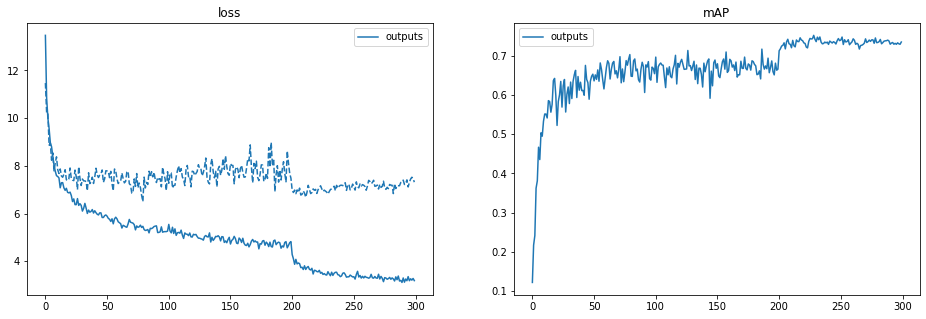

In [39]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/wendell/.cache/torch/hub/facebookresearch_detr_main/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/wendell/.cache/torch/hub/facebookresearch_detr_main/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/wendell/.cache/torch/hub/facebookresearch_detr_main/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns b

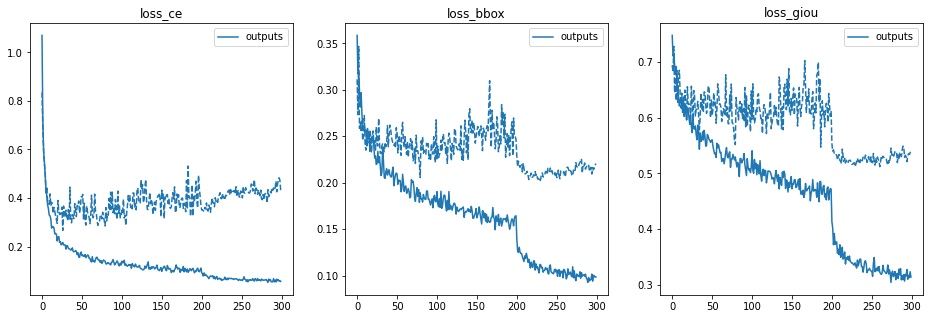

In [40]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/wendell/.cache/torch/hub/facebookresearch_detr_main/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/wendell/.cache/torch/hub/facebookresearch_detr_main/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


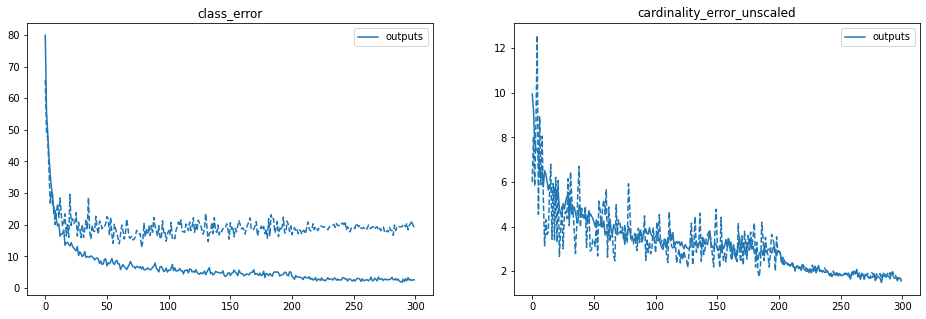

In [41]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [42]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /home/wendell/.cache/torch/hub/facebookresearch_detr_main
/home/wendell/miniconda3/envs/cv-hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wendell/miniconda3/envs/cv-hw1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Boilerplate functions to display fine-tuned results

In [57]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.savefig(f'result.png')
    plt.show()

In [56]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


### With a image

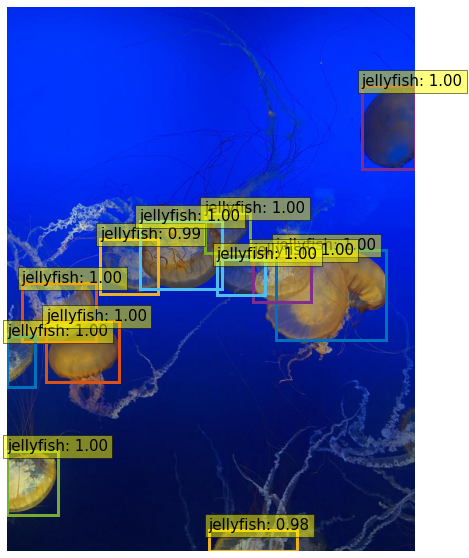

In [58]:
from PIL import Image

img_name = '../data/test/IMG_2574_jpeg_jpg.rf.ca0c3ad32384309a61e92d9a8bef87b9.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

### With a validation image

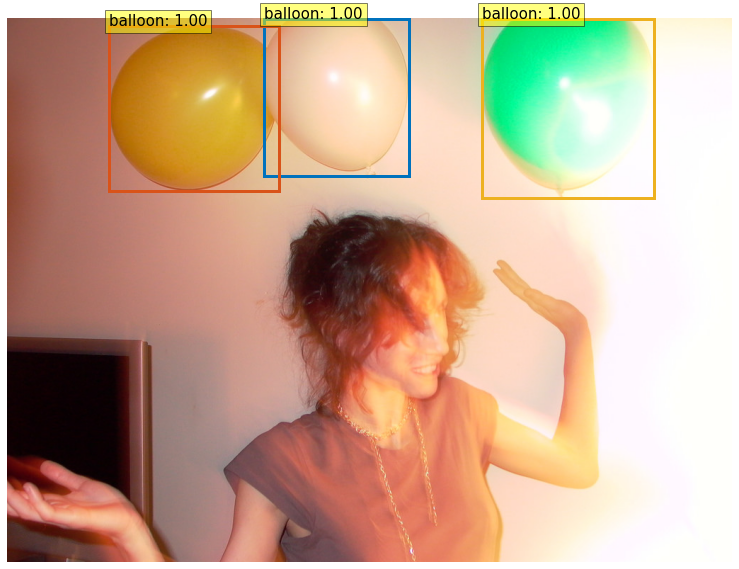

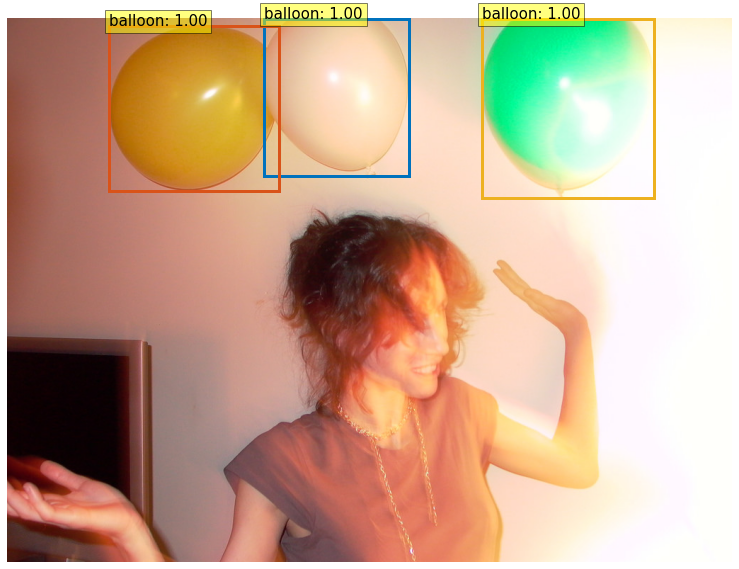

In [ ]:
from PIL import Image

img_name = '/content/data/custom/val2017/410488422_5f8991f26e_b.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)